## Script for analysing the velocities in Sebasitan Vizcaino Bay. 
##### One section with the bay, one without and one where they are subtracted from eachother to show the difference. 

In [1]:
from xmitgcm import open_mdsdataset
from MITgcmutils import rdmds
from MITgcmutils import mds
from MITgcmutils import diagnostics
import xmitgcm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dat
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import xarray as xr
import cmocean
import time 
import pylab as pl
import IPython
from IPython import display
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from math import radians, cos, sin, asin, sqrt
import netCDF4 as nc
from scipy.io import savemat
import scipy as sc
import scipy.io as sio
import scipy.signal as sig
import datetime
import warnings
warnings.filterwarnings("ignore")

In [13]:
params = {'font.size': 22,
          'figure.figsize': (30, 30),
         'font.family':'serif'}
pl.rcParams.update(params)


###### Loading datasets with and without bay

In [3]:
def loadNetCDFs(varname):
    dsw=[]
    dsn=[]
    for i in np.arange(1,8,1):
        
        pathn='/Volumes/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'noSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        pathw='/Volumes/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'withSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        
        dswin  = xr.open_dataset(pathw)
        dsnin = xr.open_dataset(pathn)
        
        dsw.append(dswin)
        dsn.append(dsnin)
        
    return dsw, dsn

def loadvar(dsw,dsn,hej):
    
    #varw=[]
    #varn=[]
    #for hej in np.arange(0,8,1):
        
    variable=dsw[hej].WVEL.values
    variablen=dsn[hej].WVEL.values
       # varw.append(variable)
        #varn.append(variablen)
        #print('plopp')
    return variable

In [4]:
dsw,dsn=loadNetCDFs('DYNVARS')

In [10]:
Wadeep=dsw[6].WVEL[:,60,:,:]-dsn[6].WVEL[:,60,:,:]

In [29]:
Wadedeep=sig.detrend(Wadeep,0)

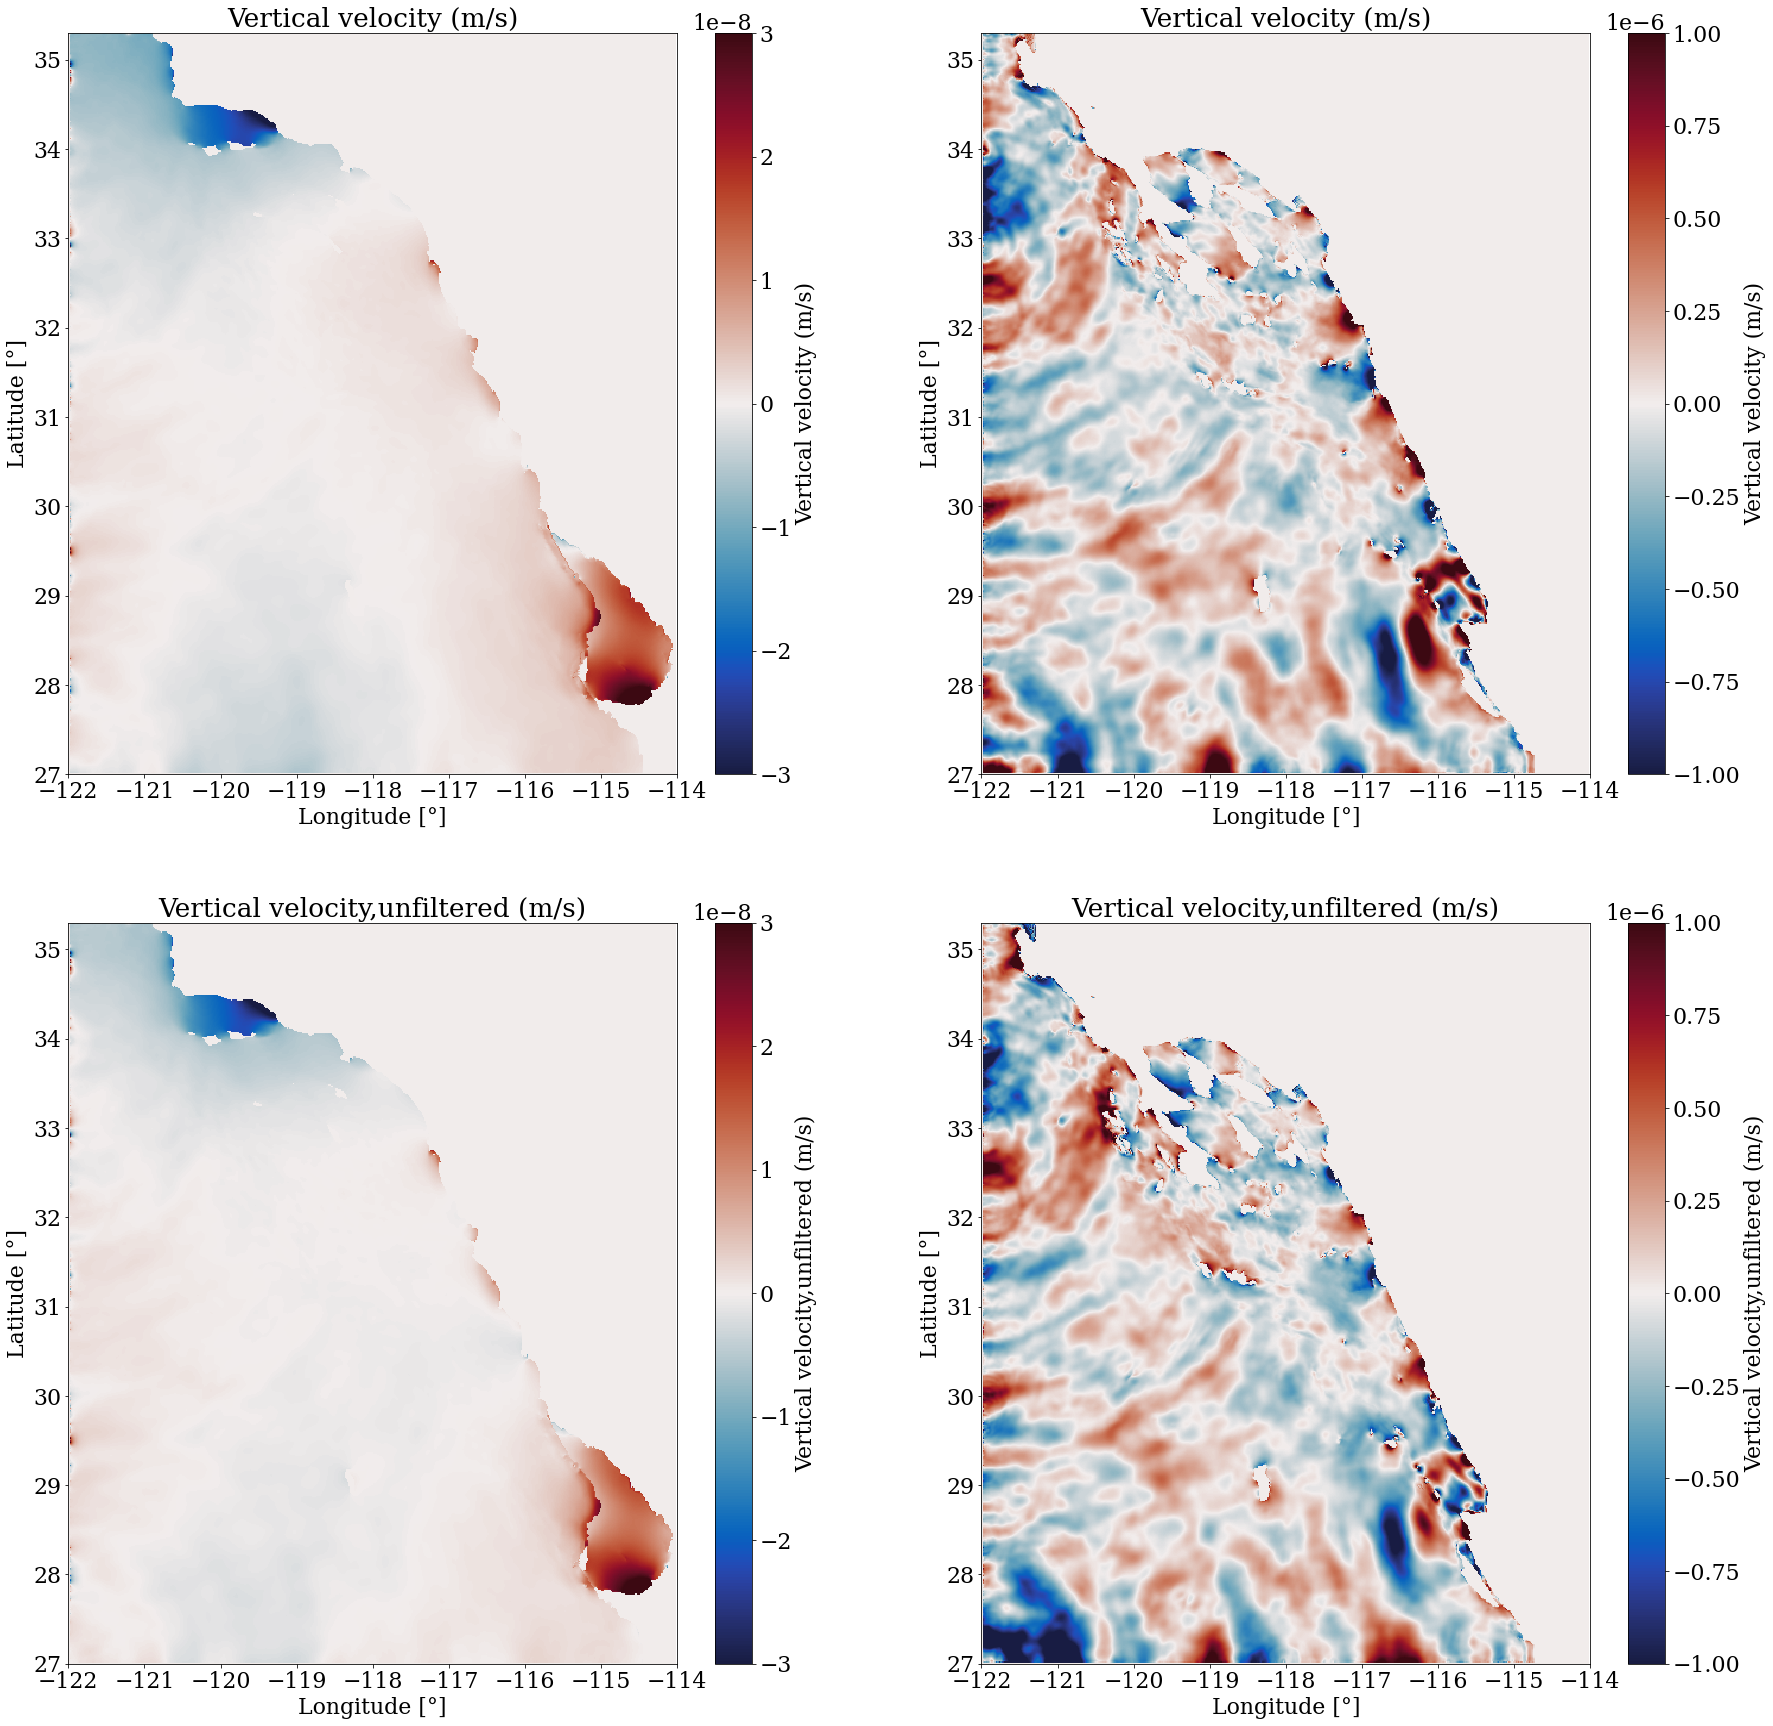

In [34]:
fig,ax=plt.subplots(2,2)
plot_above(ax[0,0],dsw[6].XC-360,dsw[6].YC,Wade[-1,:,:],'Vertical velocity (m/s)',-3*1e-8,3*1e-8)
plot_above(ax[0,1],dsw[6].XC-360,dsw[6].YC,Wadedeep[-1,:,:],'Vertical velocity (m/s)',-1e-6,1e-6)
plot_above(ax[1,1],dsw[6].XC-360,dsw[6].YC,Wadeep[-1,:,:],'Vertical velocity,unfiltered (m/s)',-1e-6,1e-6)
plot_above(ax[1,0],dsw[6].XC-360,dsw[6].YC,Wa[-1,:,:],'Vertical velocity,unfiltered (m/s)',-3*1e-8,3*1e-8)

In [25]:
def plot_above(ax,LON,LAT, VAL,title,vmin,vmax):
    
    xlab='Longitude [°]'
    ylab='Latitude [°]'
    
    
    #ax.set_facecolor('wheat')
    cax = ax.pcolormesh(LON,LAT,VAL,cmap=cmocean.cm.balance,vmin=vmin,vmax=vmax)
    ax.set_title(title)
    cbar_ax = plt.colorbar(cax, ax=ax)
    ax.set(xlabel=xlab, ylabel=ylab)
    cbar_ax.set_label(title)
    ax.set_xlim(-122,-114) 
    ax.set_ylim(27,35.3)

###### Define all other variables

In [6]:
LAT = dsn[0].YC
LON1 = dsn[0].XC[:417]-360
LON2 = dsn[0].XC[:385]-360
LON3 = dsn[0].XC[:365]-360
LON4 = dsn[0].XC[:333]-360

distance30=cos((30*np.pi)/180)*111*-1*(LON1-LON1[-1])
distance307=cos((307*np.pi)/180)*111*-1*(LON2-LON2[-1]) 
distance314=cos((314*np.pi)/180)*111*-1*(LON3-LON3[-1])
distance32=cos((32*np.pi)/180)*111*-1*(LON4-LON4[-1])


indlon30pre=np.where(distance30<=100)
indlon307pre=np.where(distance307<=100)
indlon314pre=np.where(distance314<=100)
indlon32pre=np.where(distance32<=100)


indlon30=350
indlon307=289
indlon314=281
indlon32=264

dist30=distance30[indlon30:]
dist307=distance307[indlon307:]
dist314=distance314[indlon314:]
dist32=distance32[indlon32:]

ind30=220 #30° N
ind307=220+50 #30.7° N
ind314=220+100 #31.4° N
ind32=220+150 #32° N

Z = dsw[0].Z[:71]
TIME=dsw[0].time
time=np.arange(2880,17280,2200)
nt = np.size(TIME)

maskww=dsw[0].maskInW==False
maskwn=dsn[0].maskInW==False

nx = 512
ny = 612
nz = 100

#### Plotting functions

In [18]:
def plot_side(ax,LON,Z,VAL,n,title2,fig):
    
    if n==1:
        title='30°N'
        latind=0
        indlon=np.arange(350,417,1)
    elif n==2:
        title='30.7°N'
        latind=50
        indlon=np.arange(289,385,1)
    elif n==3:
        title='31.4°N'
        latind=100
        indlon=np.arange(281,365,1)
    elif n==4:
        title='32°N'
        latind=150
        indlon=np.arange(264,333,1)


    hFacC = dsw[0].hFacC
    hfac = np.ma.masked_values(hFacC[:71,latind+220,indlon], 0)
    mask = np.ma.getmask(hfac)
    xlab='Crosshore distance (km)'
    ylab='Depth (m)'
    maxv =np.max(VAL)+1.6e-5# for w:-1.6e-5
    minv =-maxv # for w:1.6e-5
    ax.set_facecolor('tan')
    cax = ax.pcolormesh(LON, Z,np.ma.masked_array(VAL, mask=mask)
                      ,cmap=cmocean.cm.curl, vmin=minv,vmax=maxv, zorder=1)
    ax.contour(LON, Z,np.ma.masked_array(VAL, mask=mask), levels=[0],vmin=minv,vmax=maxv, linewidths=2, linestyles='-', colors='k', zorder=2)
    ax.set_title(title)
    ax.set(xlabel=xlab, ylabel=ylab)
    
    if n==4:
        cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
        fig.colorbar(cax, cax=cbar_ax)
        cbar_ax.set_ylabel(title2)
        
   
    

In [8]:
def plot_vel(time0,dist30,dist307,dist314,dist32,Z,VALb,VALn,Vel,fig,ax): 
    
 
    indlon30=350
    indlon307=289
    indlon314=281
    indlon32=264
    
    ind30=220 #30° N
    ind307=220+50 #30.7° N
    ind314=220+100 #31.4° N
    ind32=220+150 #32° N
    
    velb1=VALb[0,:71,ind30,indlon30:417].values
    veln1=VALn[0,:71,ind30,indlon30:417].values

    velb2=VALb[0,:71,ind307,indlon307:385].values
    veln2=VALn[0,:71,ind307,indlon307:385].values

    velb3=VALb[0,:71,ind314,indlon314:365].values
    veln3=VALn[0,:71,ind314,indlon314:365].values

    velb4=VALb[0,:71,ind32,indlon32:333].values
    veln4=VALn[0,:71,ind32,indlon32:333].values
    
    plot_side(ax[0,0],dist30,Z,velb1-veln1,1,Vel,fig)
    plot_side(ax[0,1],dist307,Z,velb2-veln2,2,Vel,fig)
    plot_side(ax[1,0],dist314,Z,velb3-veln3,3,Vel,fig)
    plot_side(ax[1,1],dist32,Z,velb4-veln4,4,Vel,fig)


## Plot to find modes

#### Vertical velocity

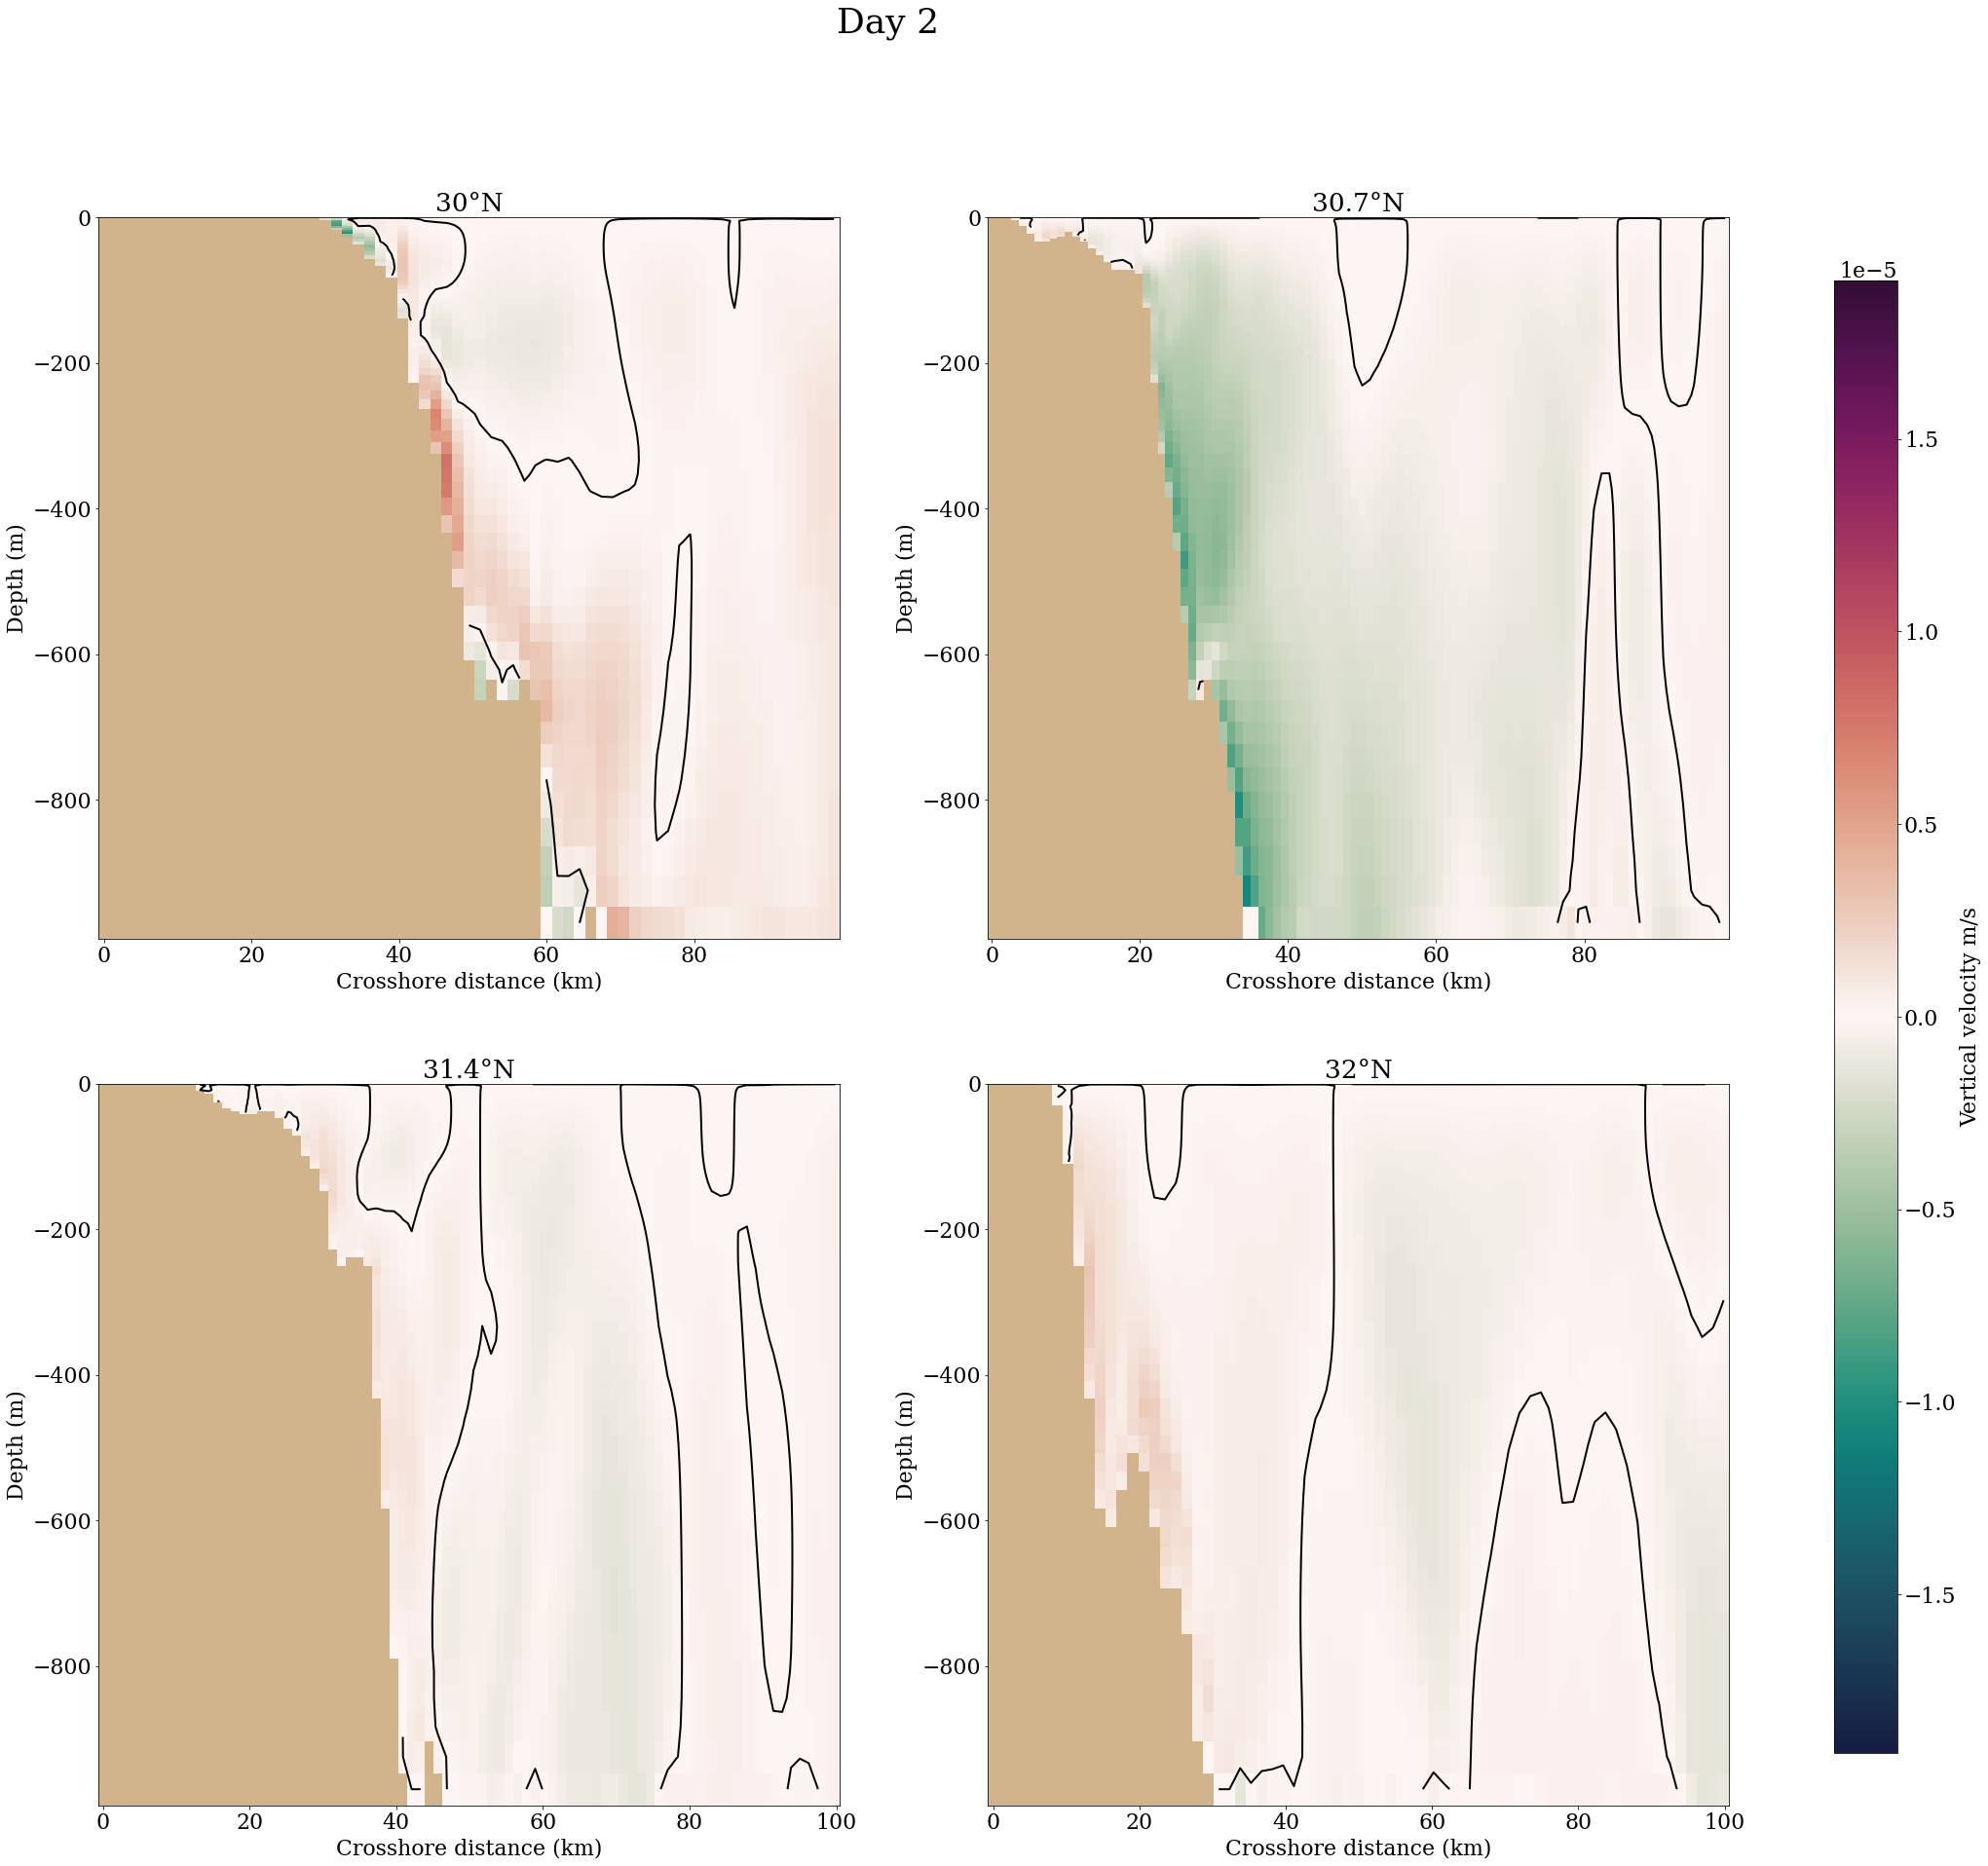

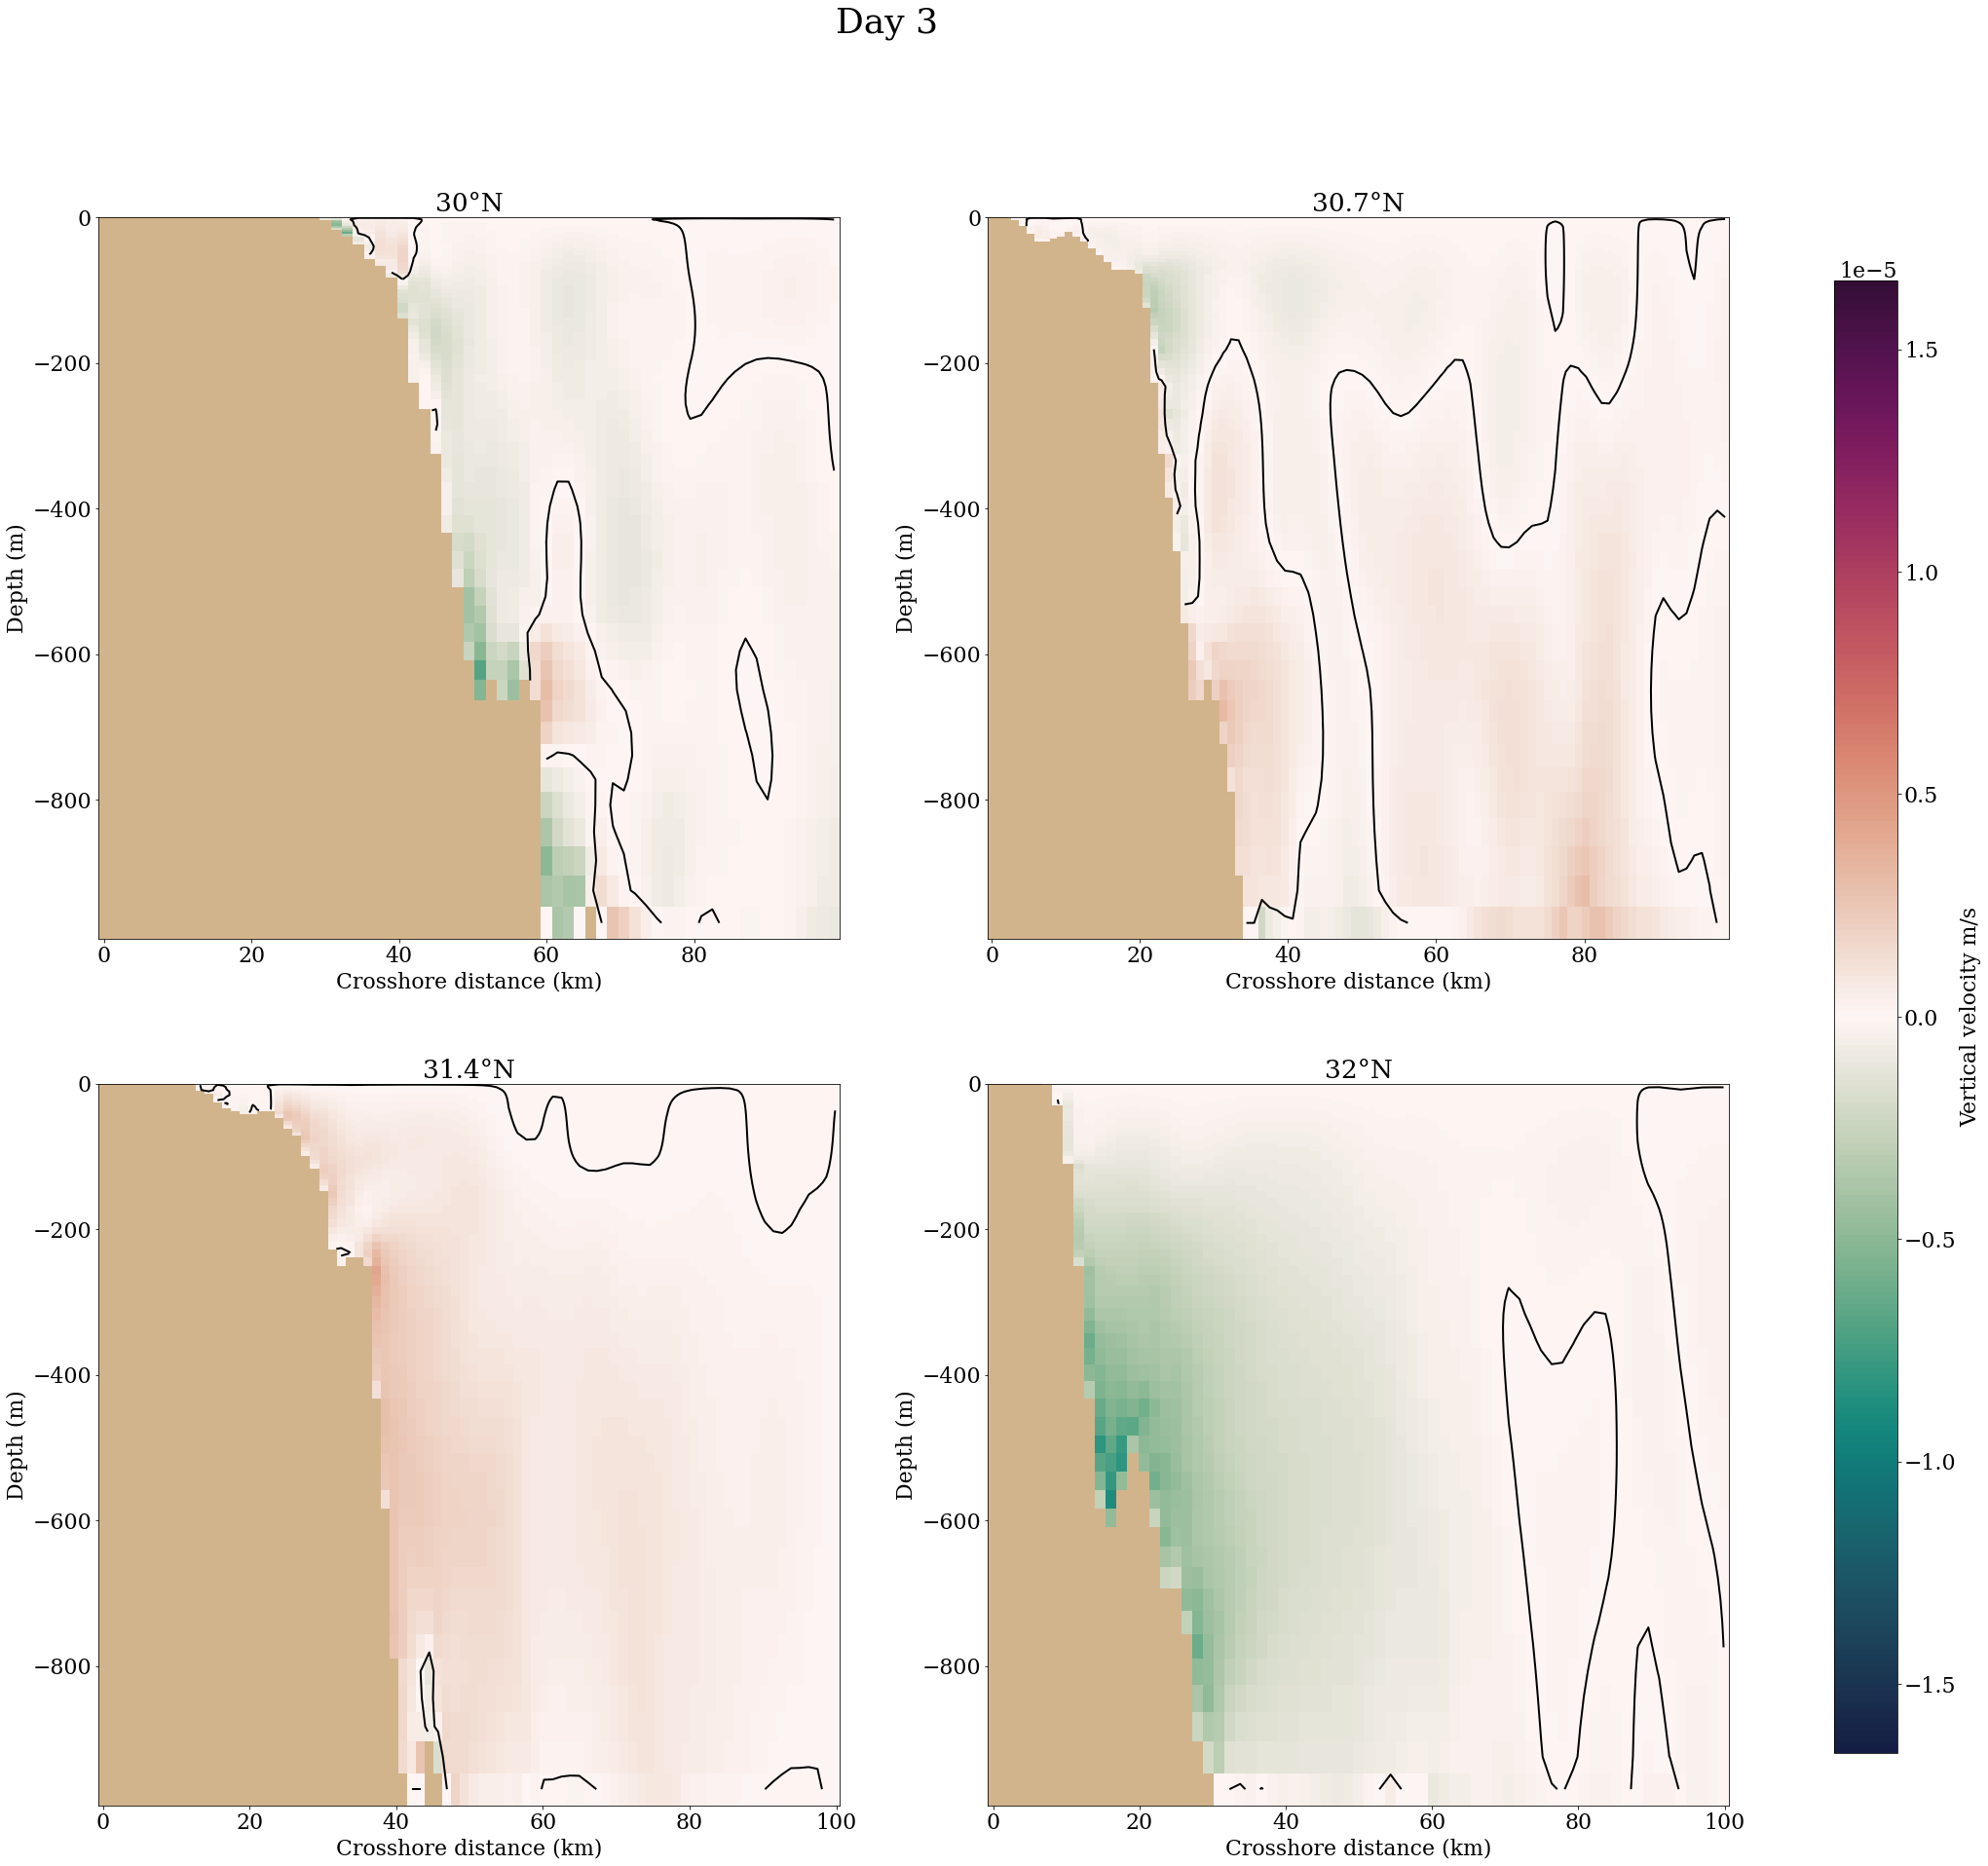

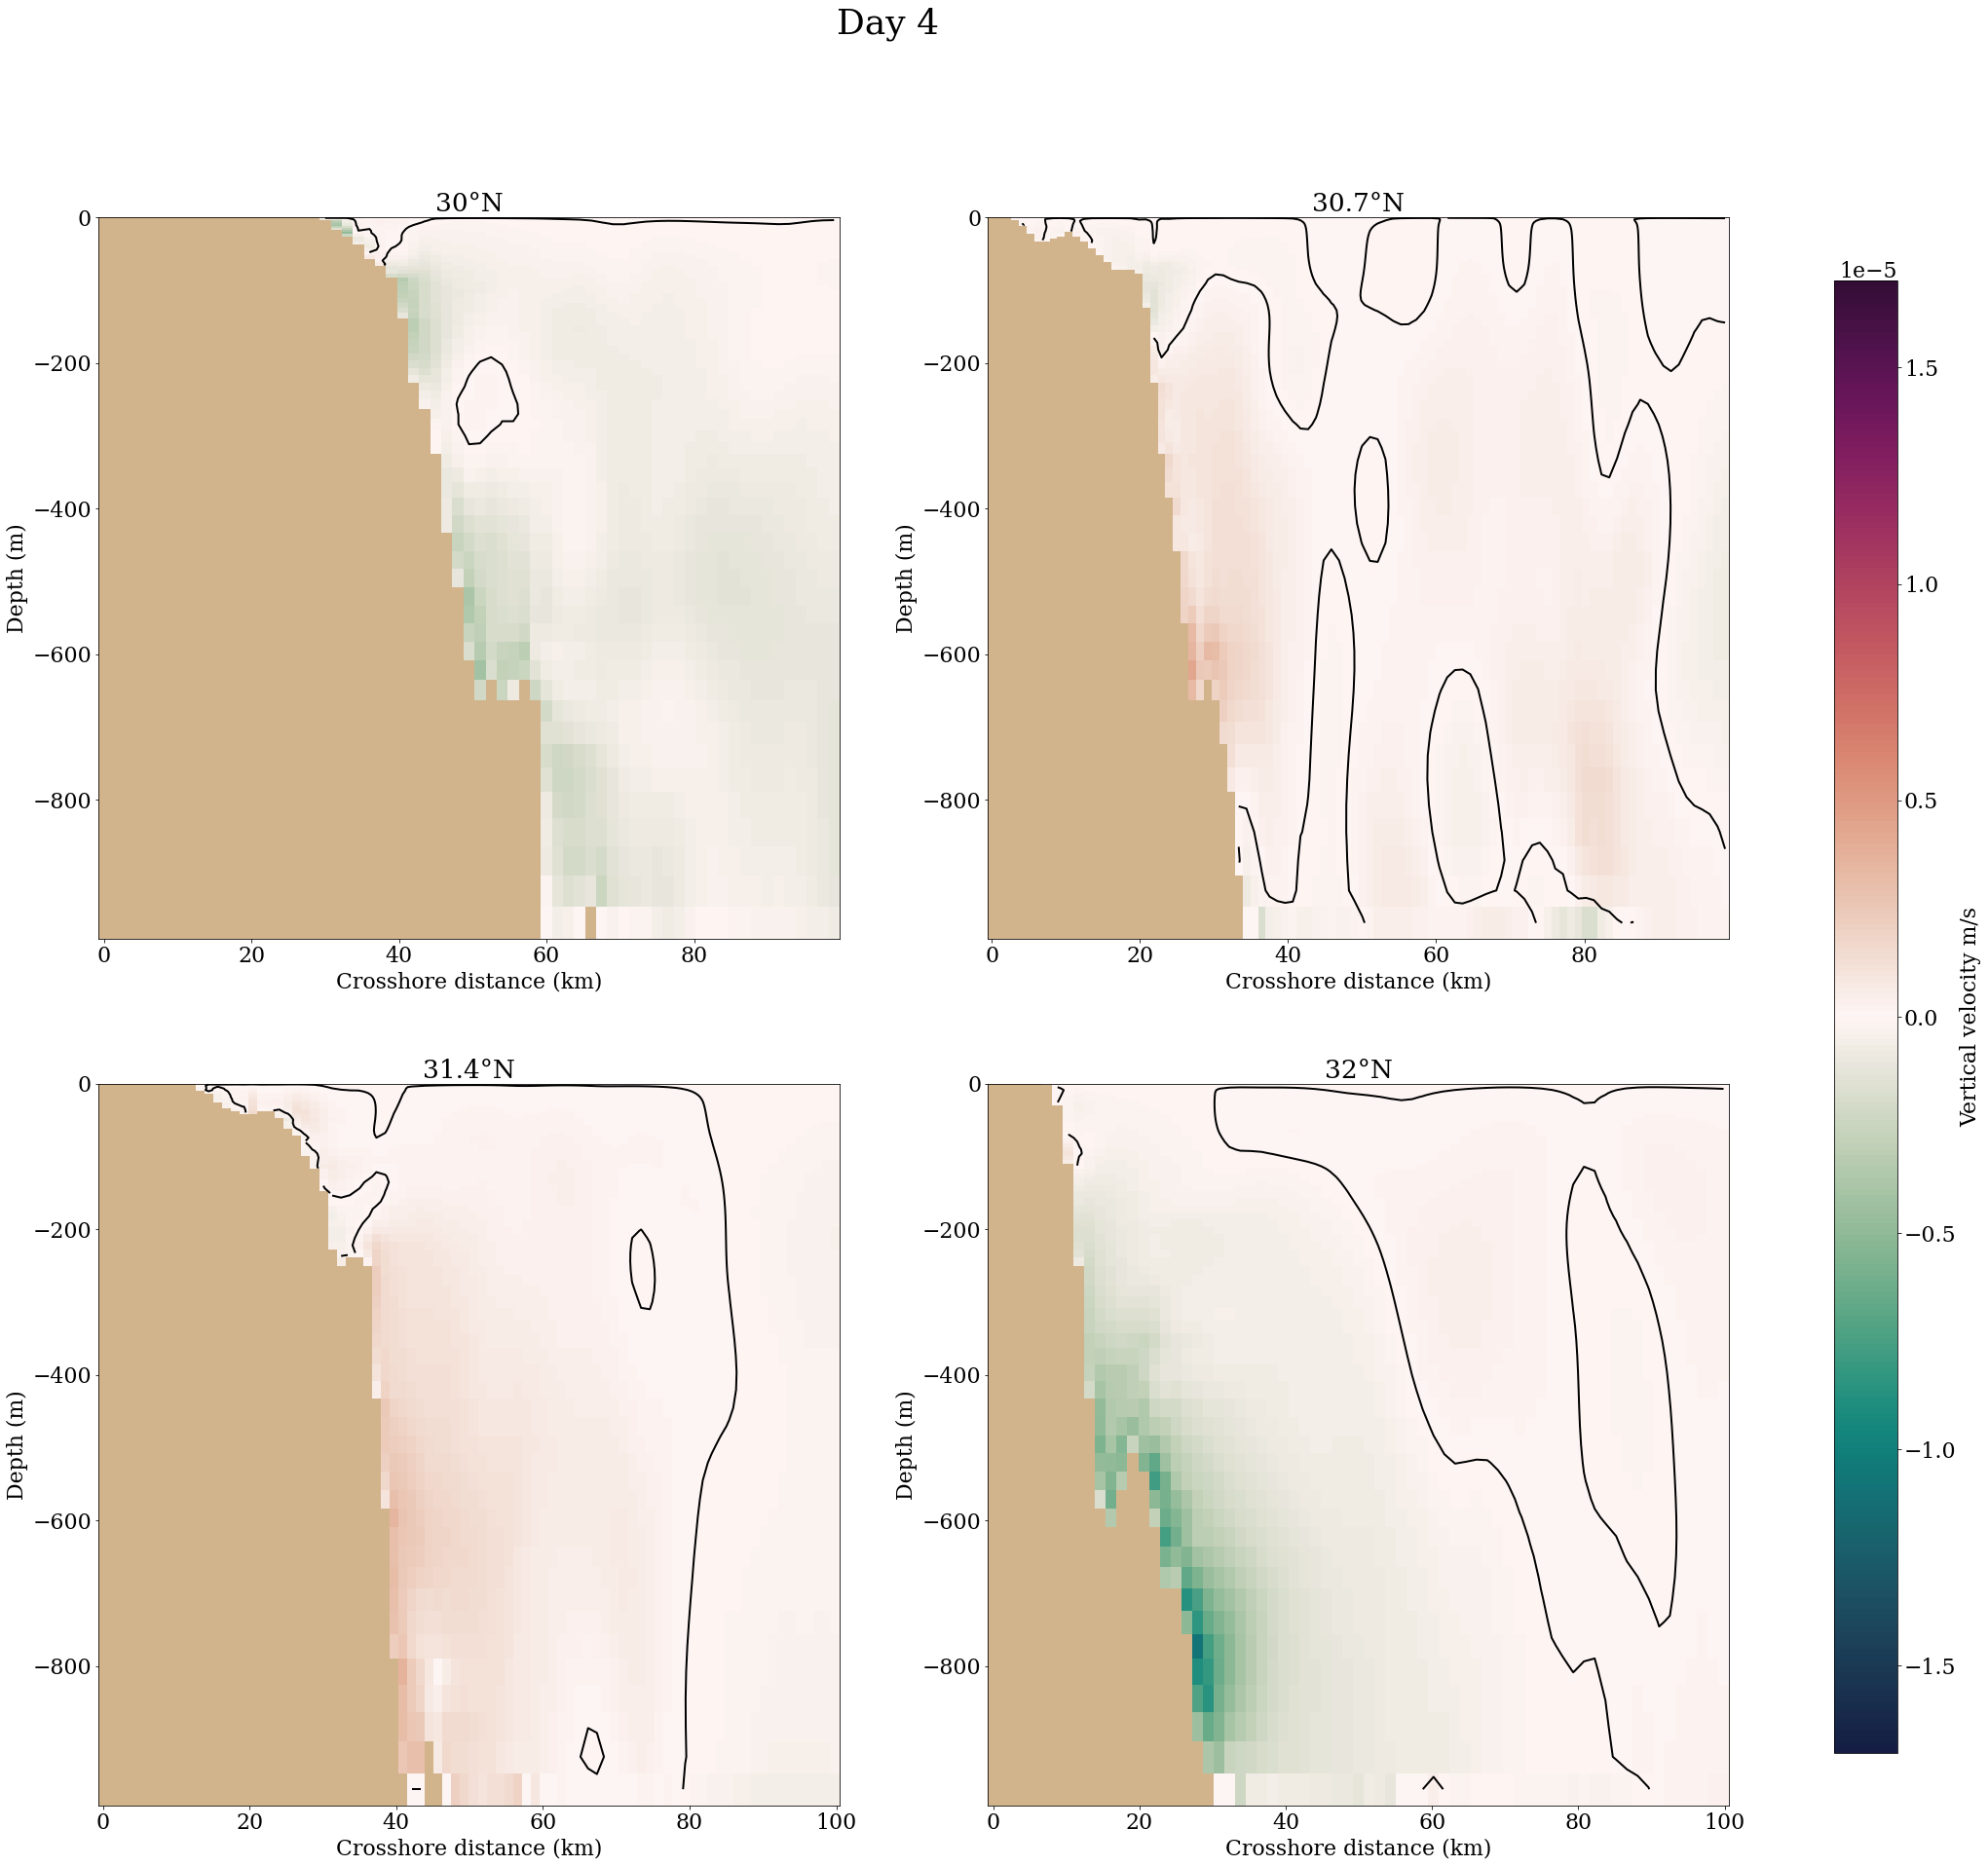

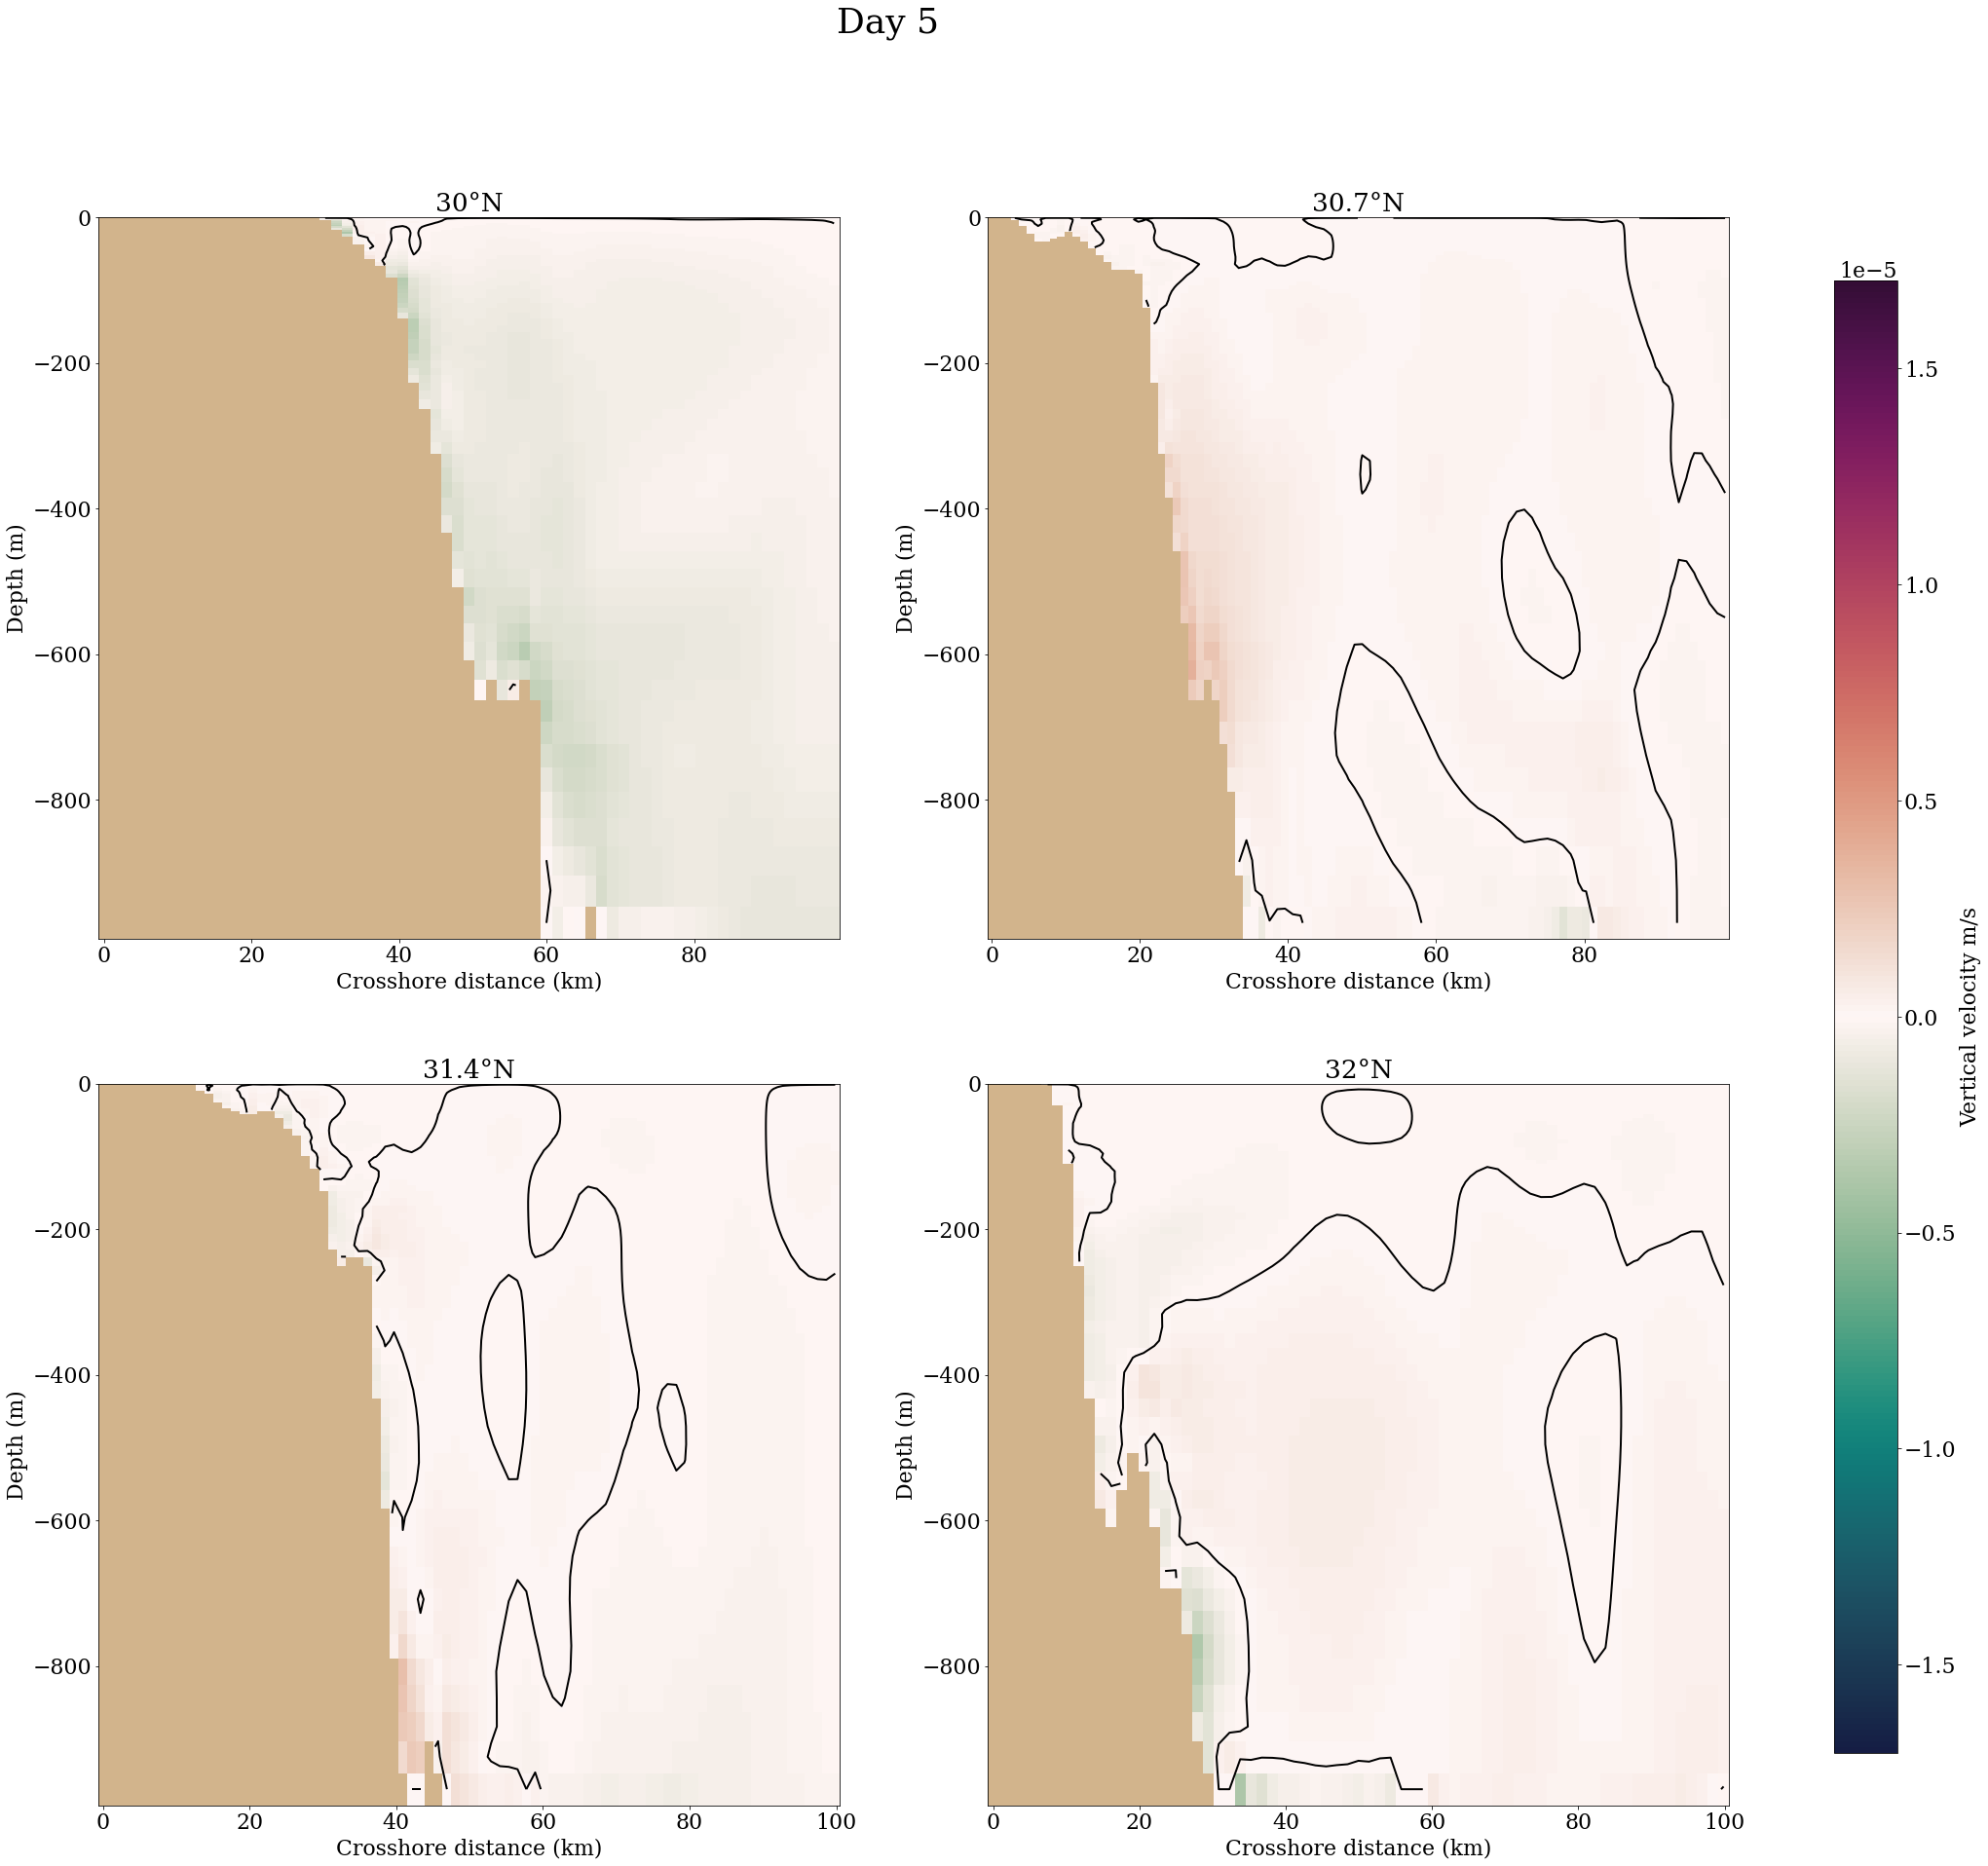

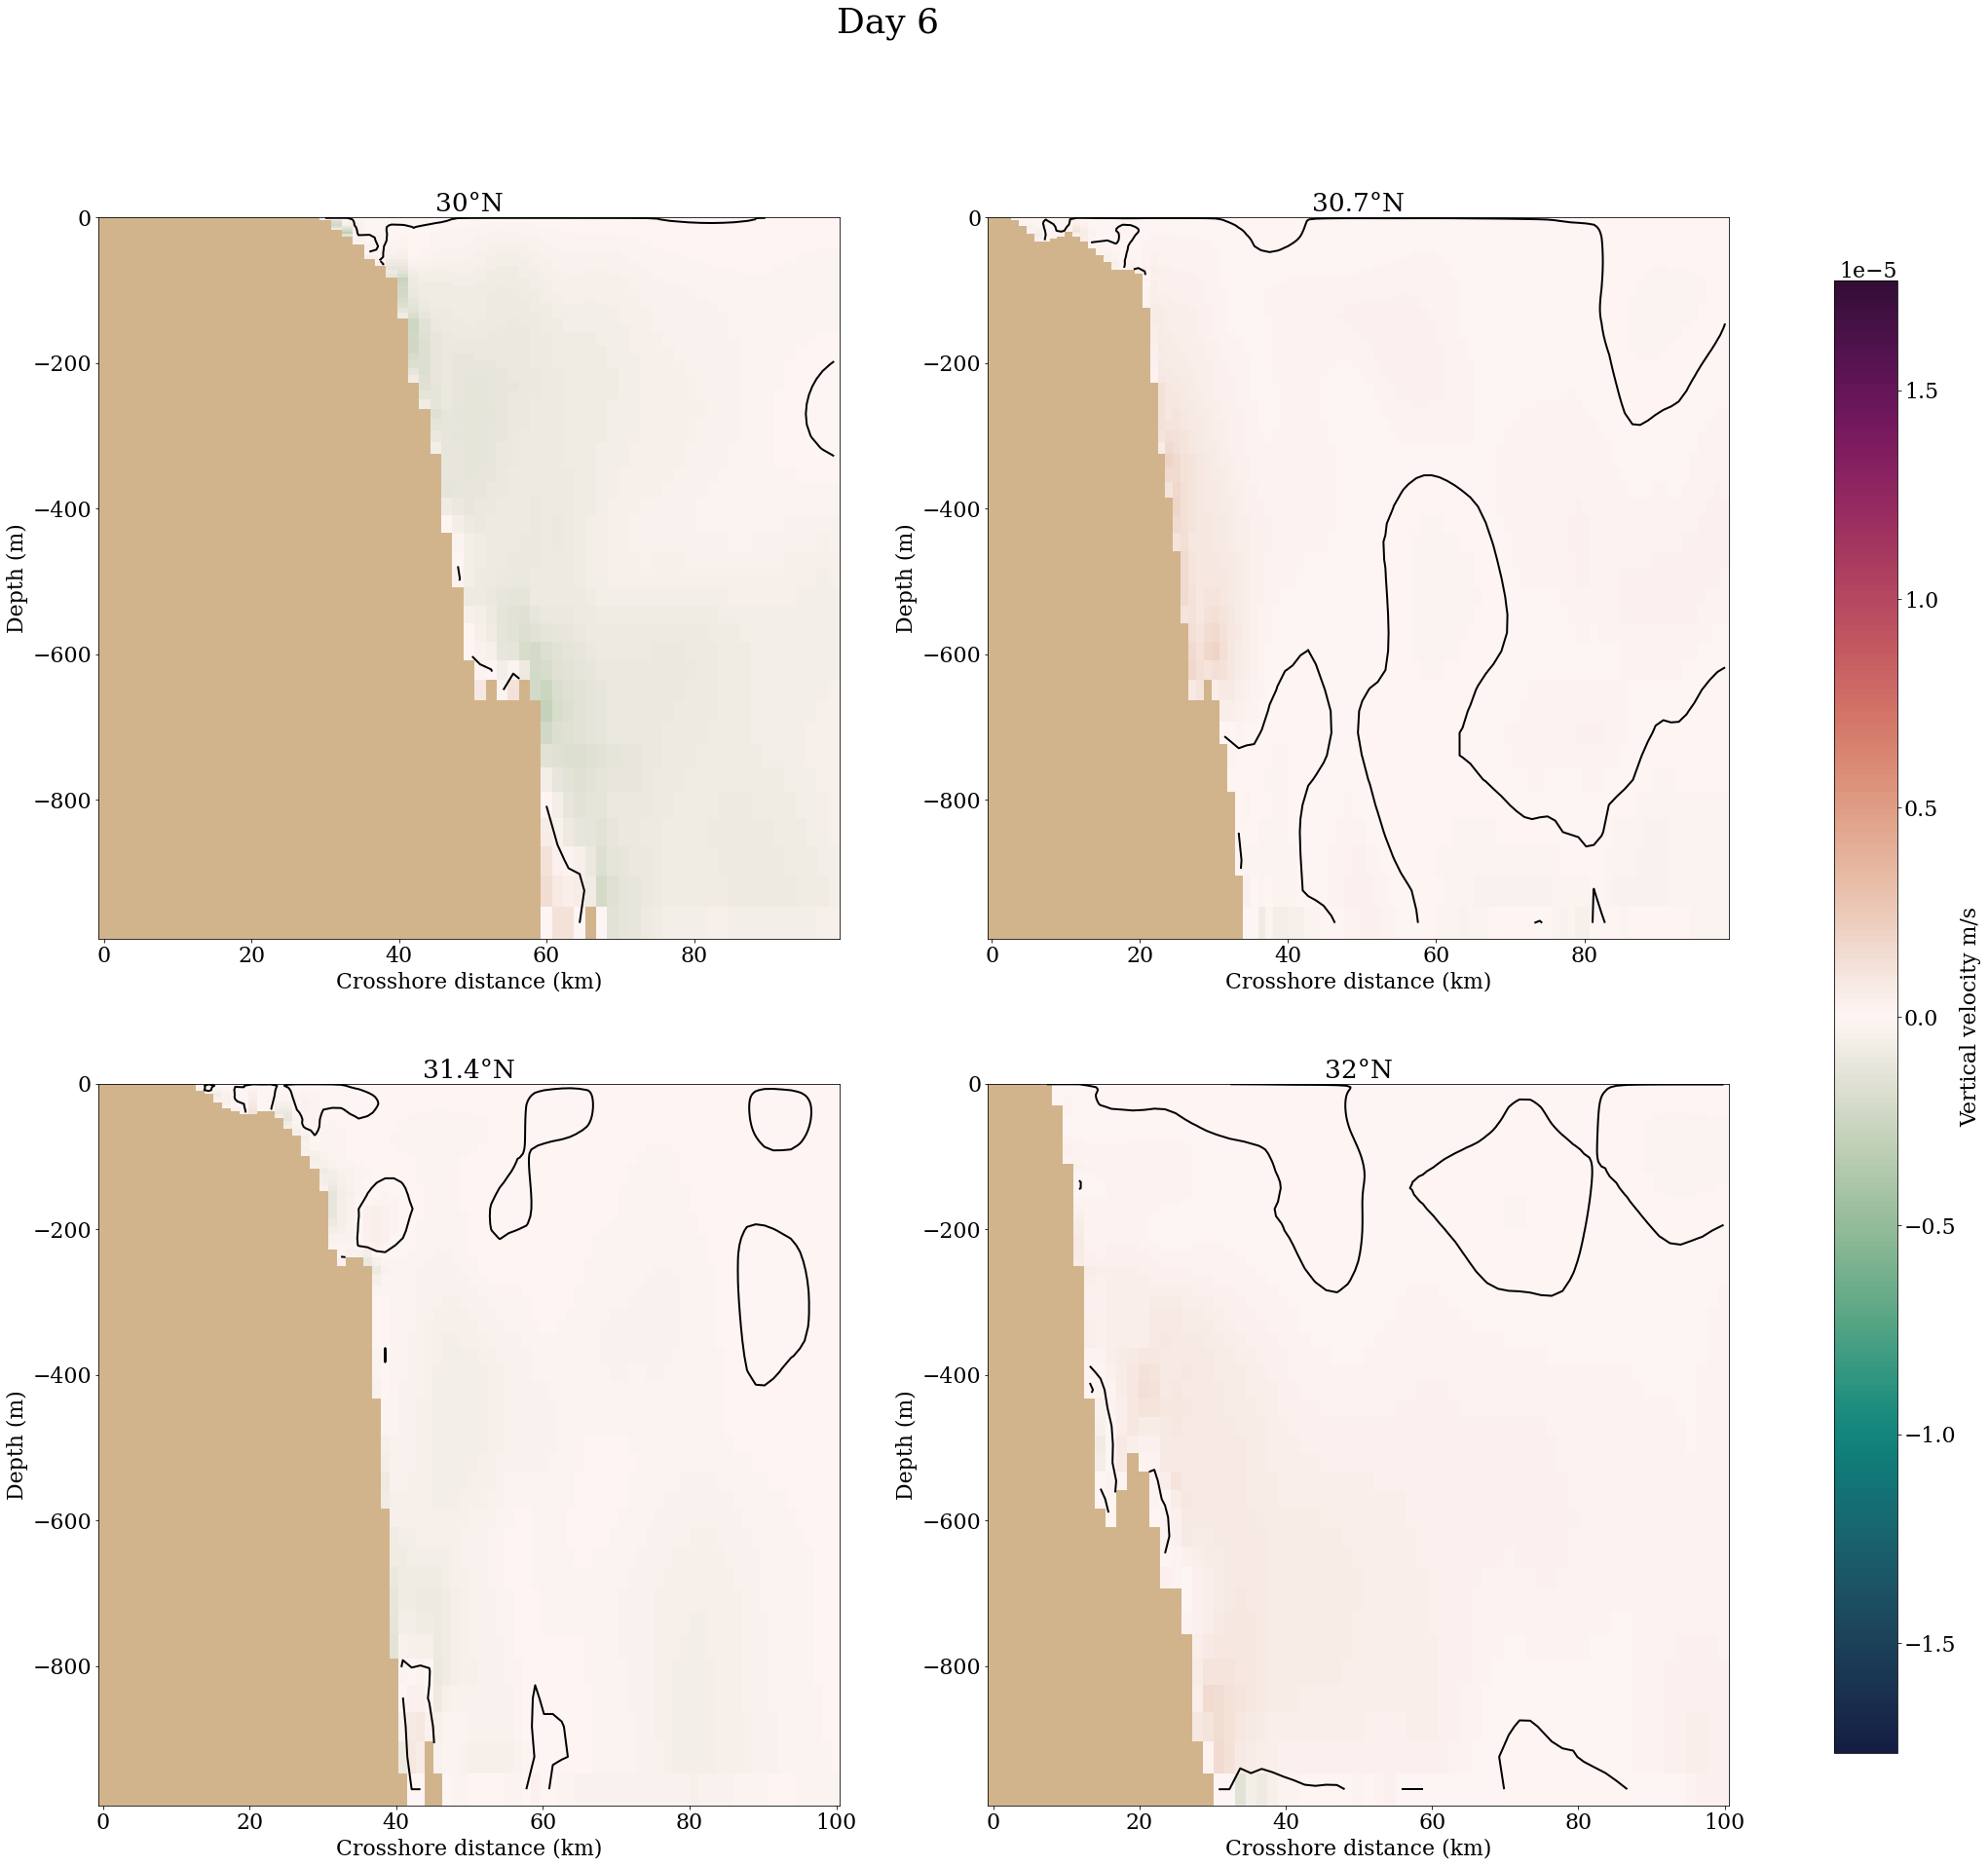

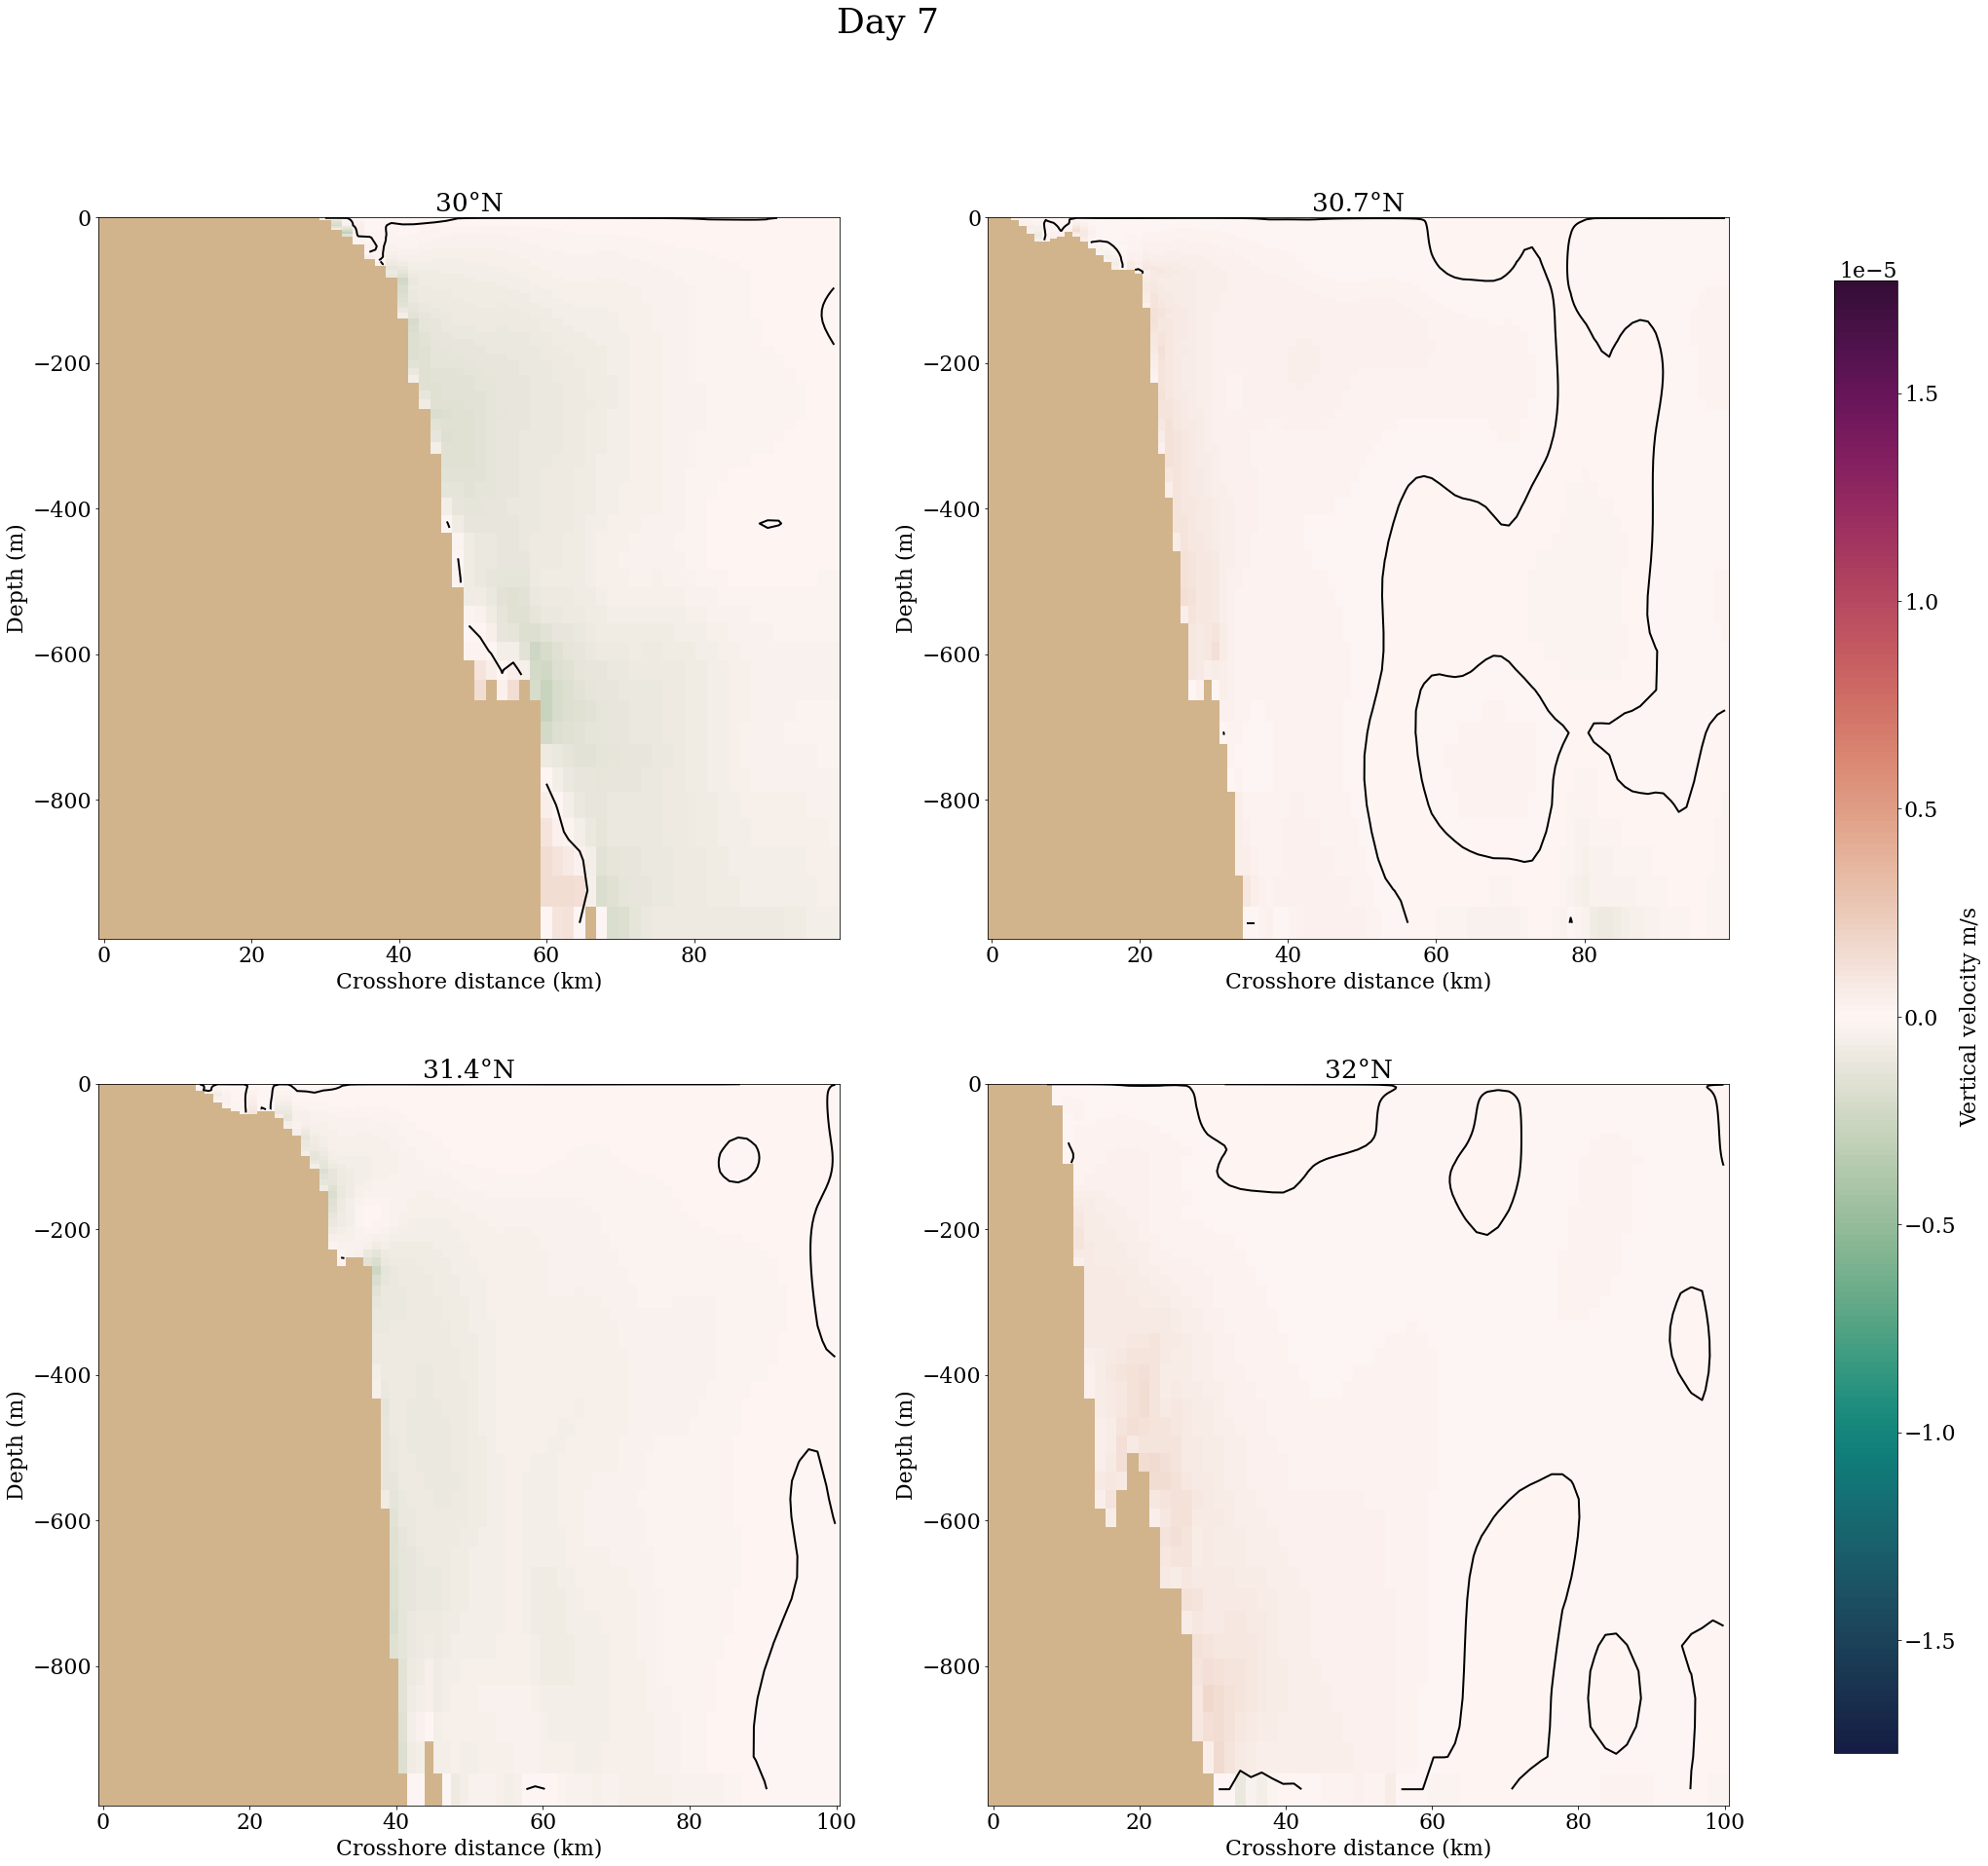

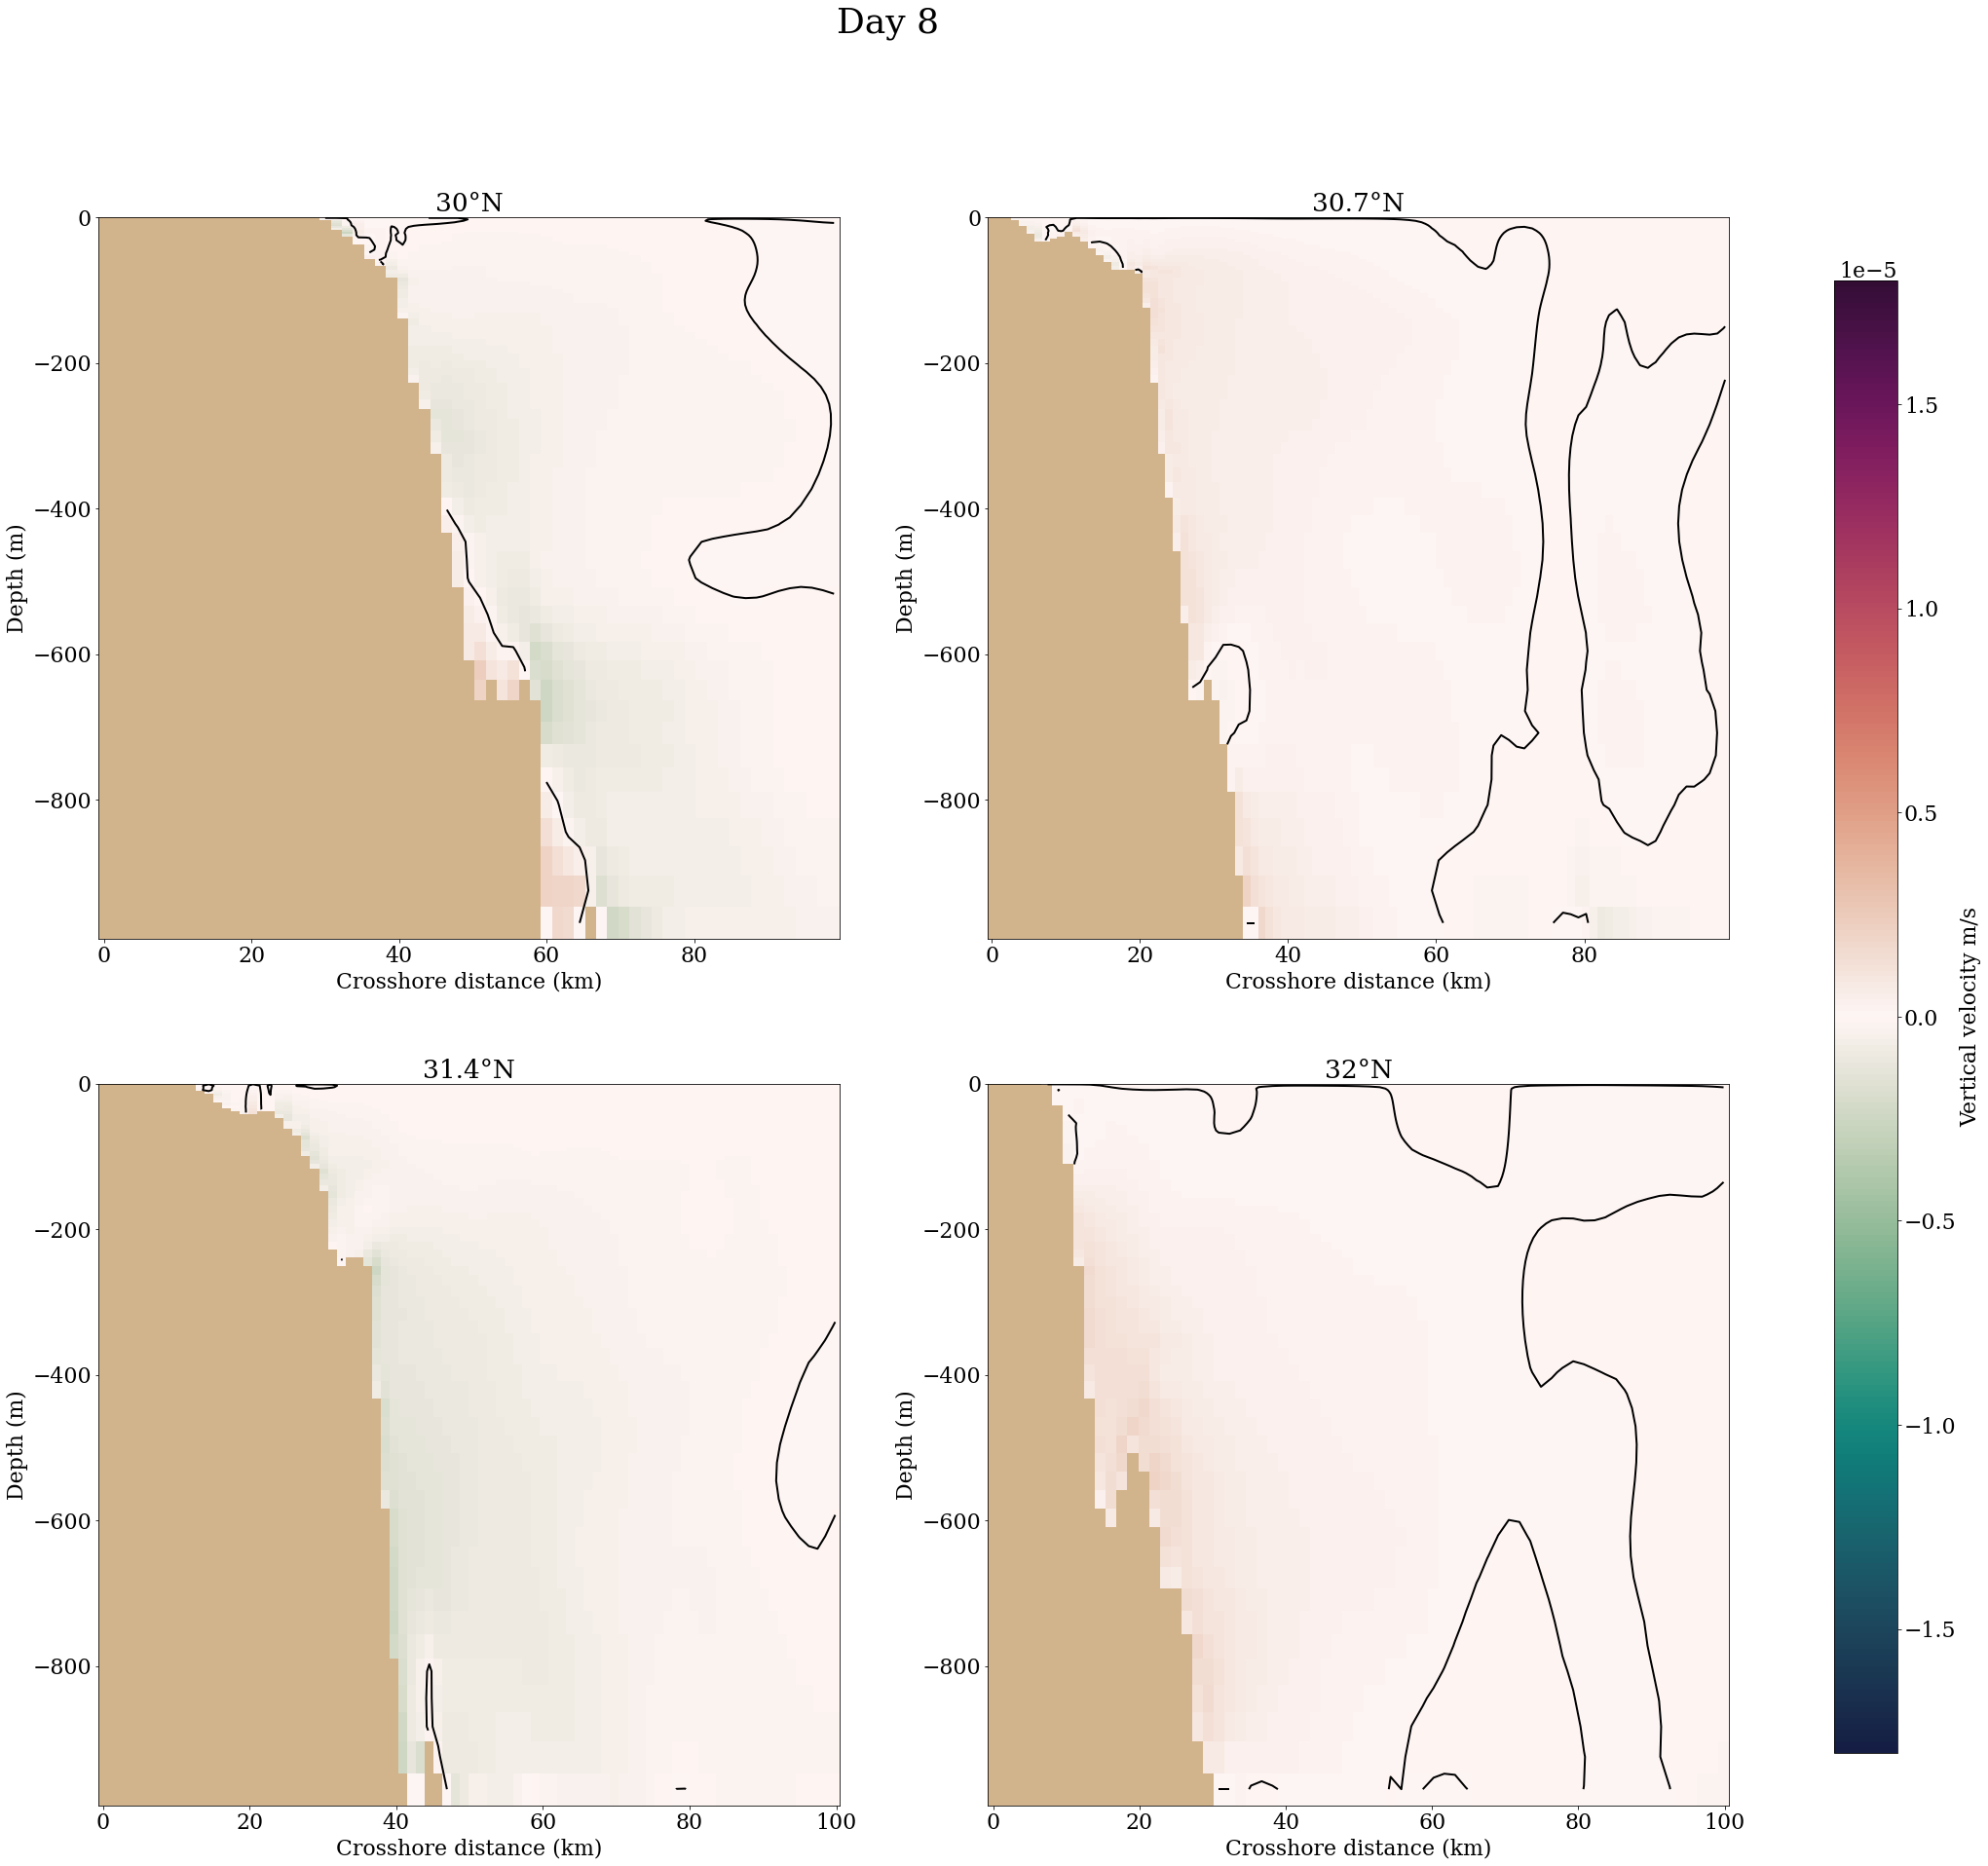

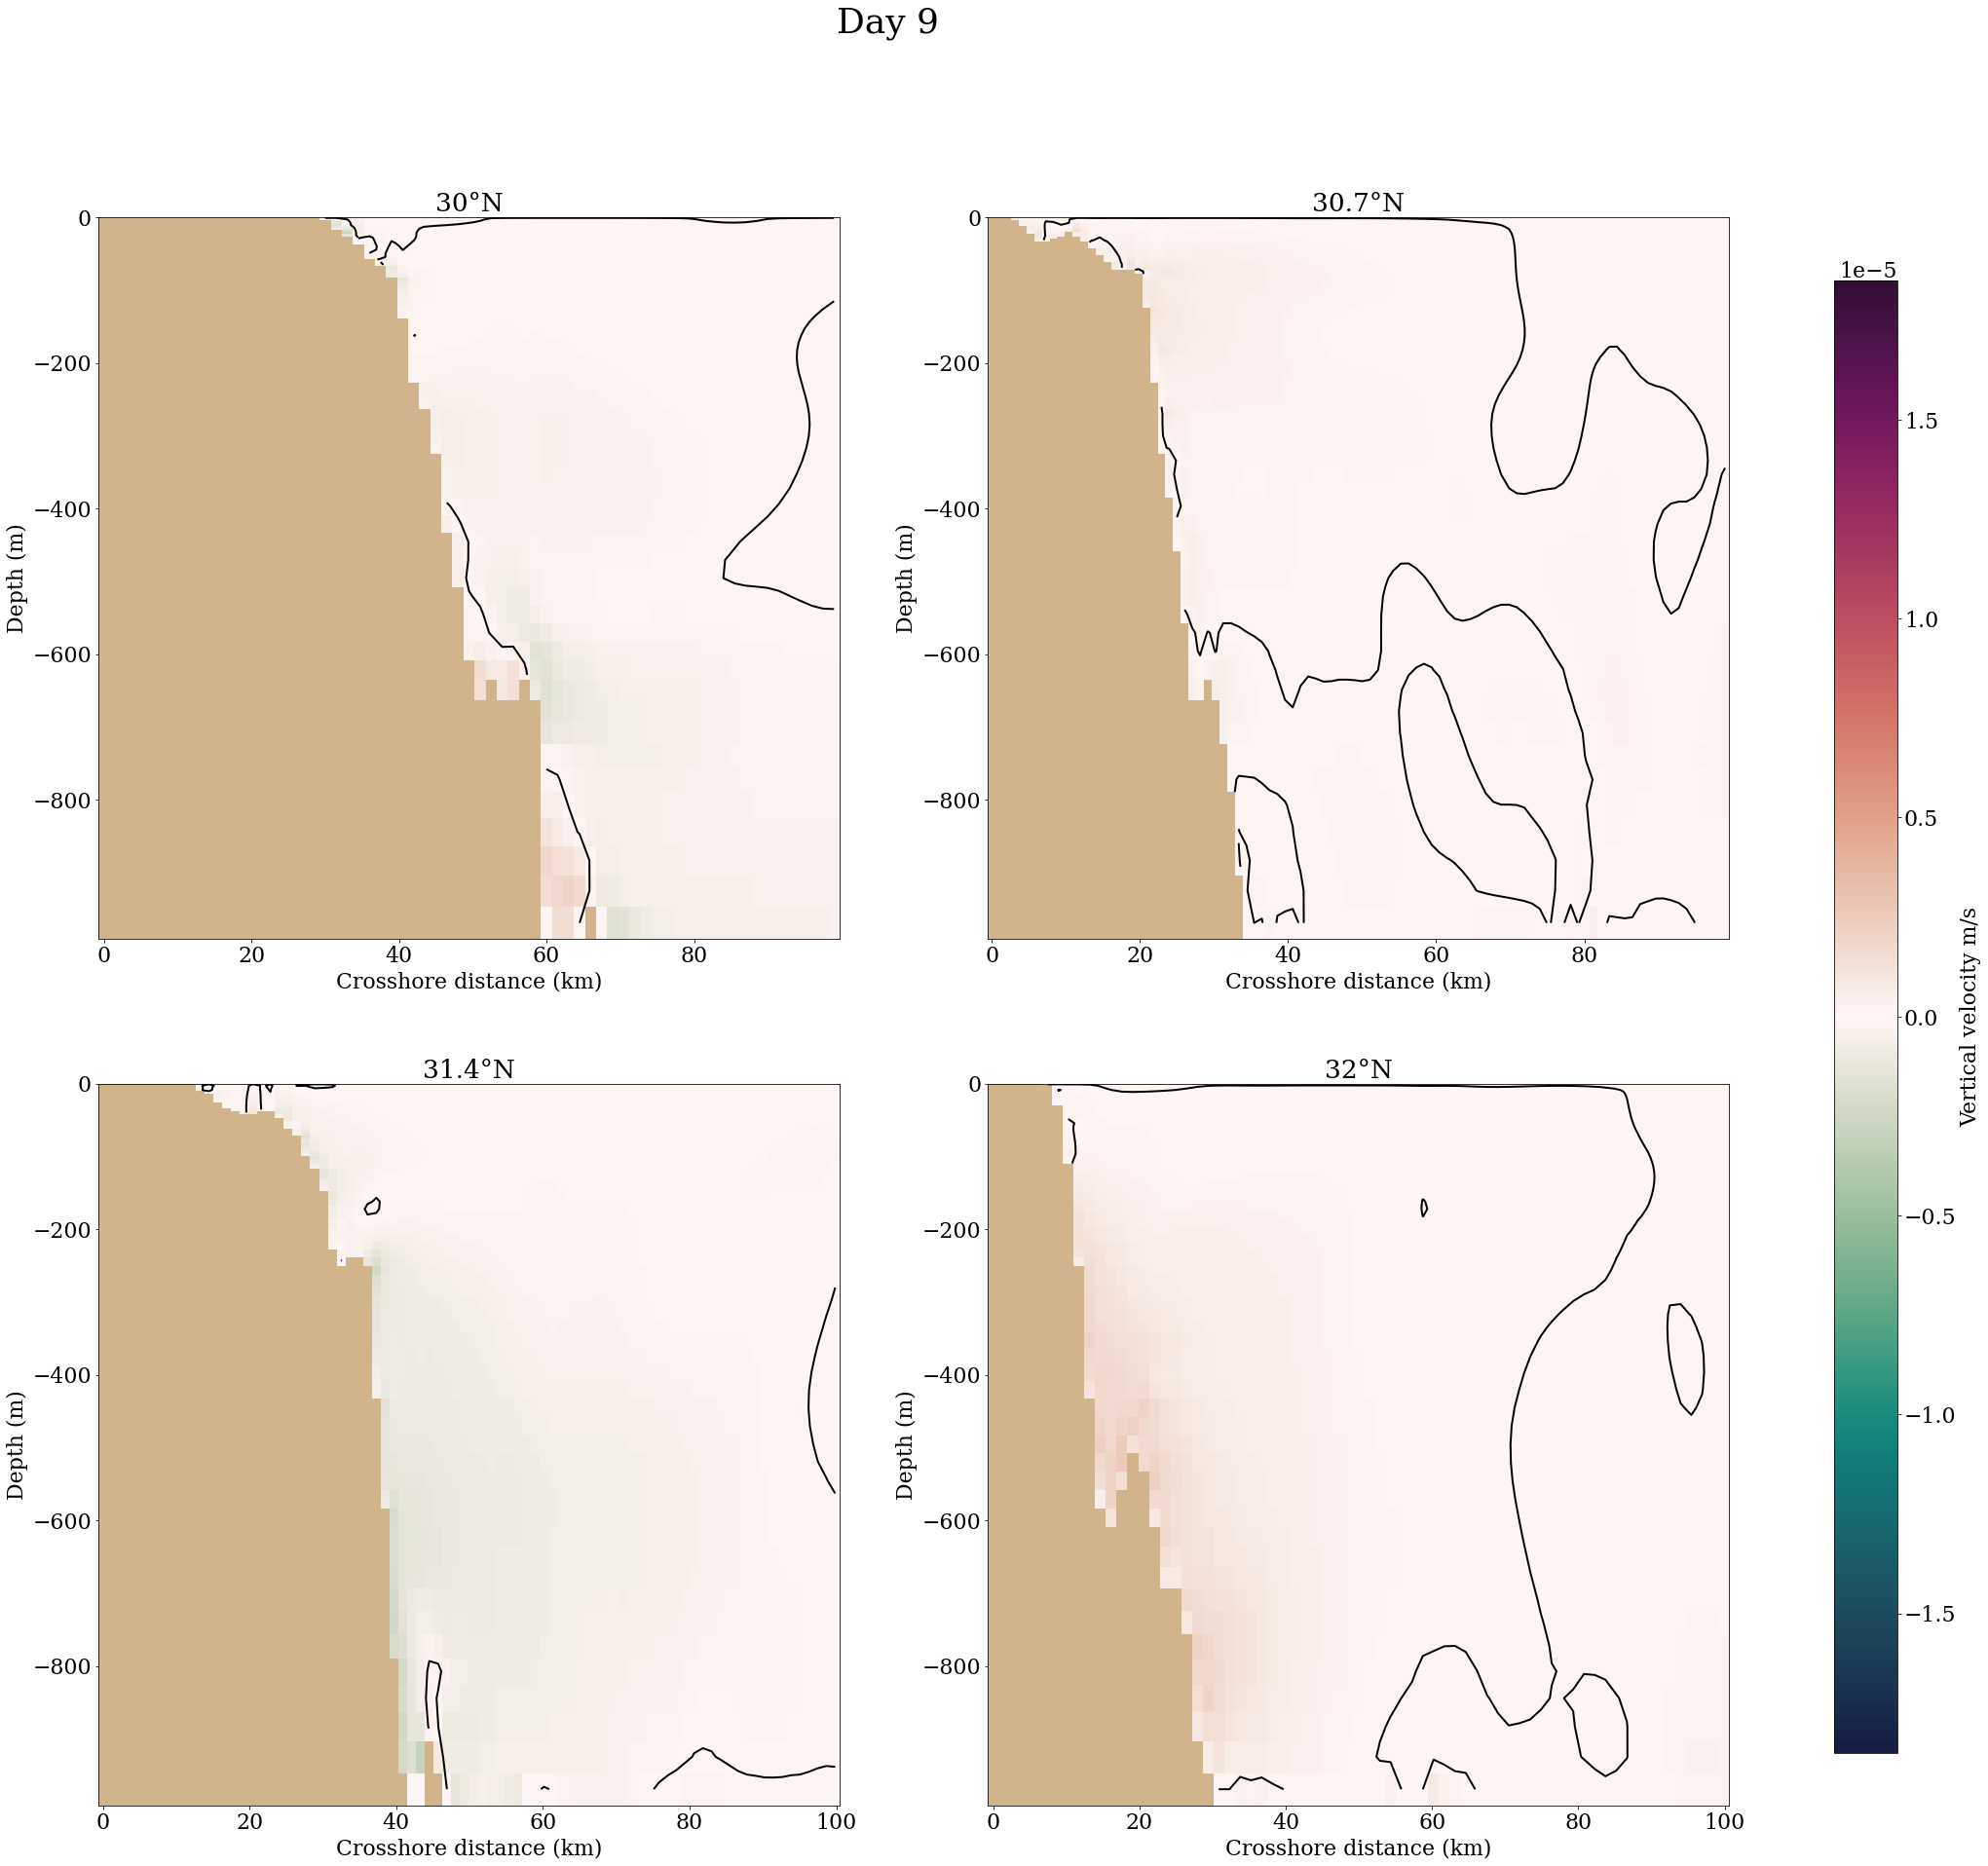

In [19]:
time0=0 #Day 2.5
time1=1 # Day 3.5
time2=2 # Day 5
time3=3 # Day 6
time4=4 #Day 7
time5=5 #Day 8
time6=6 #Day 9
Vel='Vertical velocity m/s'


fig0, ax = plt.subplots(2,2)
fig0.suptitle('Day 2', fontsize=36)
VALb=dsw[0].WVEL
VALn=dsn[0].WVEL
plot_vel(time0,dist30,dist307,dist314,dist32,Z,VALb,VALn,Vel,fig0,ax)

fig1, ax = plt.subplots(2,2)
fig1.suptitle('Day 3', fontsize=36)
VALb=dsw[1].WVEL
VALn=dsn[1].WVEL
plot_vel(time1,dist30,dist307,dist314,dist32,Z,VALb,VALn,Vel,fig1,ax)

fig2, ax = plt.subplots(2,2)
fig2.suptitle('Day 4', fontsize=36)
VALb=dsw[2].WVEL
VALn=dsn[2].WVEL
plot_vel(time1,dist30,dist307,dist314,dist32,Z,VALb,VALn,Vel,fig2,ax)

fig3, ax = plt.subplots(2,2)
fig3.suptitle('Day 5', fontsize=36)
VALb=dsw[3].WVEL
VALn=dsn[3].WVEL
plot_vel(time2,dist30,dist307,dist314,dist32,Z,VALb,VALn,Vel,fig3,ax)

fig4, ax = plt.subplots(2,2)
fig4.suptitle('Day 6', fontsize=36)
VALb=dsw[4].WVEL
VALn=dsn[4].WVEL
plot_vel(time3,dist30,dist307,dist314,dist32,Z,VALb,VALn,Vel,fig4,ax)

fig5, ax = plt.subplots(2,2)
fig5.suptitle('Day 7', fontsize=36)
VALb=dsw[5].WVEL
VALn=dsn[5].WVEL
plot_vel(time4,dist30,dist307,dist314,dist32,Z,VALb,VALn,Vel,fig5,ax)

fig6, ax = plt.subplots(2,2)
fig6.suptitle('Day 8', fontsize=36)
VALb=dsw[6].WVEL
VALn=dsn[6].WVEL
plot_vel(time5,dist30,dist307,dist314,dist32,Z,VALb,VALn,Vel,fig6,ax)

fig7, ax = plt.subplots(2,2)
fig7.suptitle('Day 9', fontsize=36)
VALb=dsw[7].WVEL
VALn=dsn[7].WVEL
plot_vel(time6,dist30,dist307,dist314,dist32,Z,VALb,VALn,Vel,fig7,ax)

#### Alongshore velocity

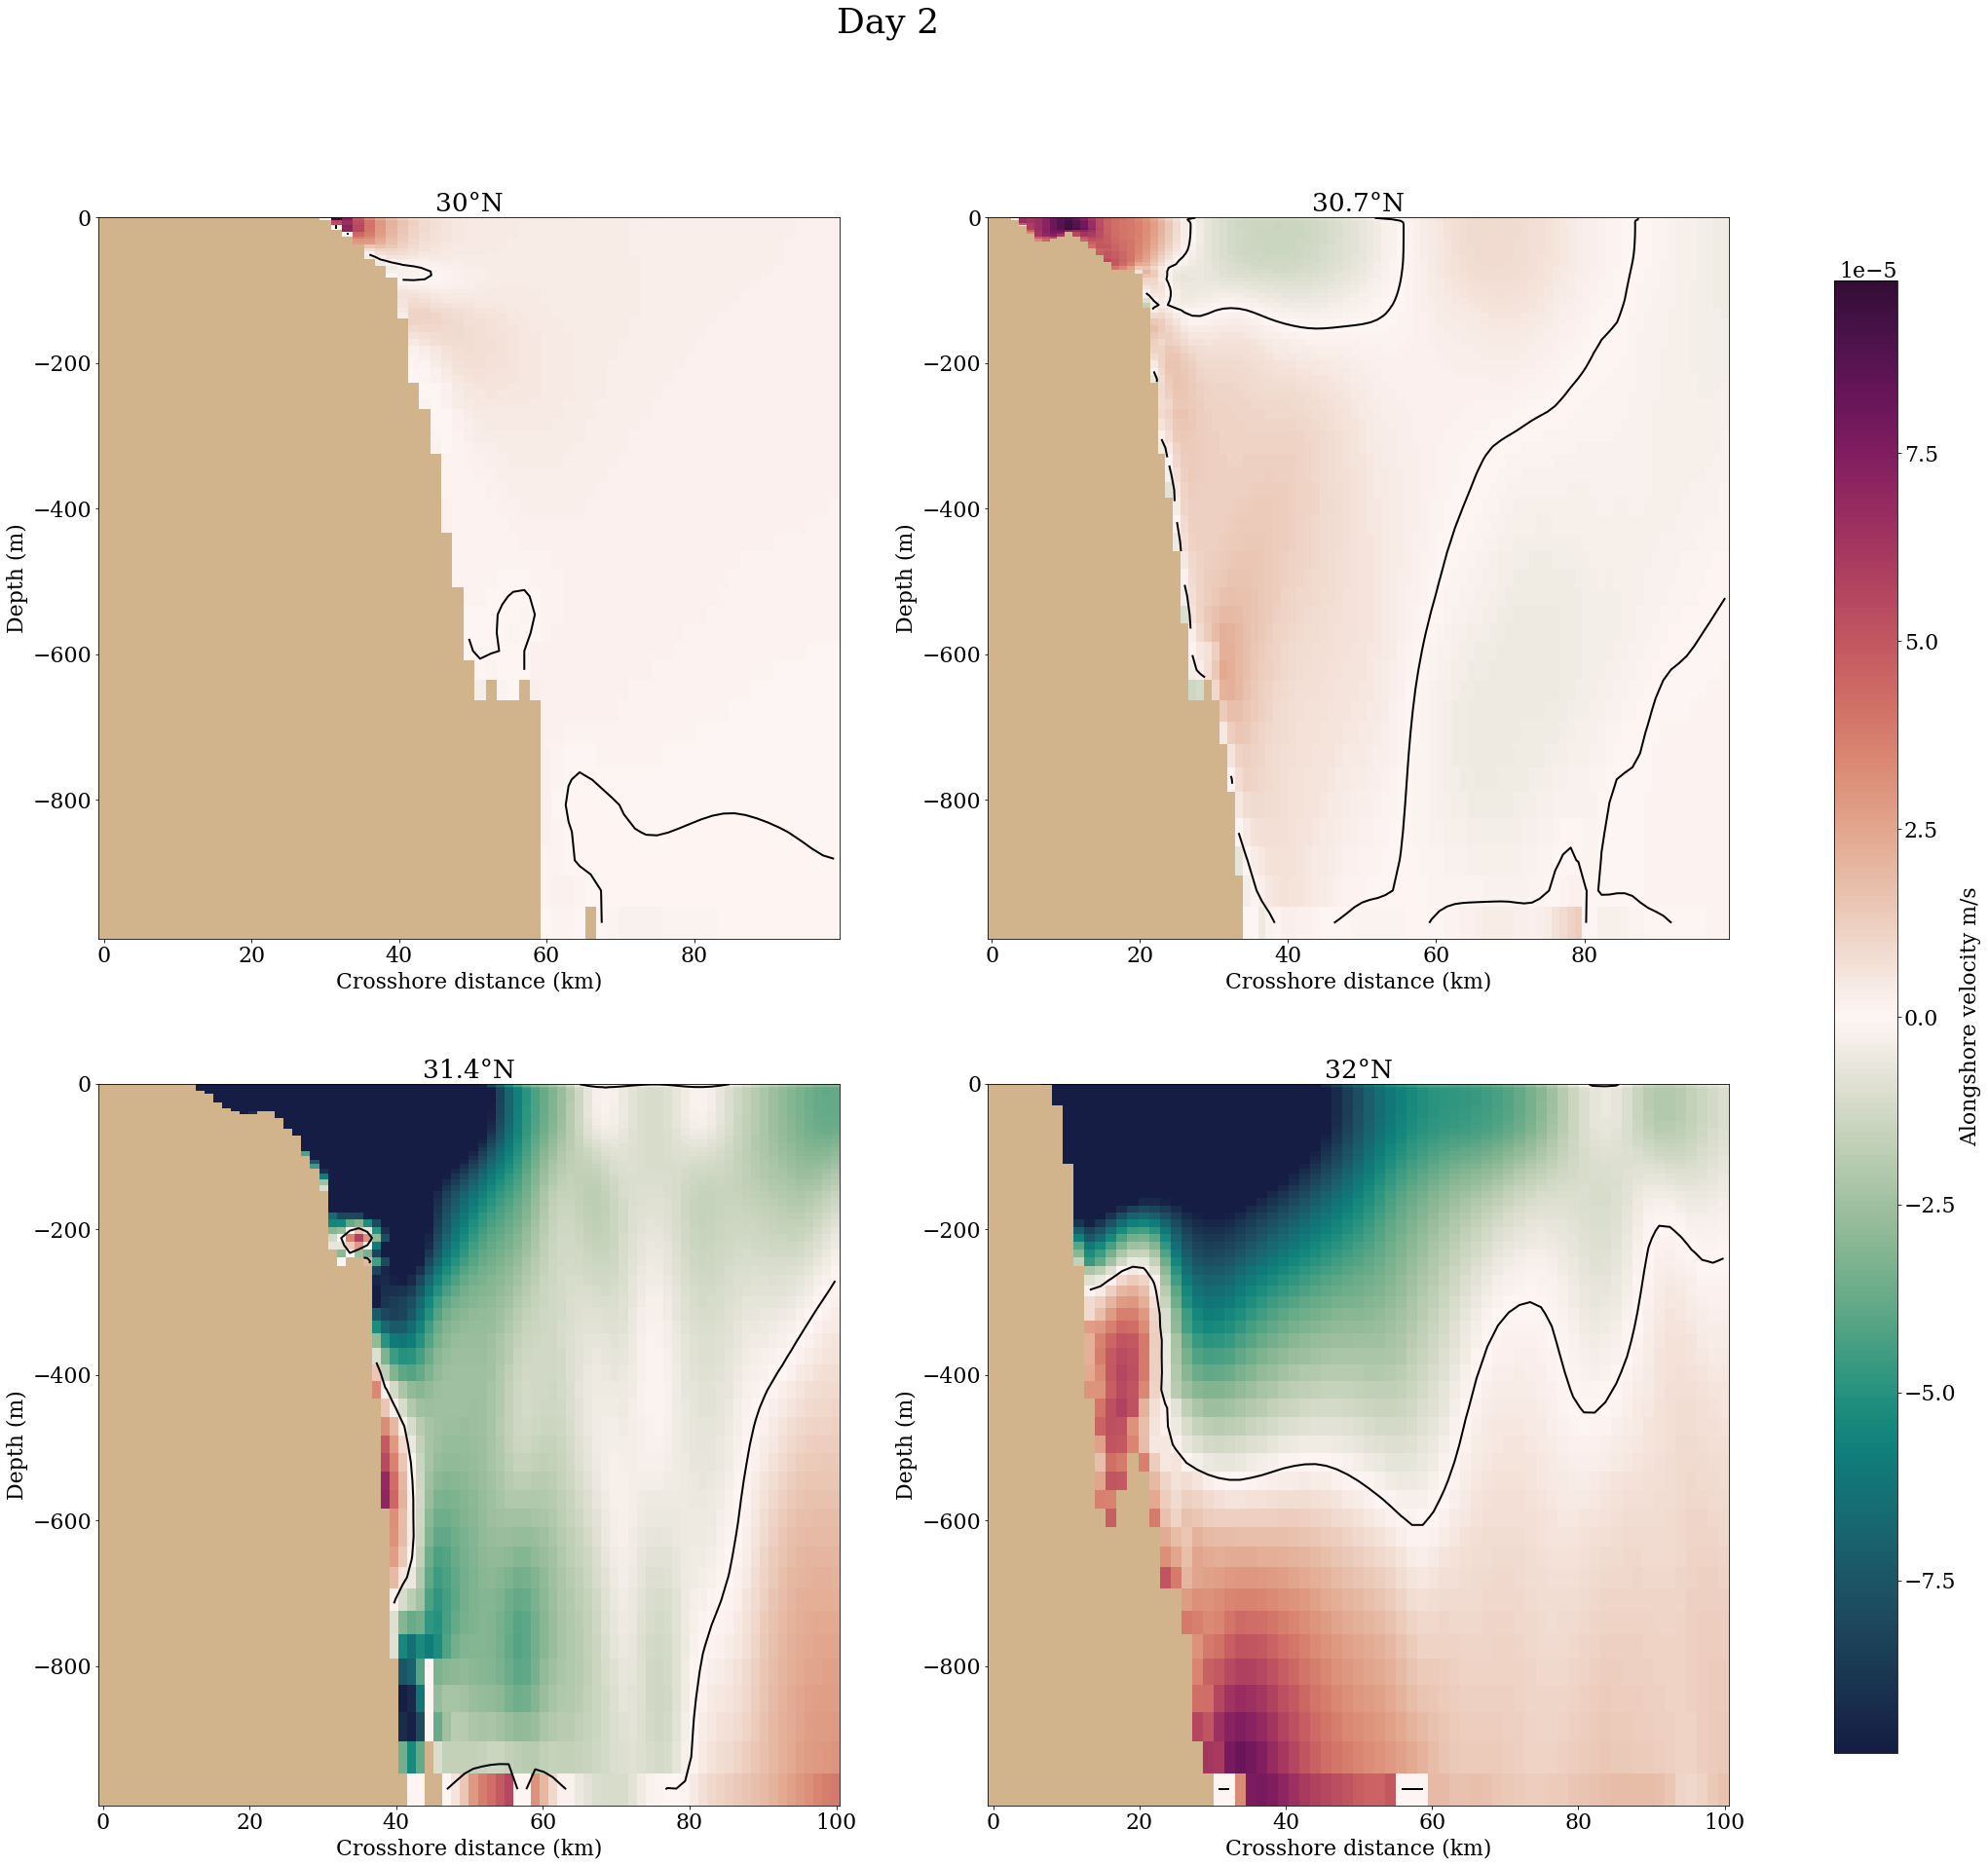

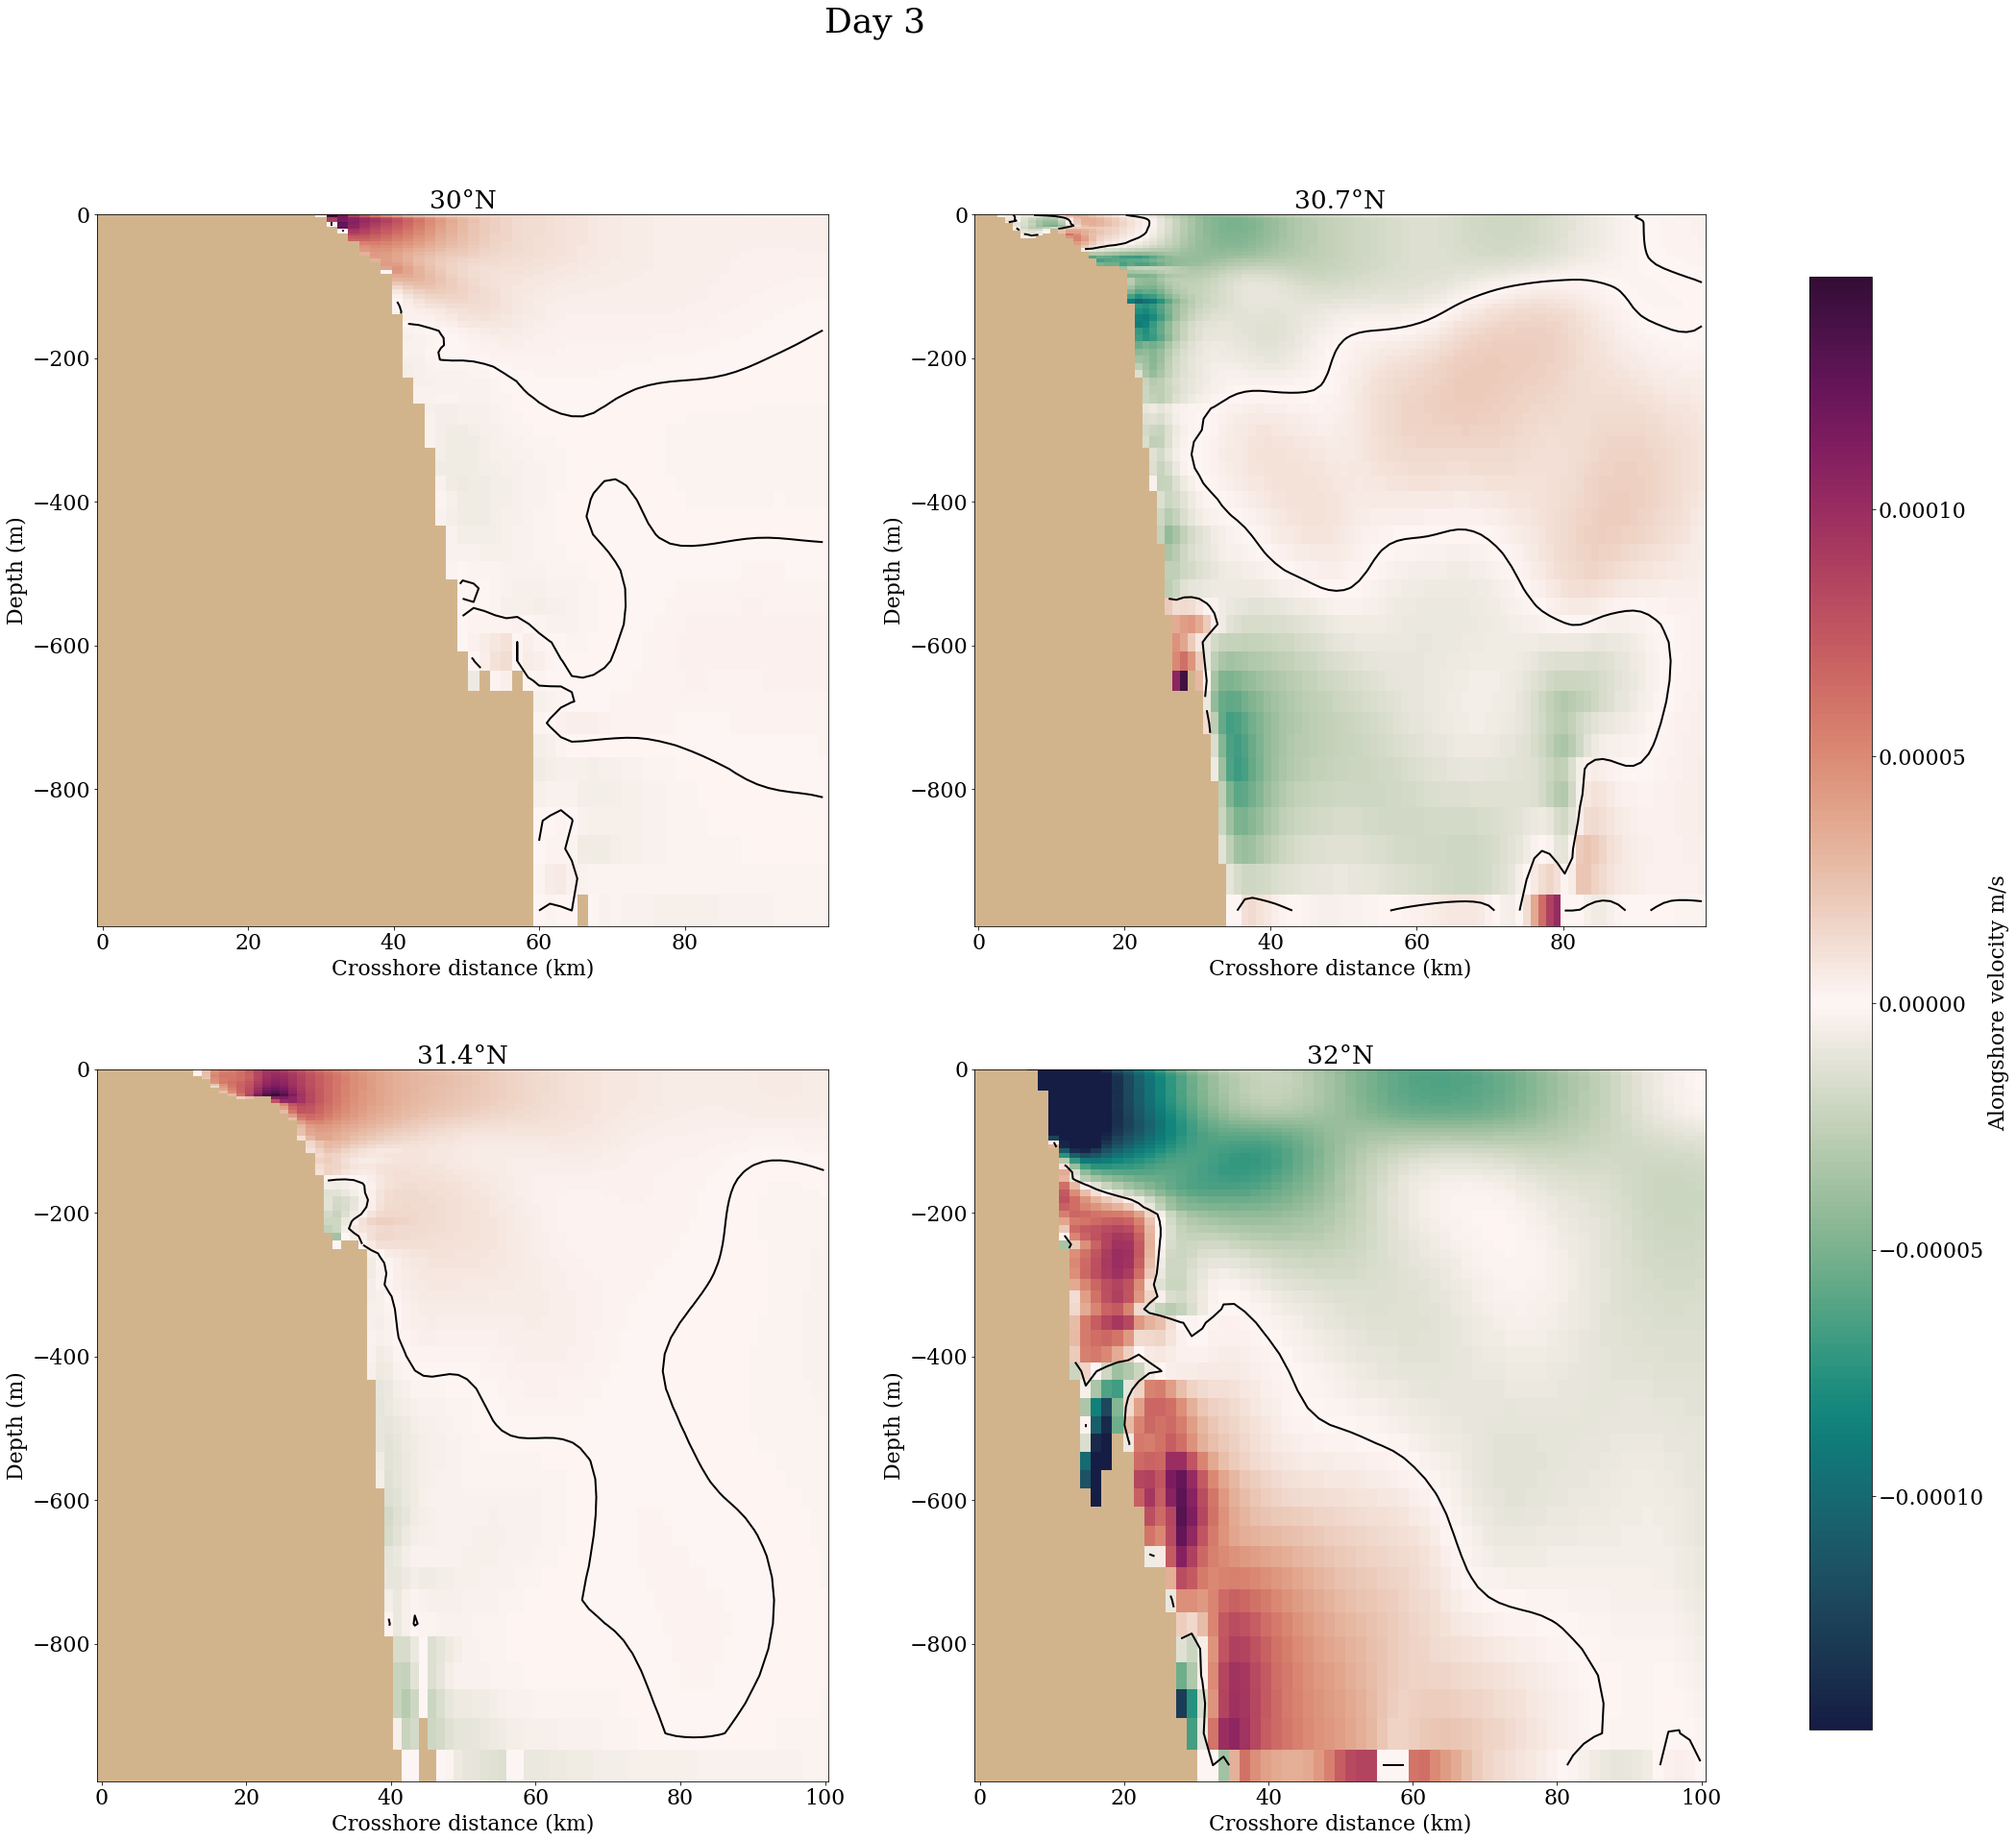

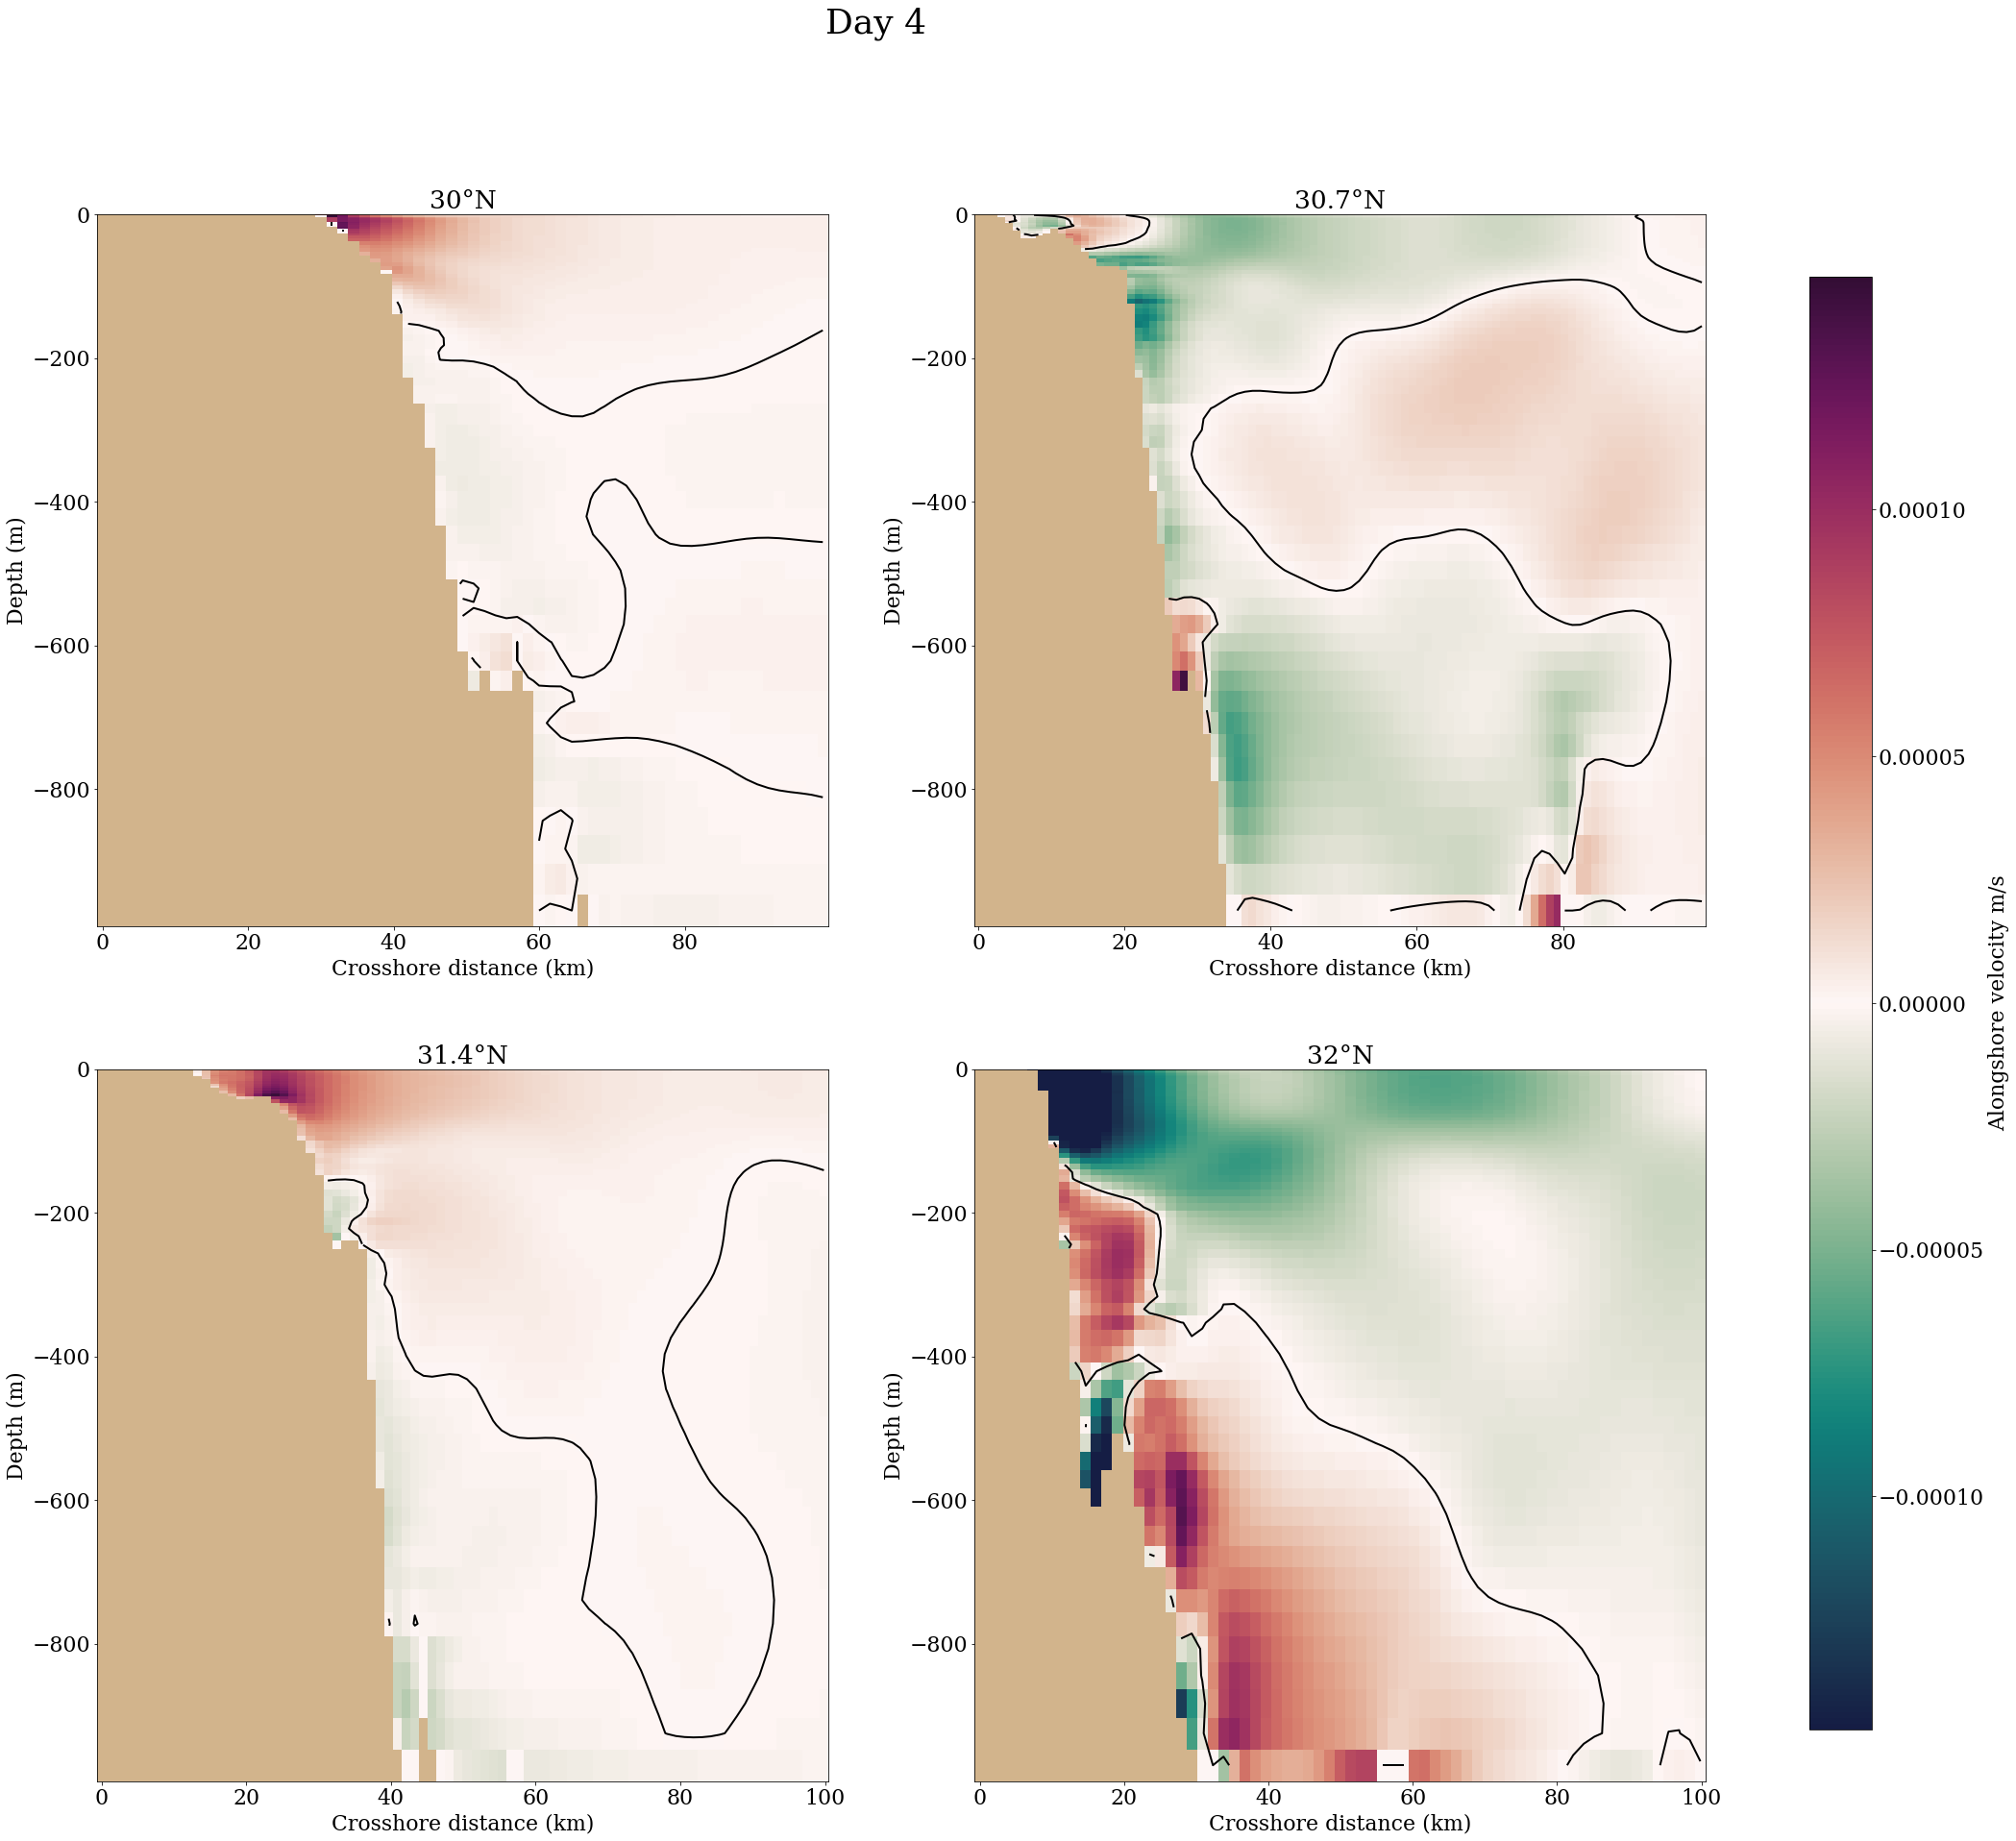

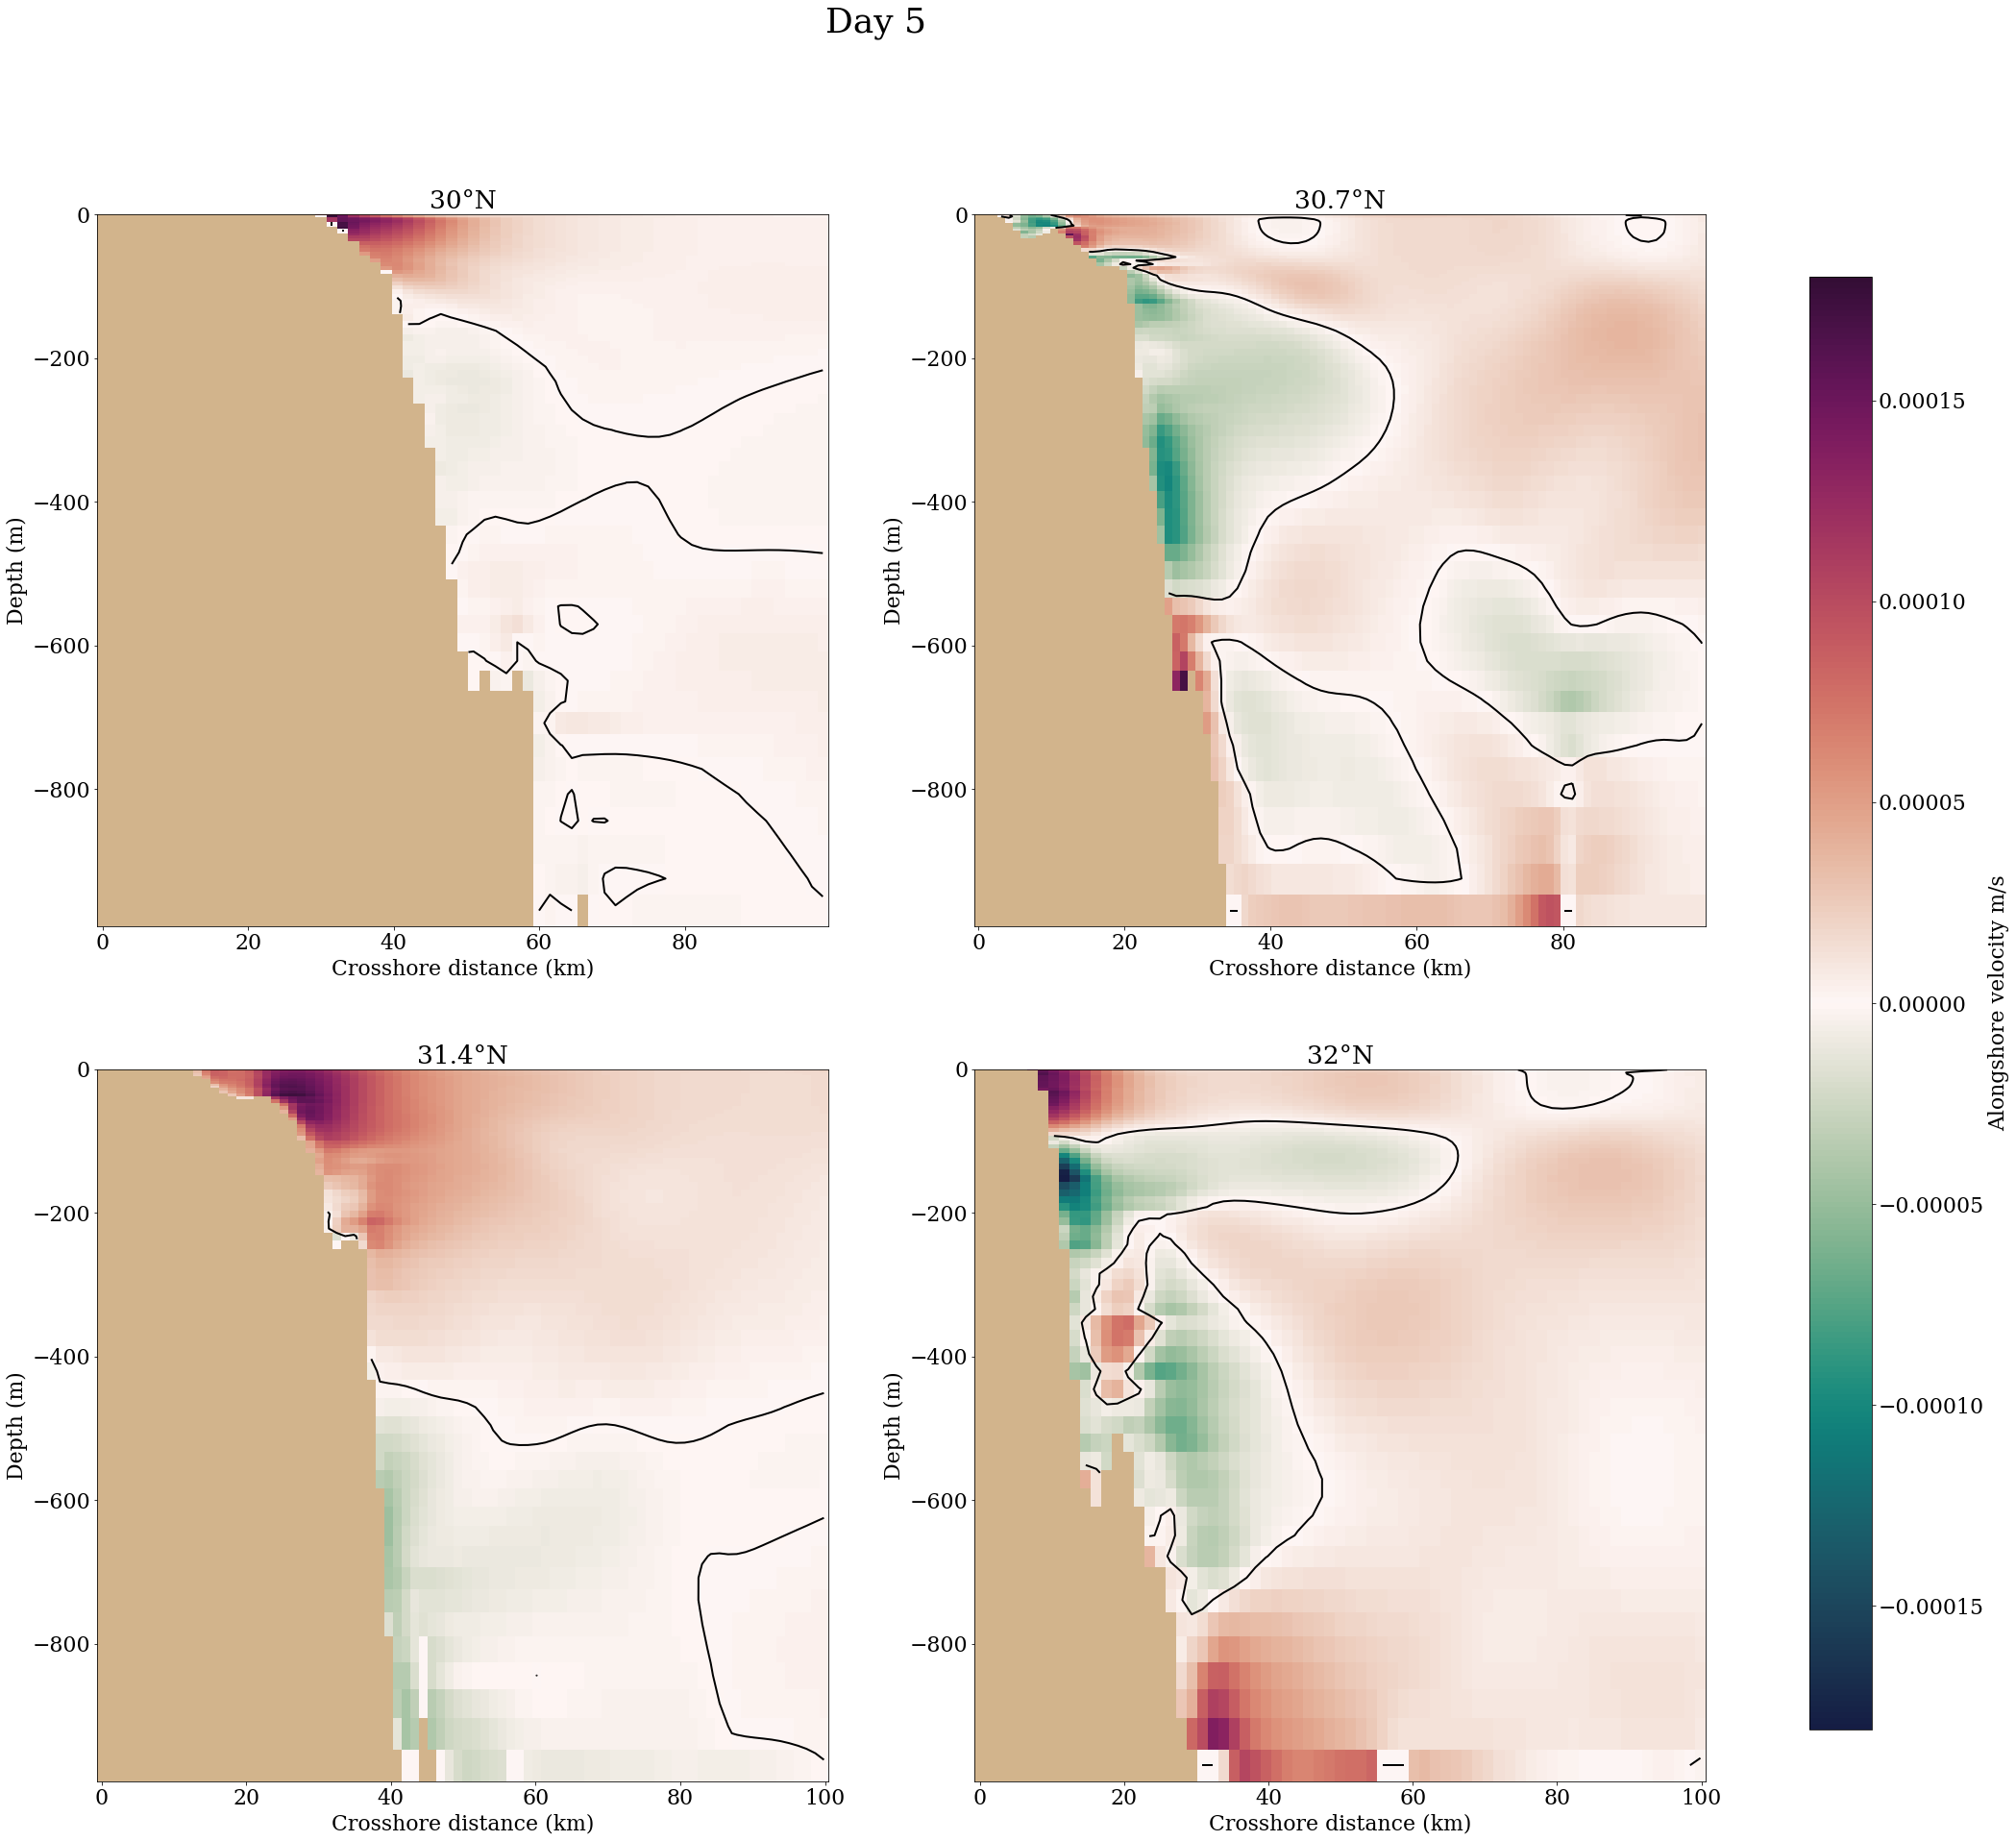

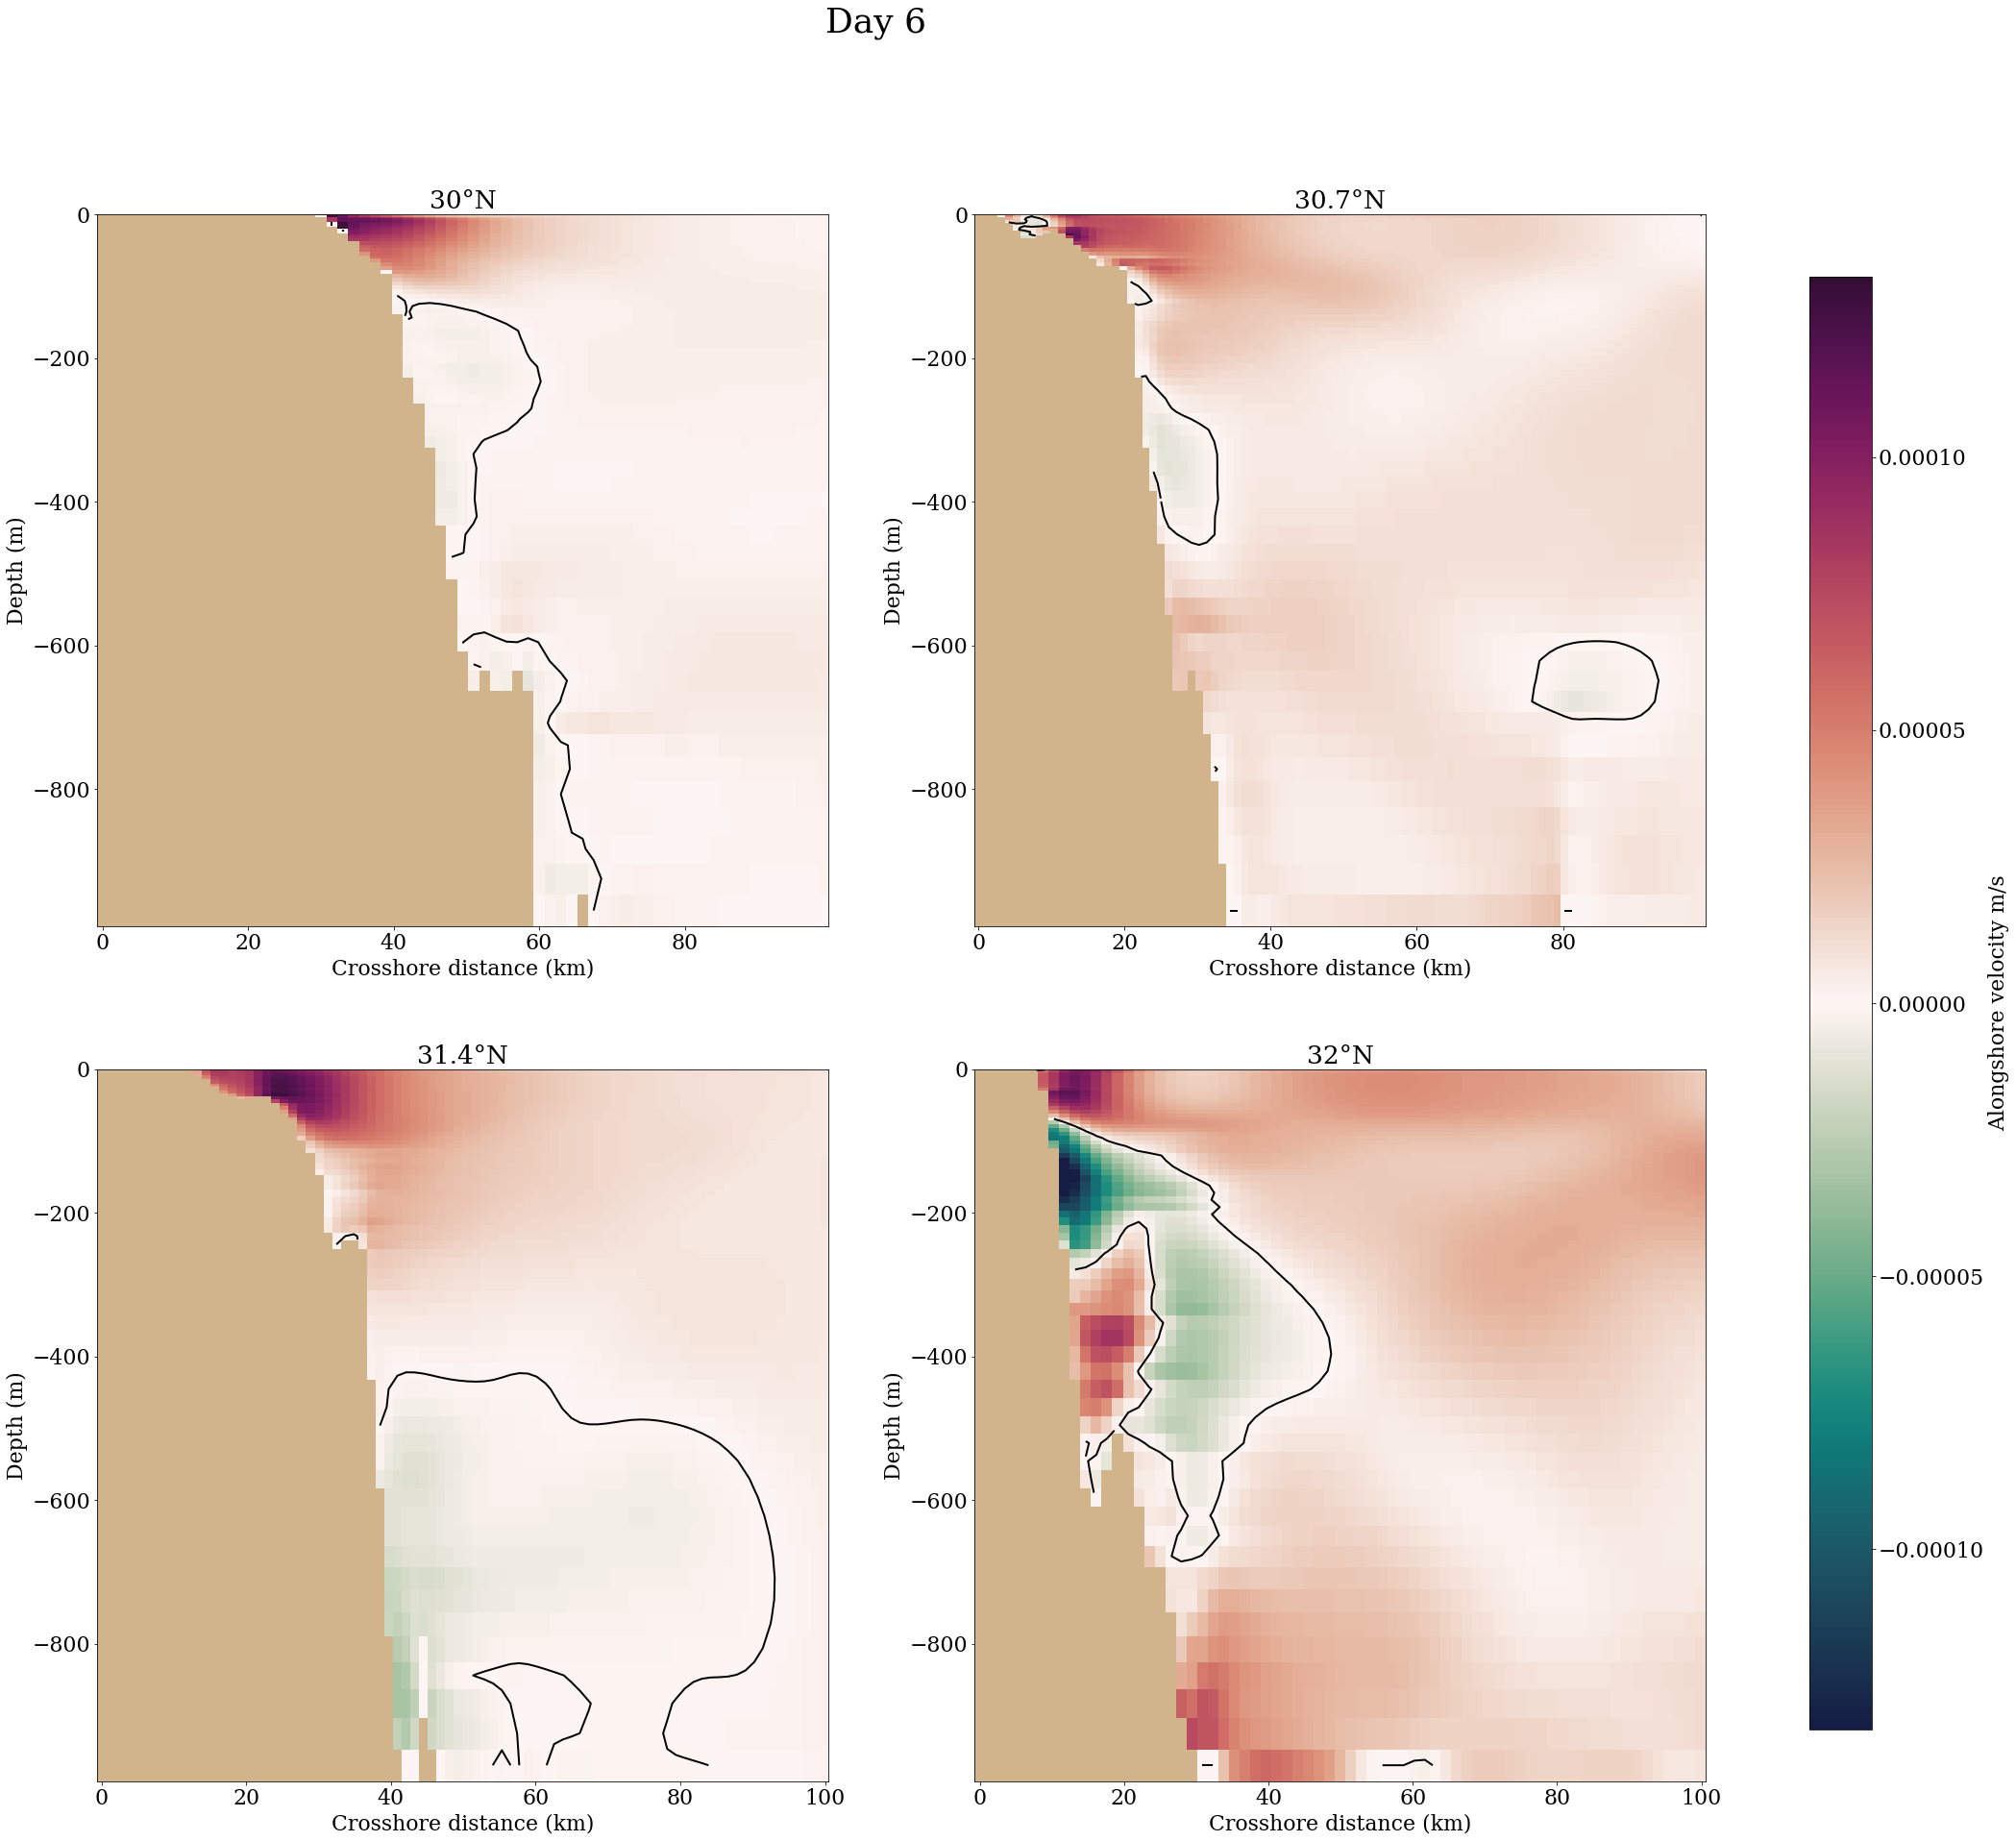

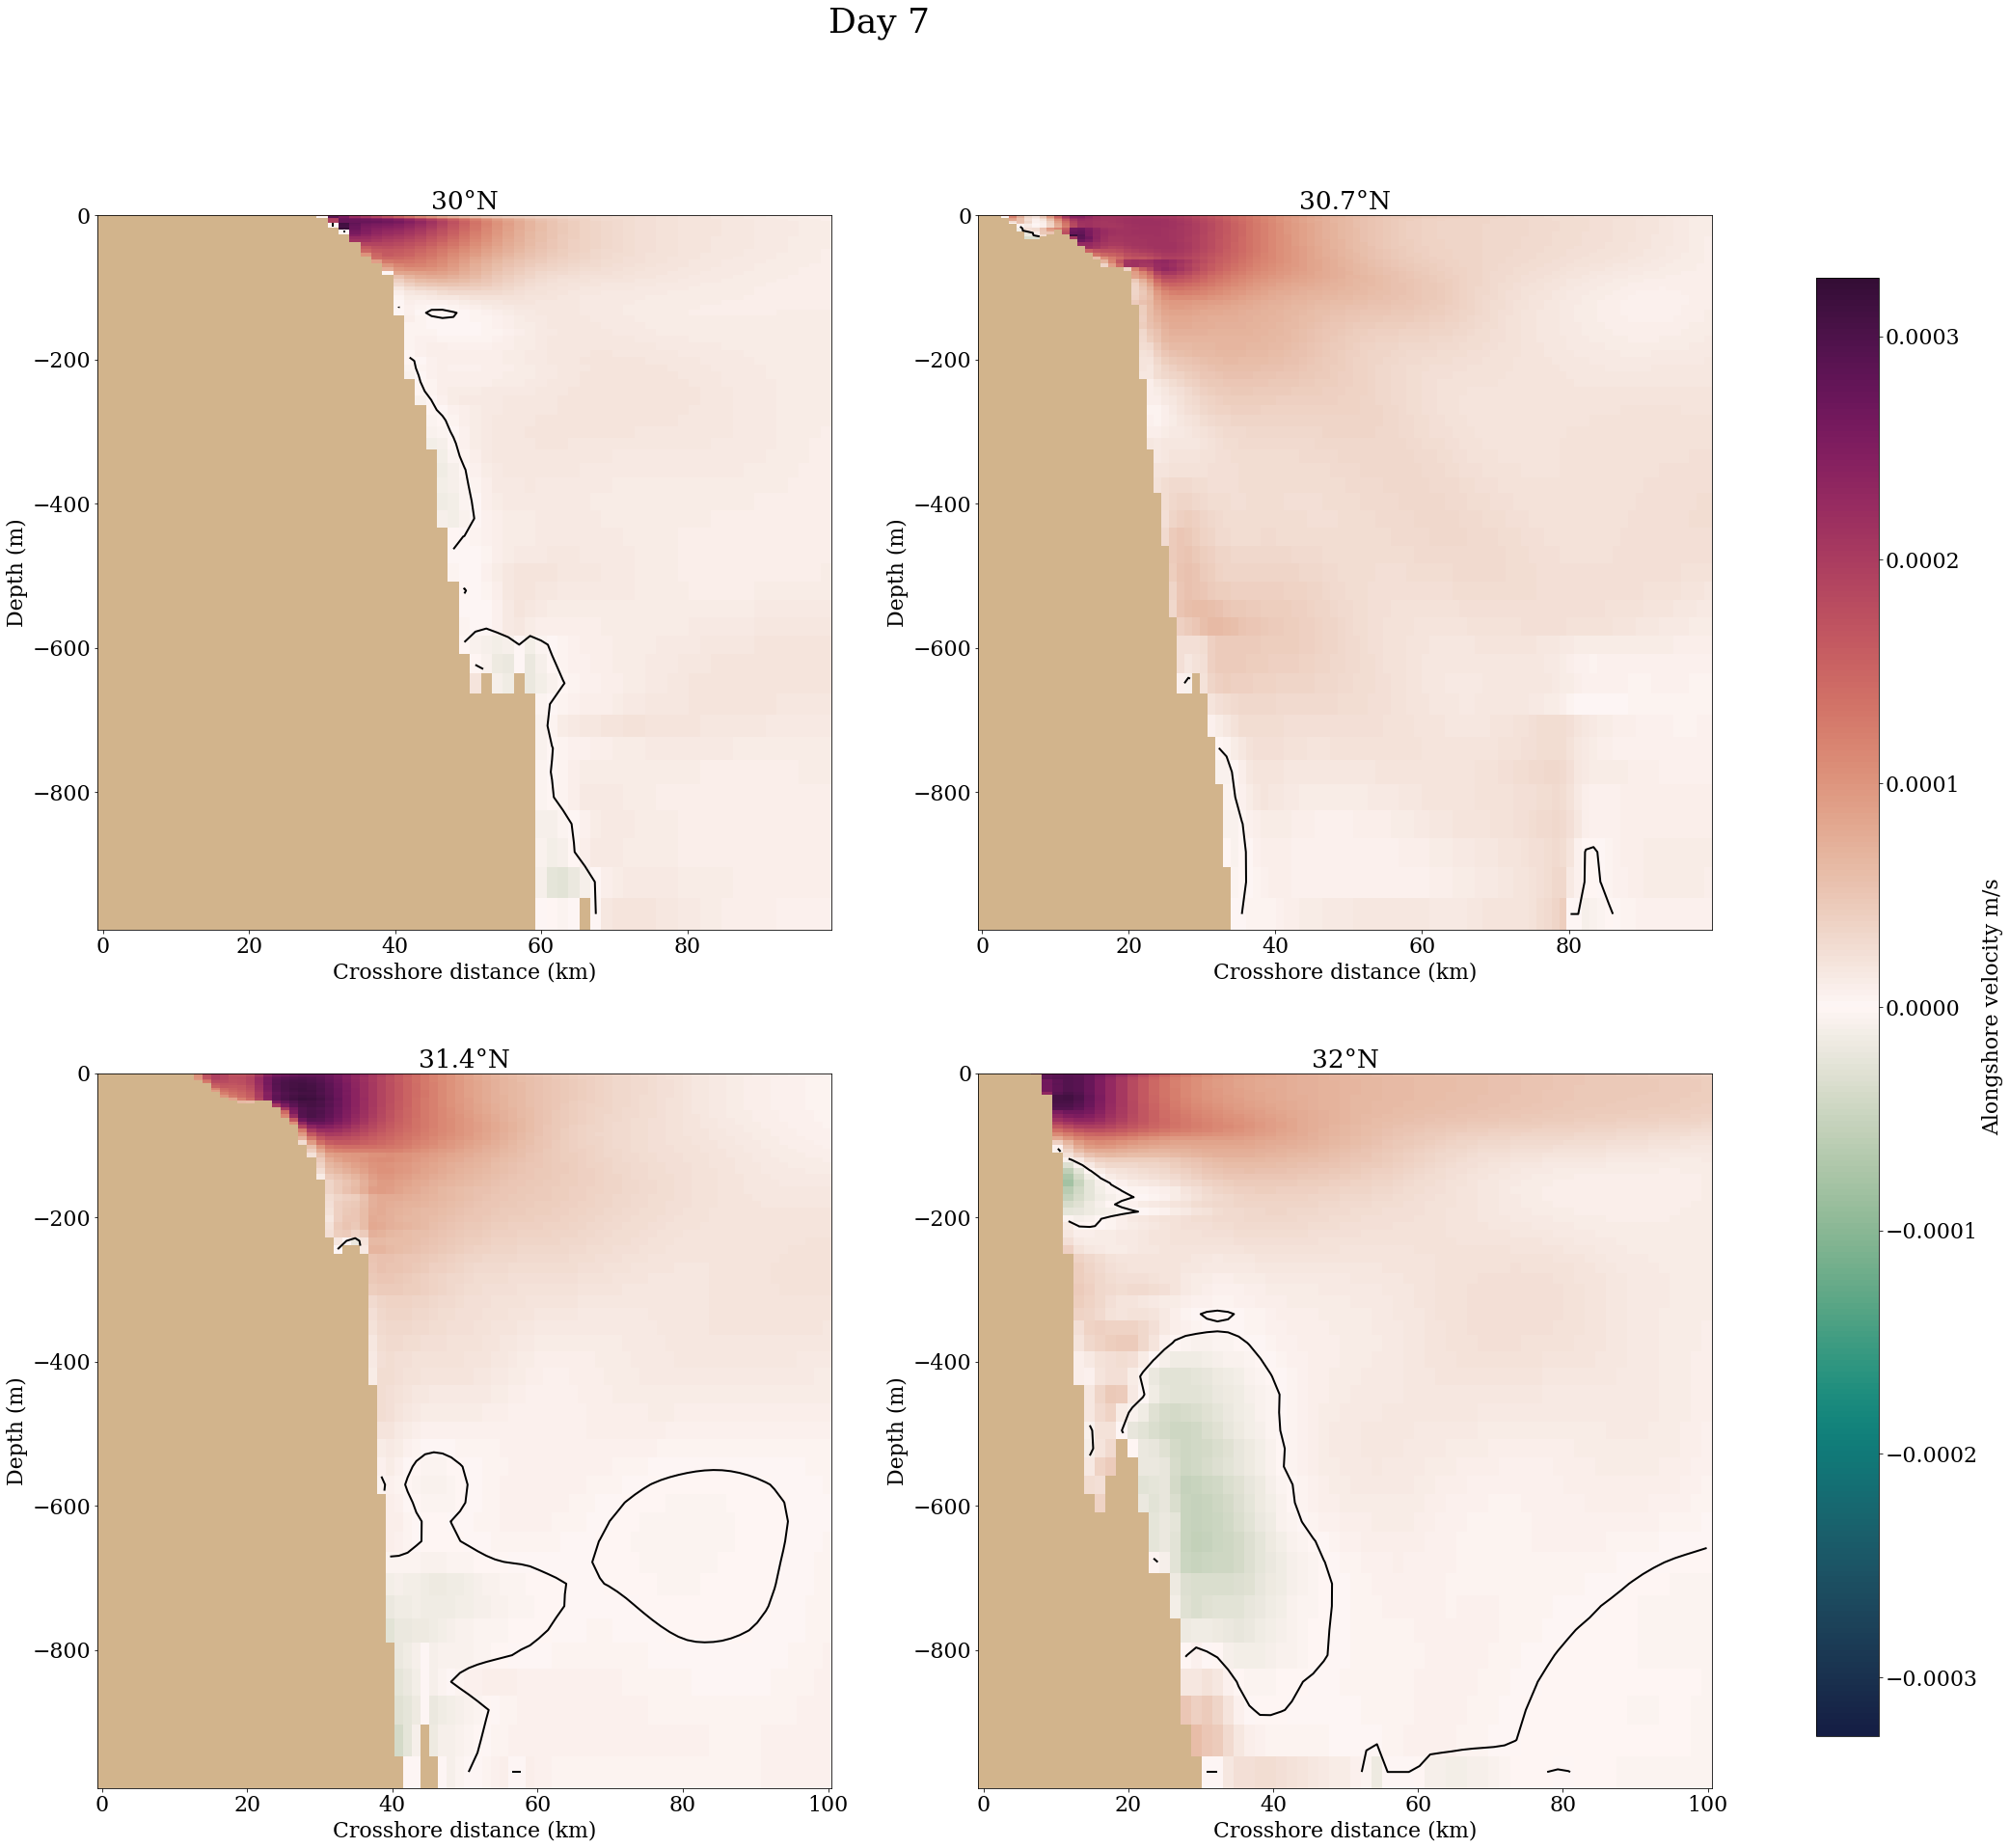

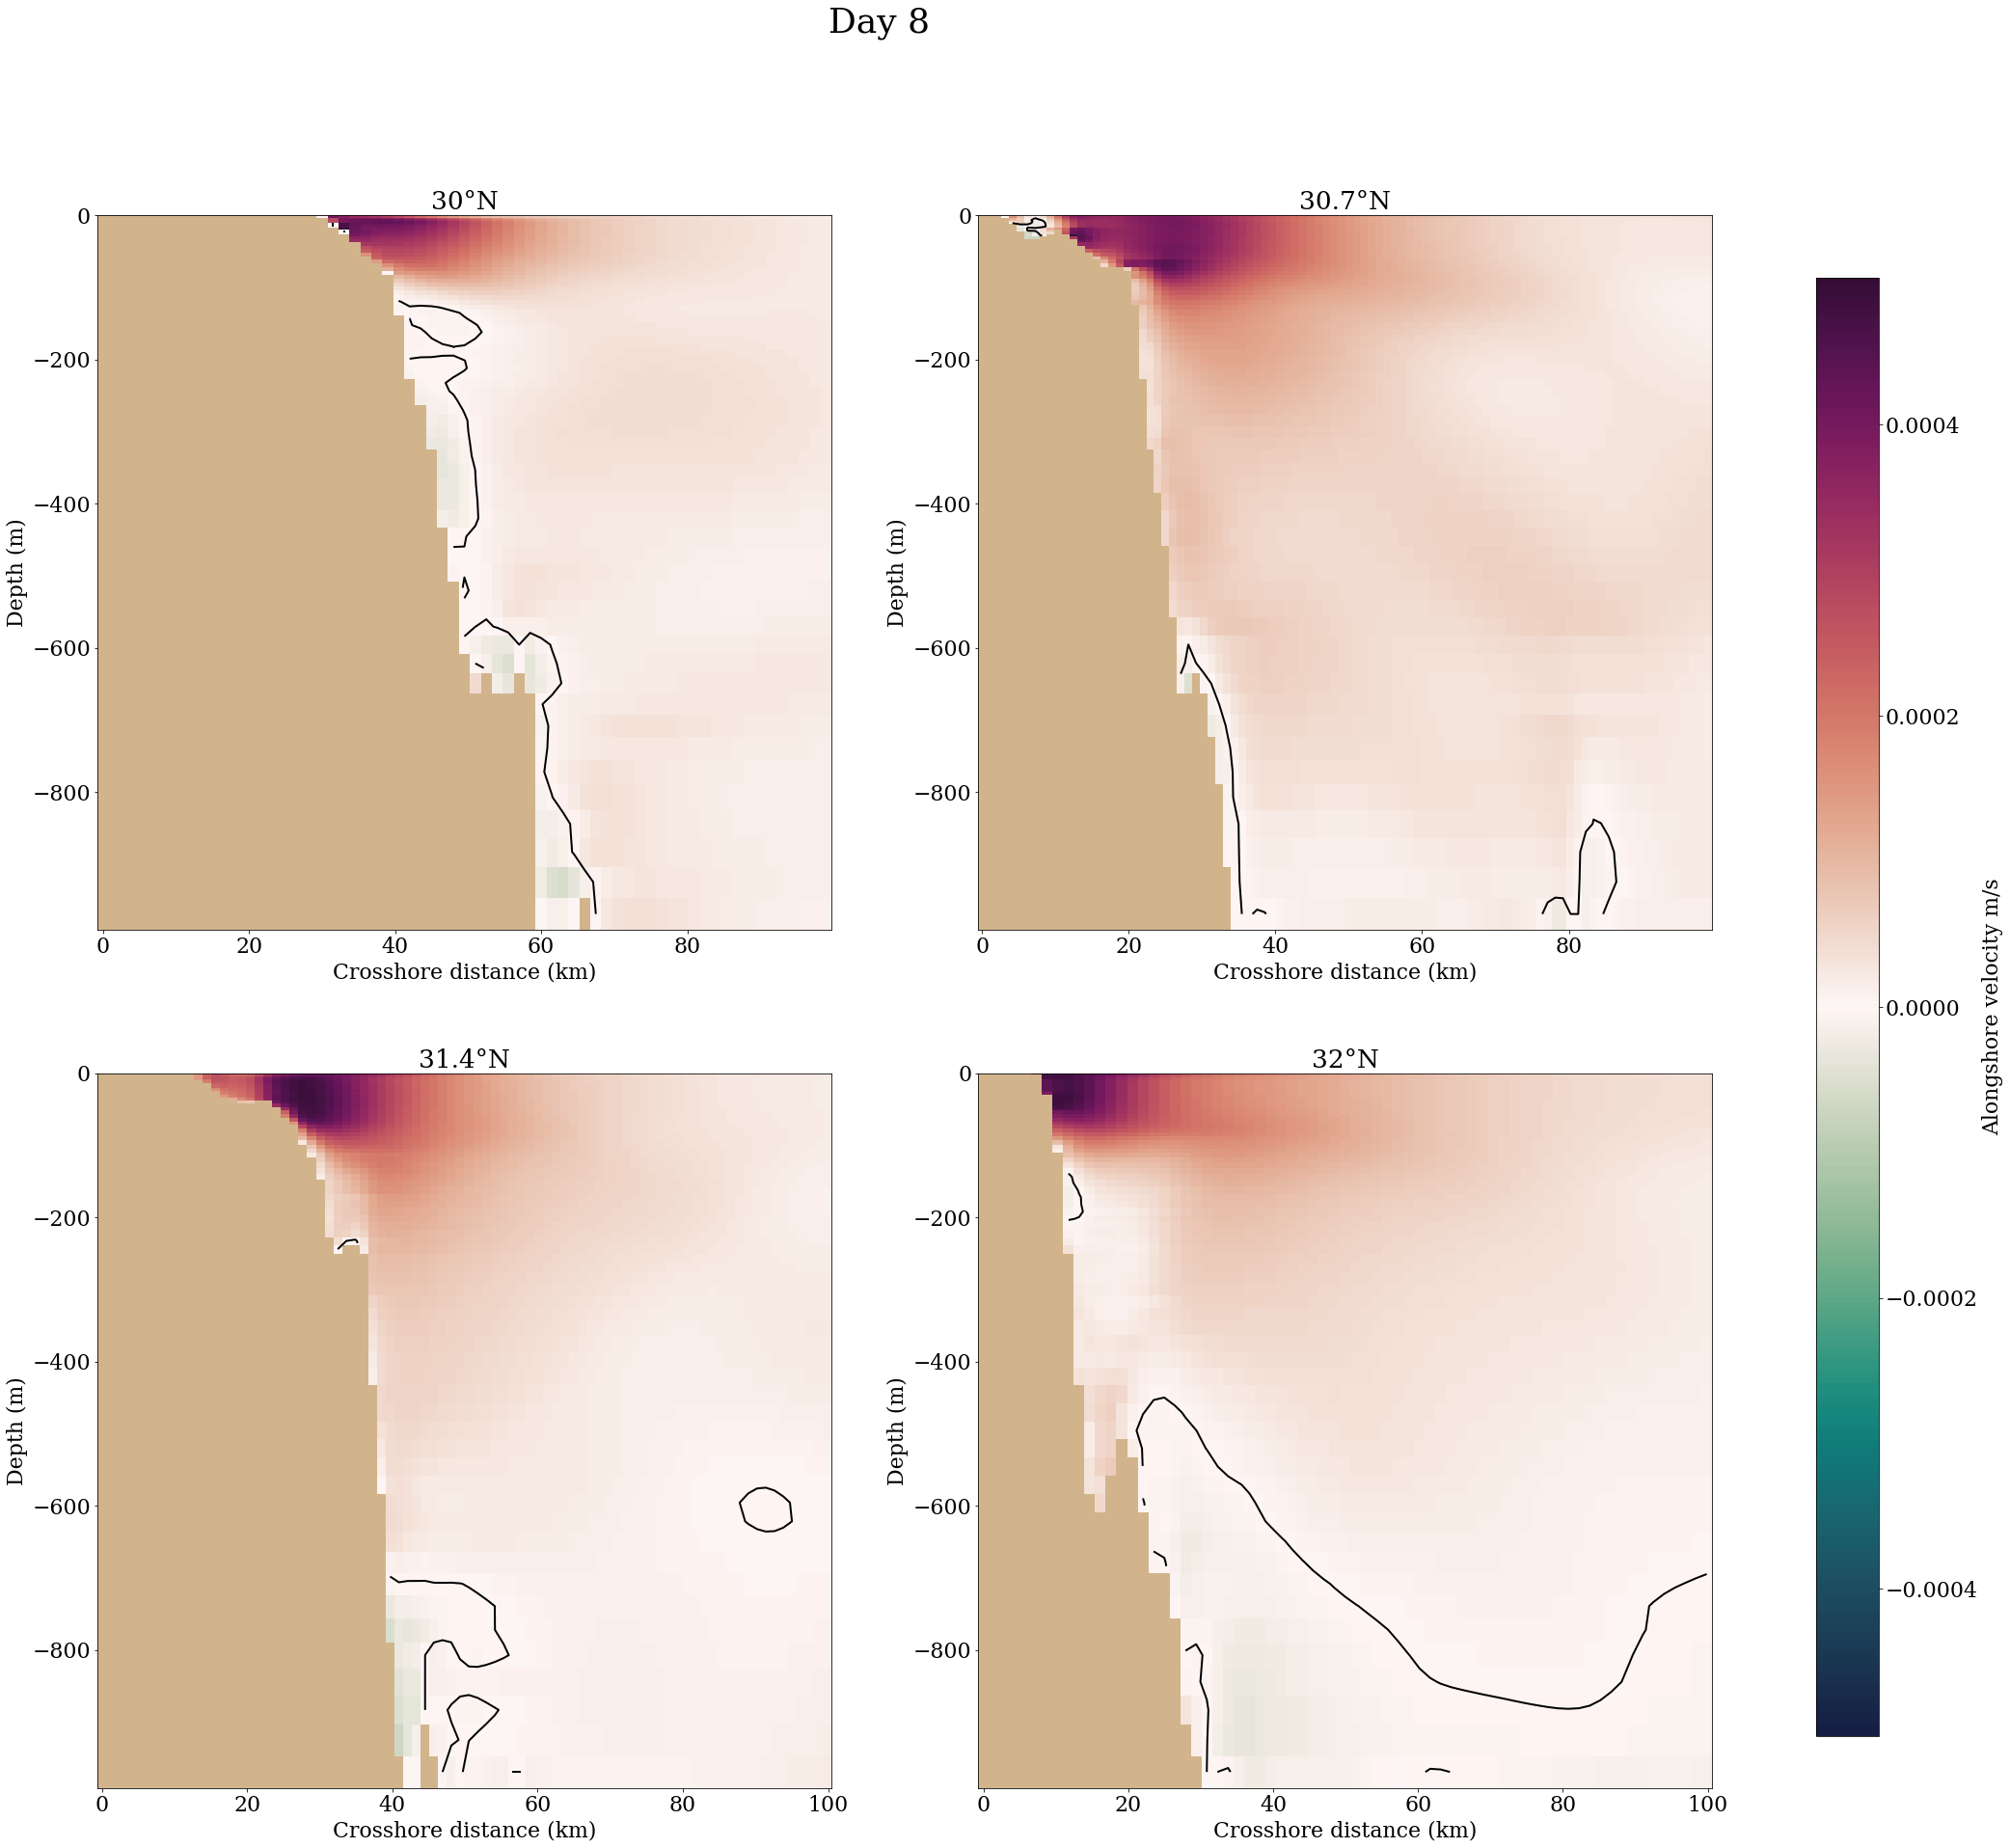

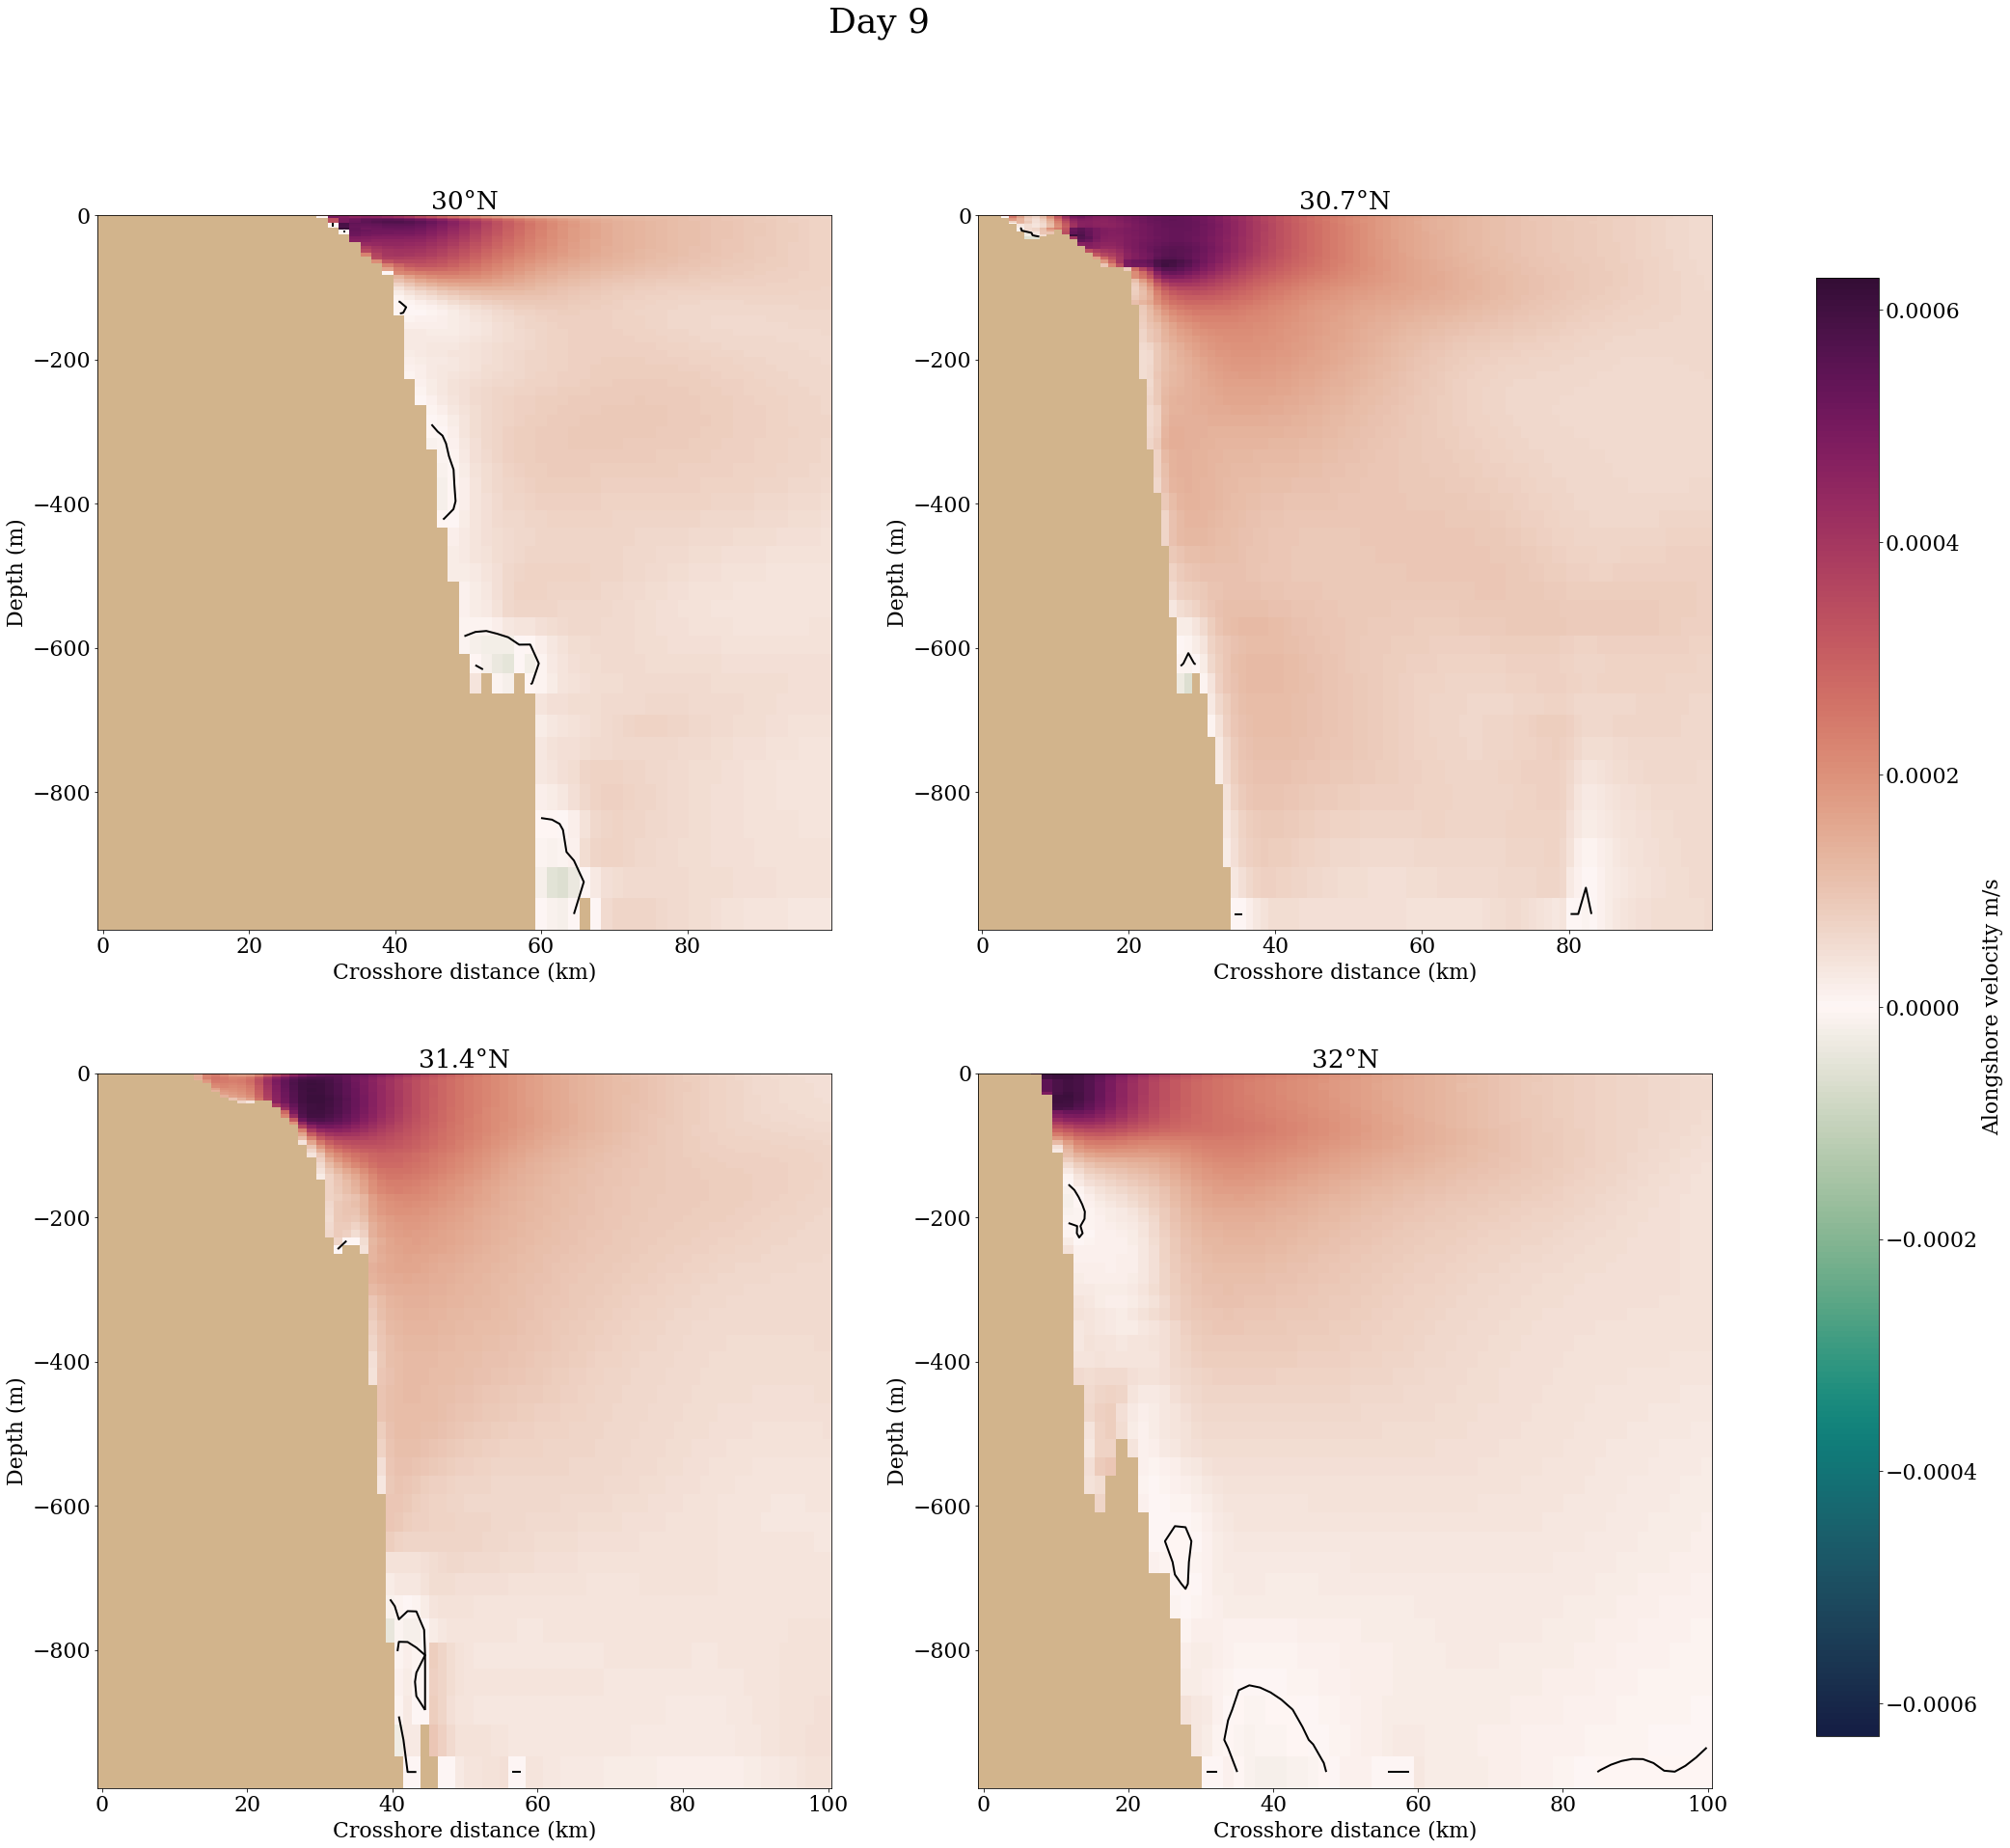

In [20]:
time0=0 #Day 2.5
time1=1 # Day 3.5
time2=2 # Day 5
time3=3 # Day 6
time4=4 #Day 7
time5=5 #Day 8
time6=6 #Day 9
Vel='Alongshore velocity m/s'

fig0, ax = plt.subplots(2,2)
fig0.suptitle('Day 2', fontsize=36)
VALbv=dsw[0].VVEL
VALnv=dsn[0].VVEL
plot_vel(time0,dist30,dist307,dist314,dist32,Z,VALbv,VALnv,Vel,fig0,ax)

fig1, ax = plt.subplots(2,2)
fig1.suptitle('Day 3', fontsize=36)
VALbv=dsw[2].VVEL
VALnv=dsn[2].VVEL
plot_vel(time1,dist30,dist307,dist314,dist32,Z,VALbv,VALnv,Vel,fig1,ax)

fig2, ax = plt.subplots(2,2)
fig2.suptitle('Day 4', fontsize=36)
VALbv=dsw[2].VVEL
VALnv=dsn[2].VVEL
plot_vel(time1,dist30,dist307,dist314,dist32,Z,VALbv,VALnv,Vel,fig2,ax)

fig3, ax = plt.subplots(2,2)
fig3.suptitle('Day 5', fontsize=36)
VALbv=dsw[3].VVEL
VALnv=dsn[3].VVEL
plot_vel(time2,dist30,dist307,dist314,dist32,Z,VALbv,VALnv,Vel,fig3,ax)

fig4, ax = plt.subplots(2,2)
fig4.suptitle('Day 6', fontsize=36)
VALbv=dsw[4].VVEL
VALnv=dsn[4].VVEL
plot_vel(time3,dist30,dist307,dist314,dist32,Z,VALbv,VALnv,Vel,fig4,ax)

fig5, ax = plt.subplots(2,2)
fig5.suptitle('Day 7', fontsize=36)
VALbv=dsw[5].VVEL
VALnv=dsn[5].VVEL
plot_vel(time4,dist30,dist307,dist314,dist32,Z,VALbv,VALnv,Vel,fig5,ax)

fig6, ax = plt.subplots(2,2)
fig6.suptitle('Day 8', fontsize=36)
VALbv=dsw[6].VVEL
VALnv=dsn[6].VVEL
plot_vel(time5,dist30,dist307,dist314,dist32,Z,VALbv,VALnv,Vel,fig6,ax)

fig7, ax = plt.subplots(2,2)
fig7.suptitle('Day 9', fontsize=36)
VALbv=dsw[7].VVEL
VALnv=dsn[7].VVEL
plot_vel(time6,dist30,dist307,dist314,dist32,Z,VALbv,VALnv,Vel,fig7,ax)

#### Crossshore velocity

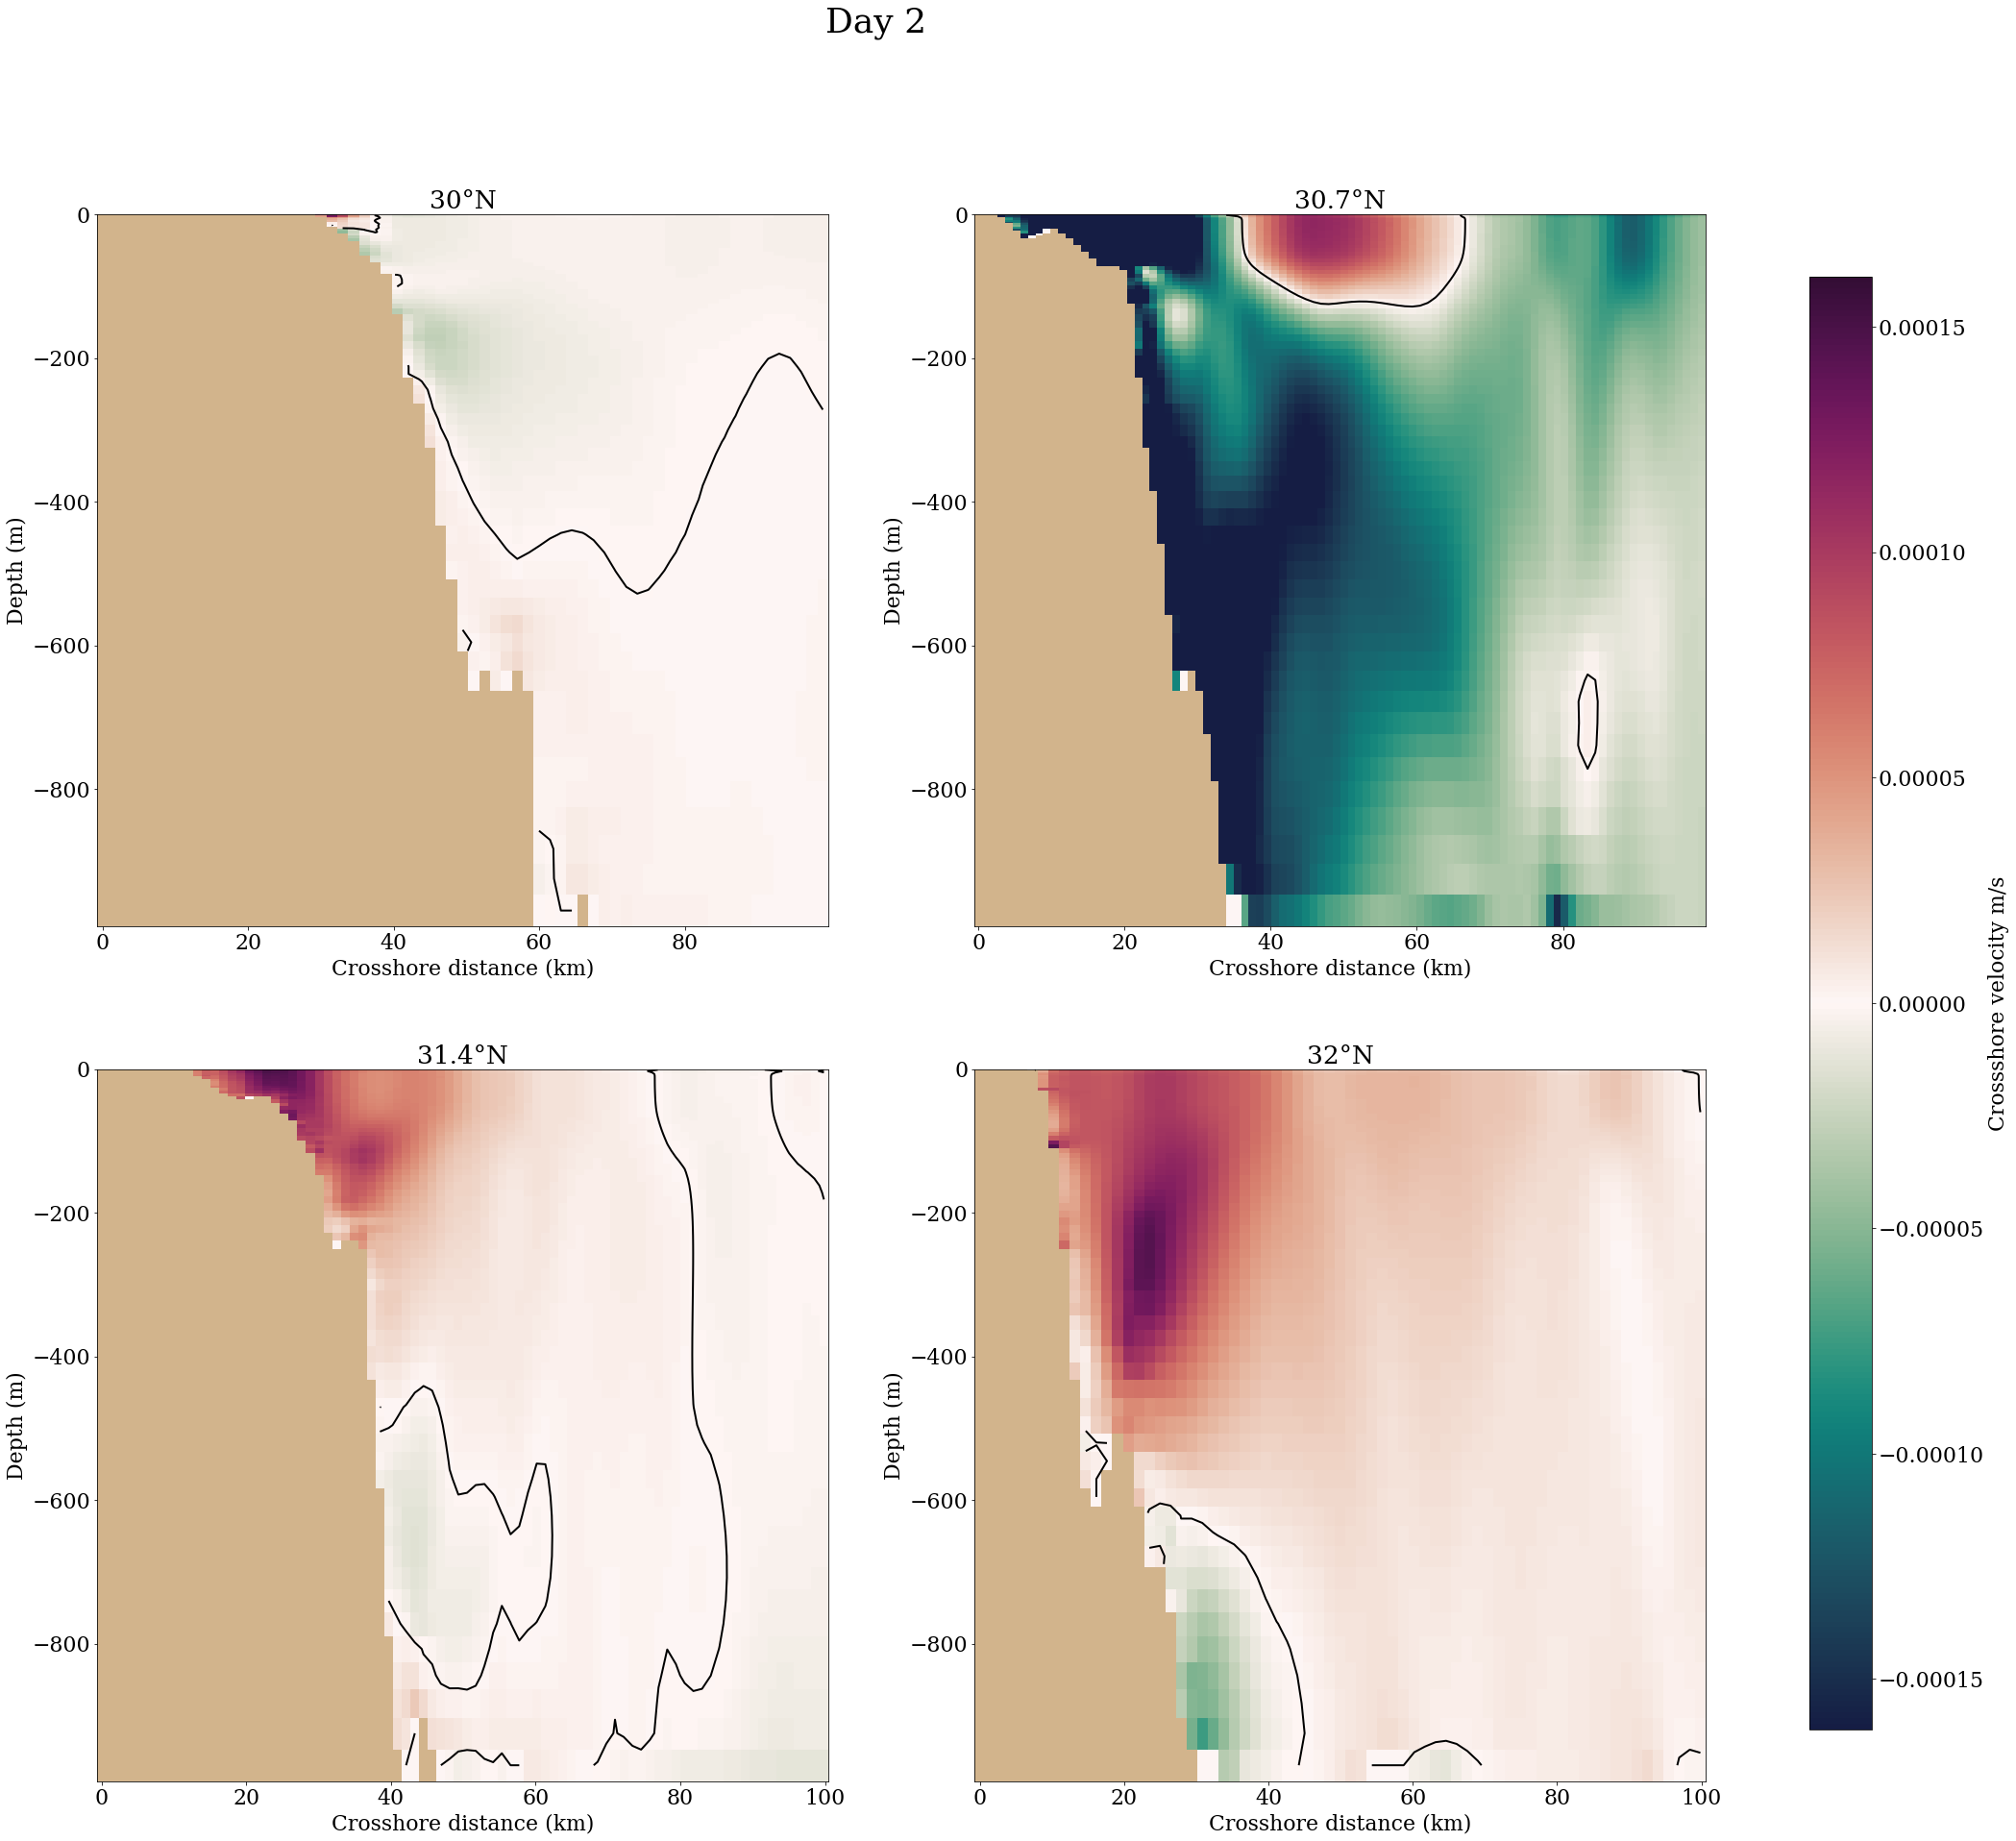

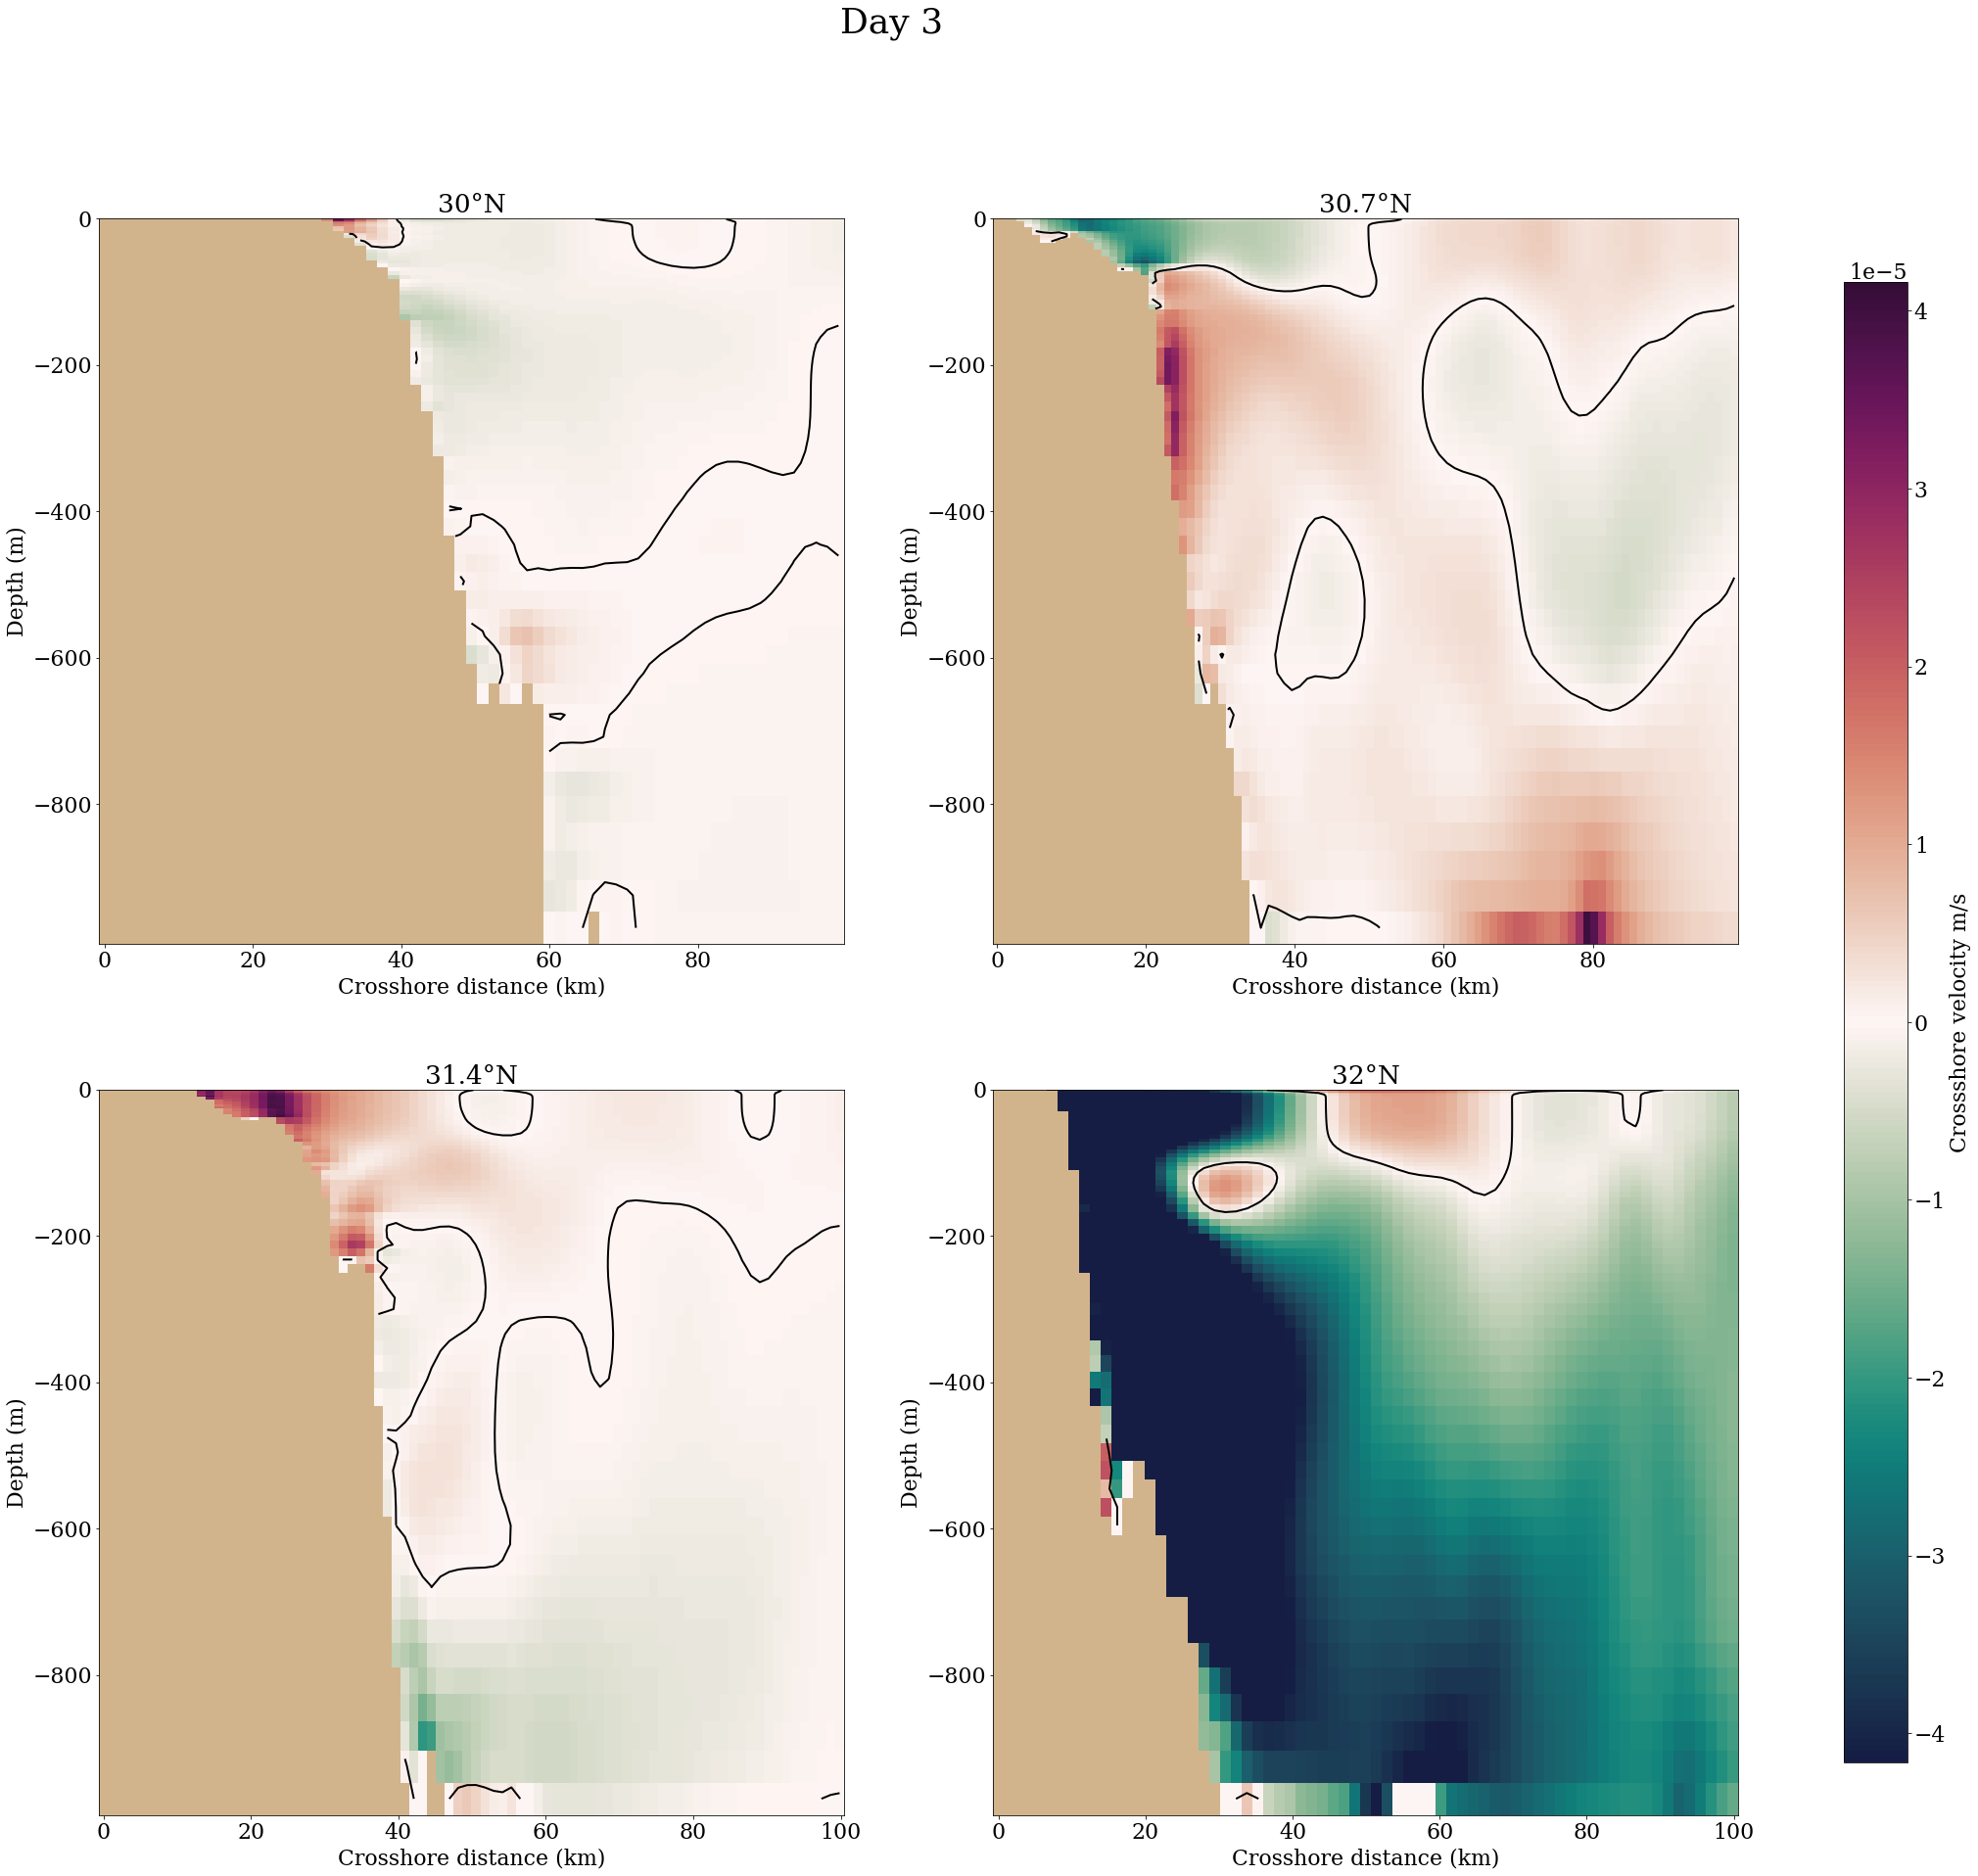

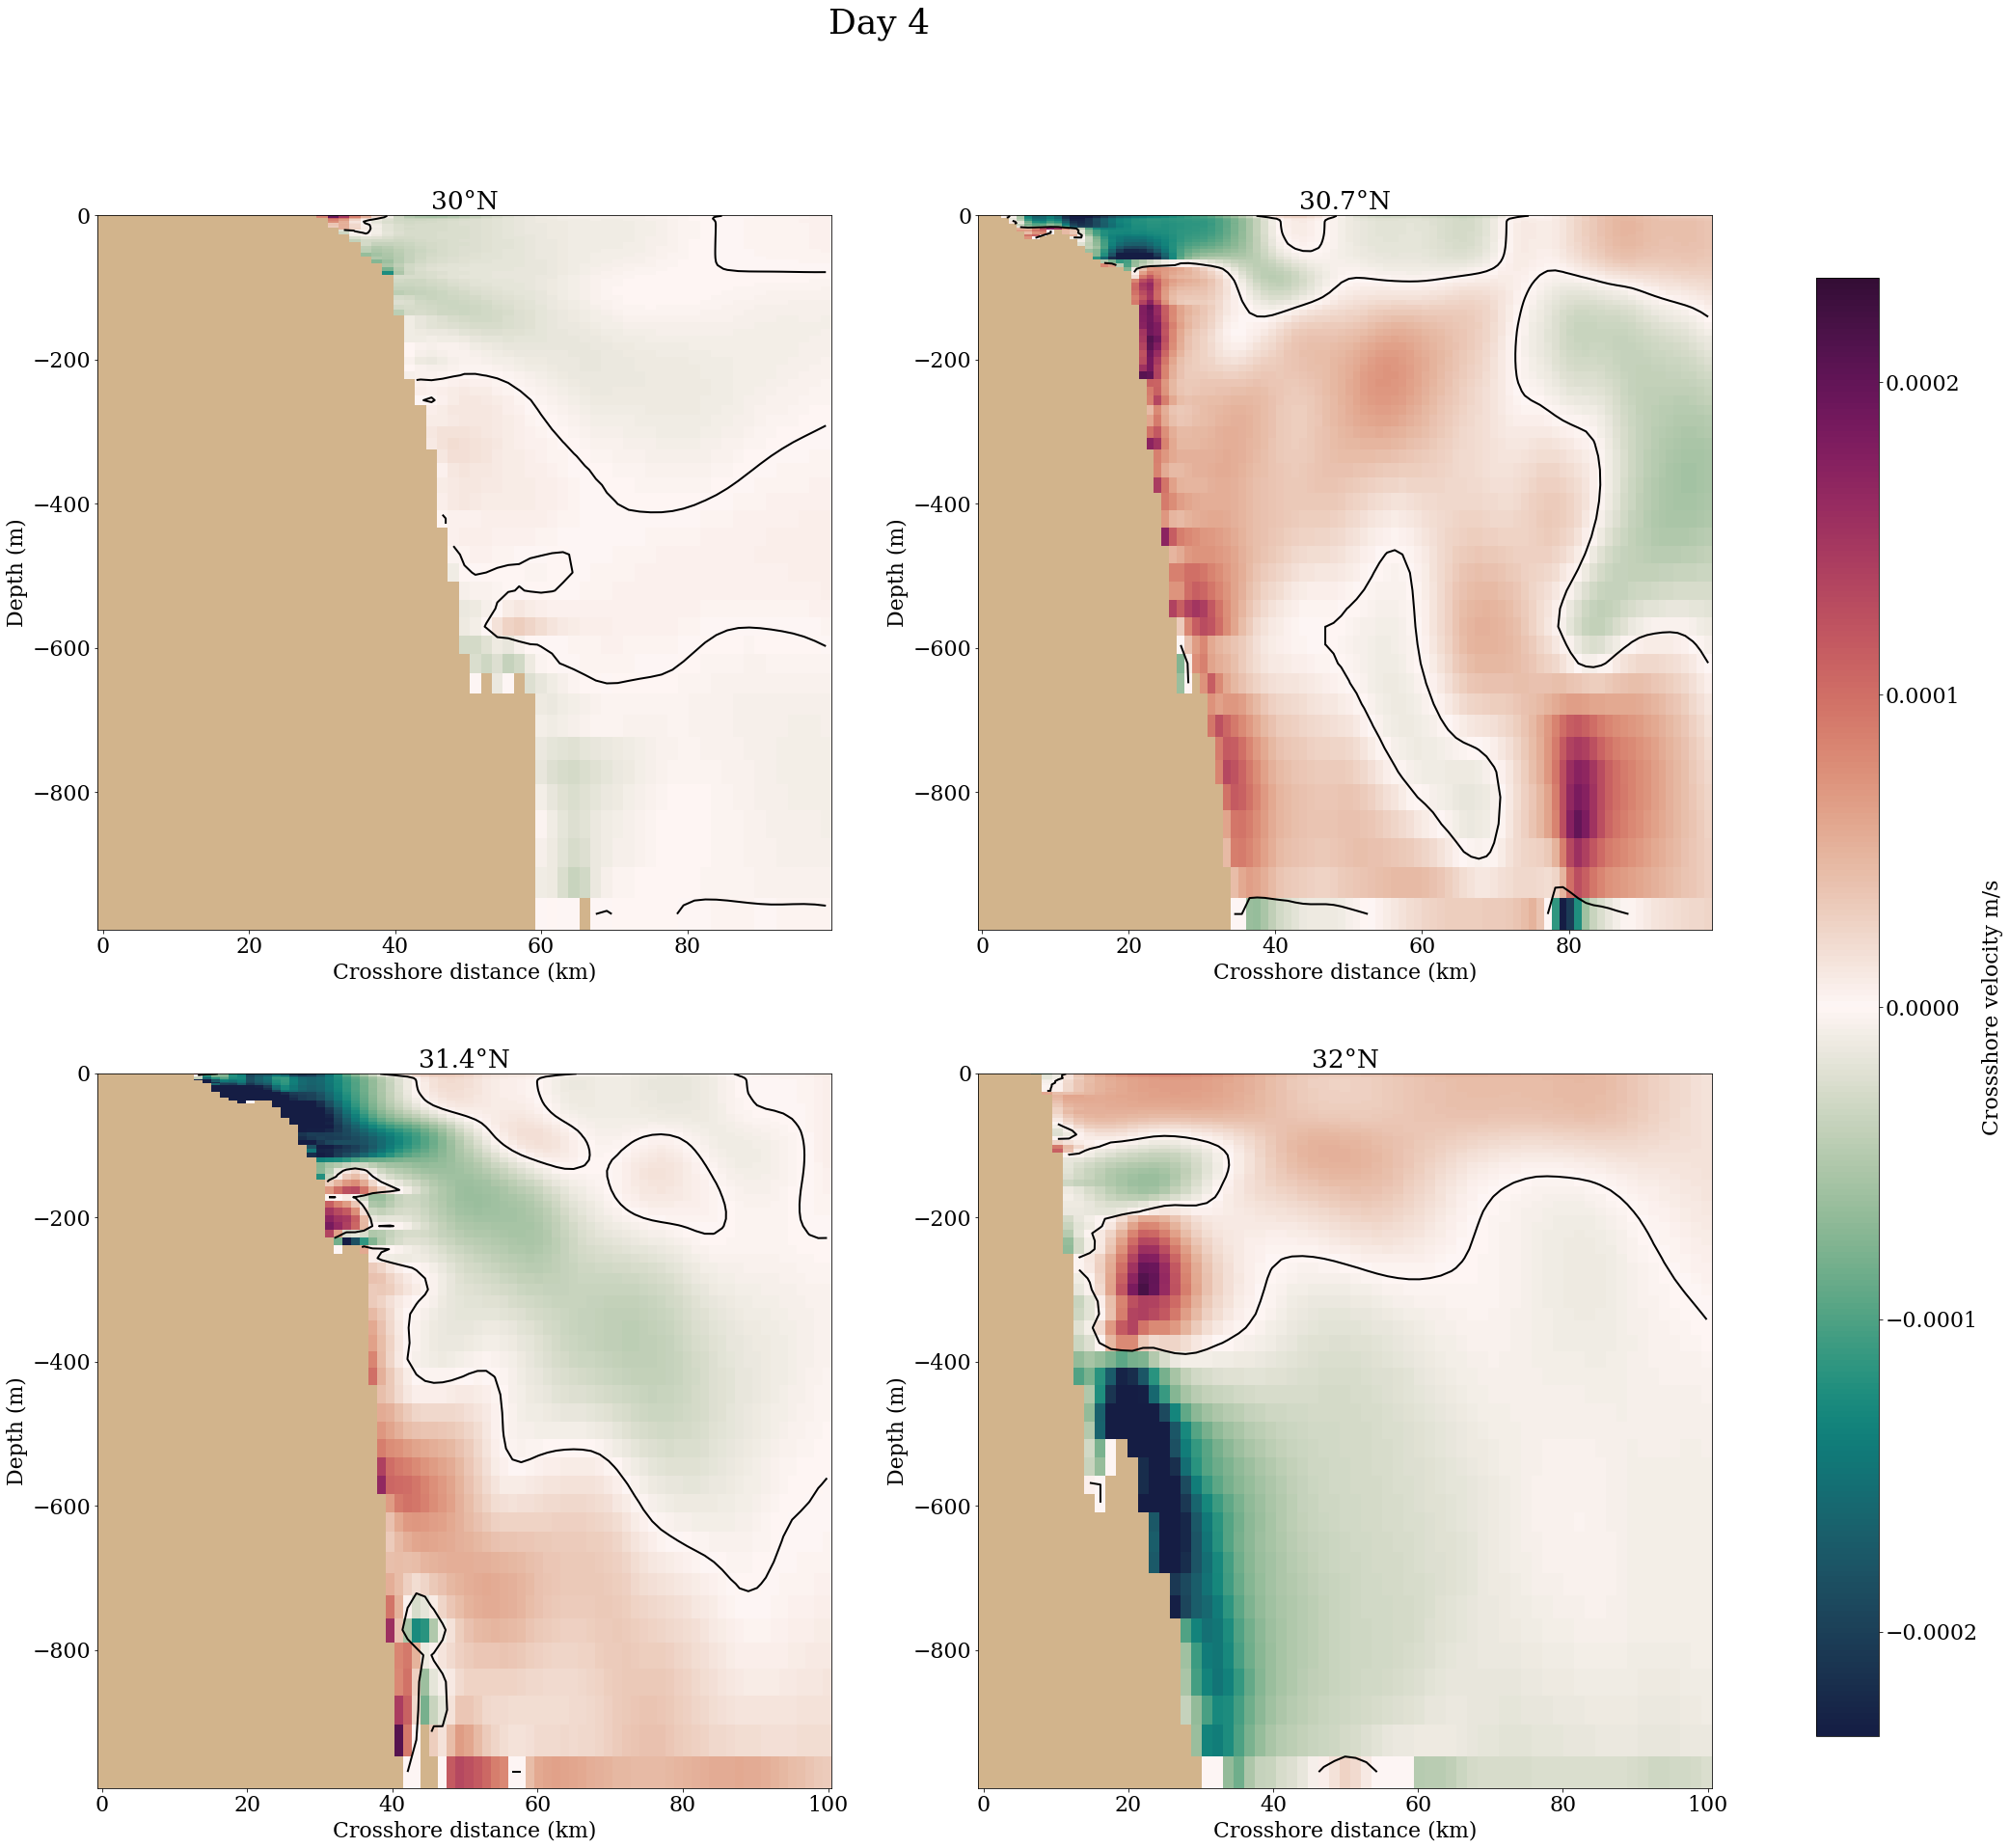

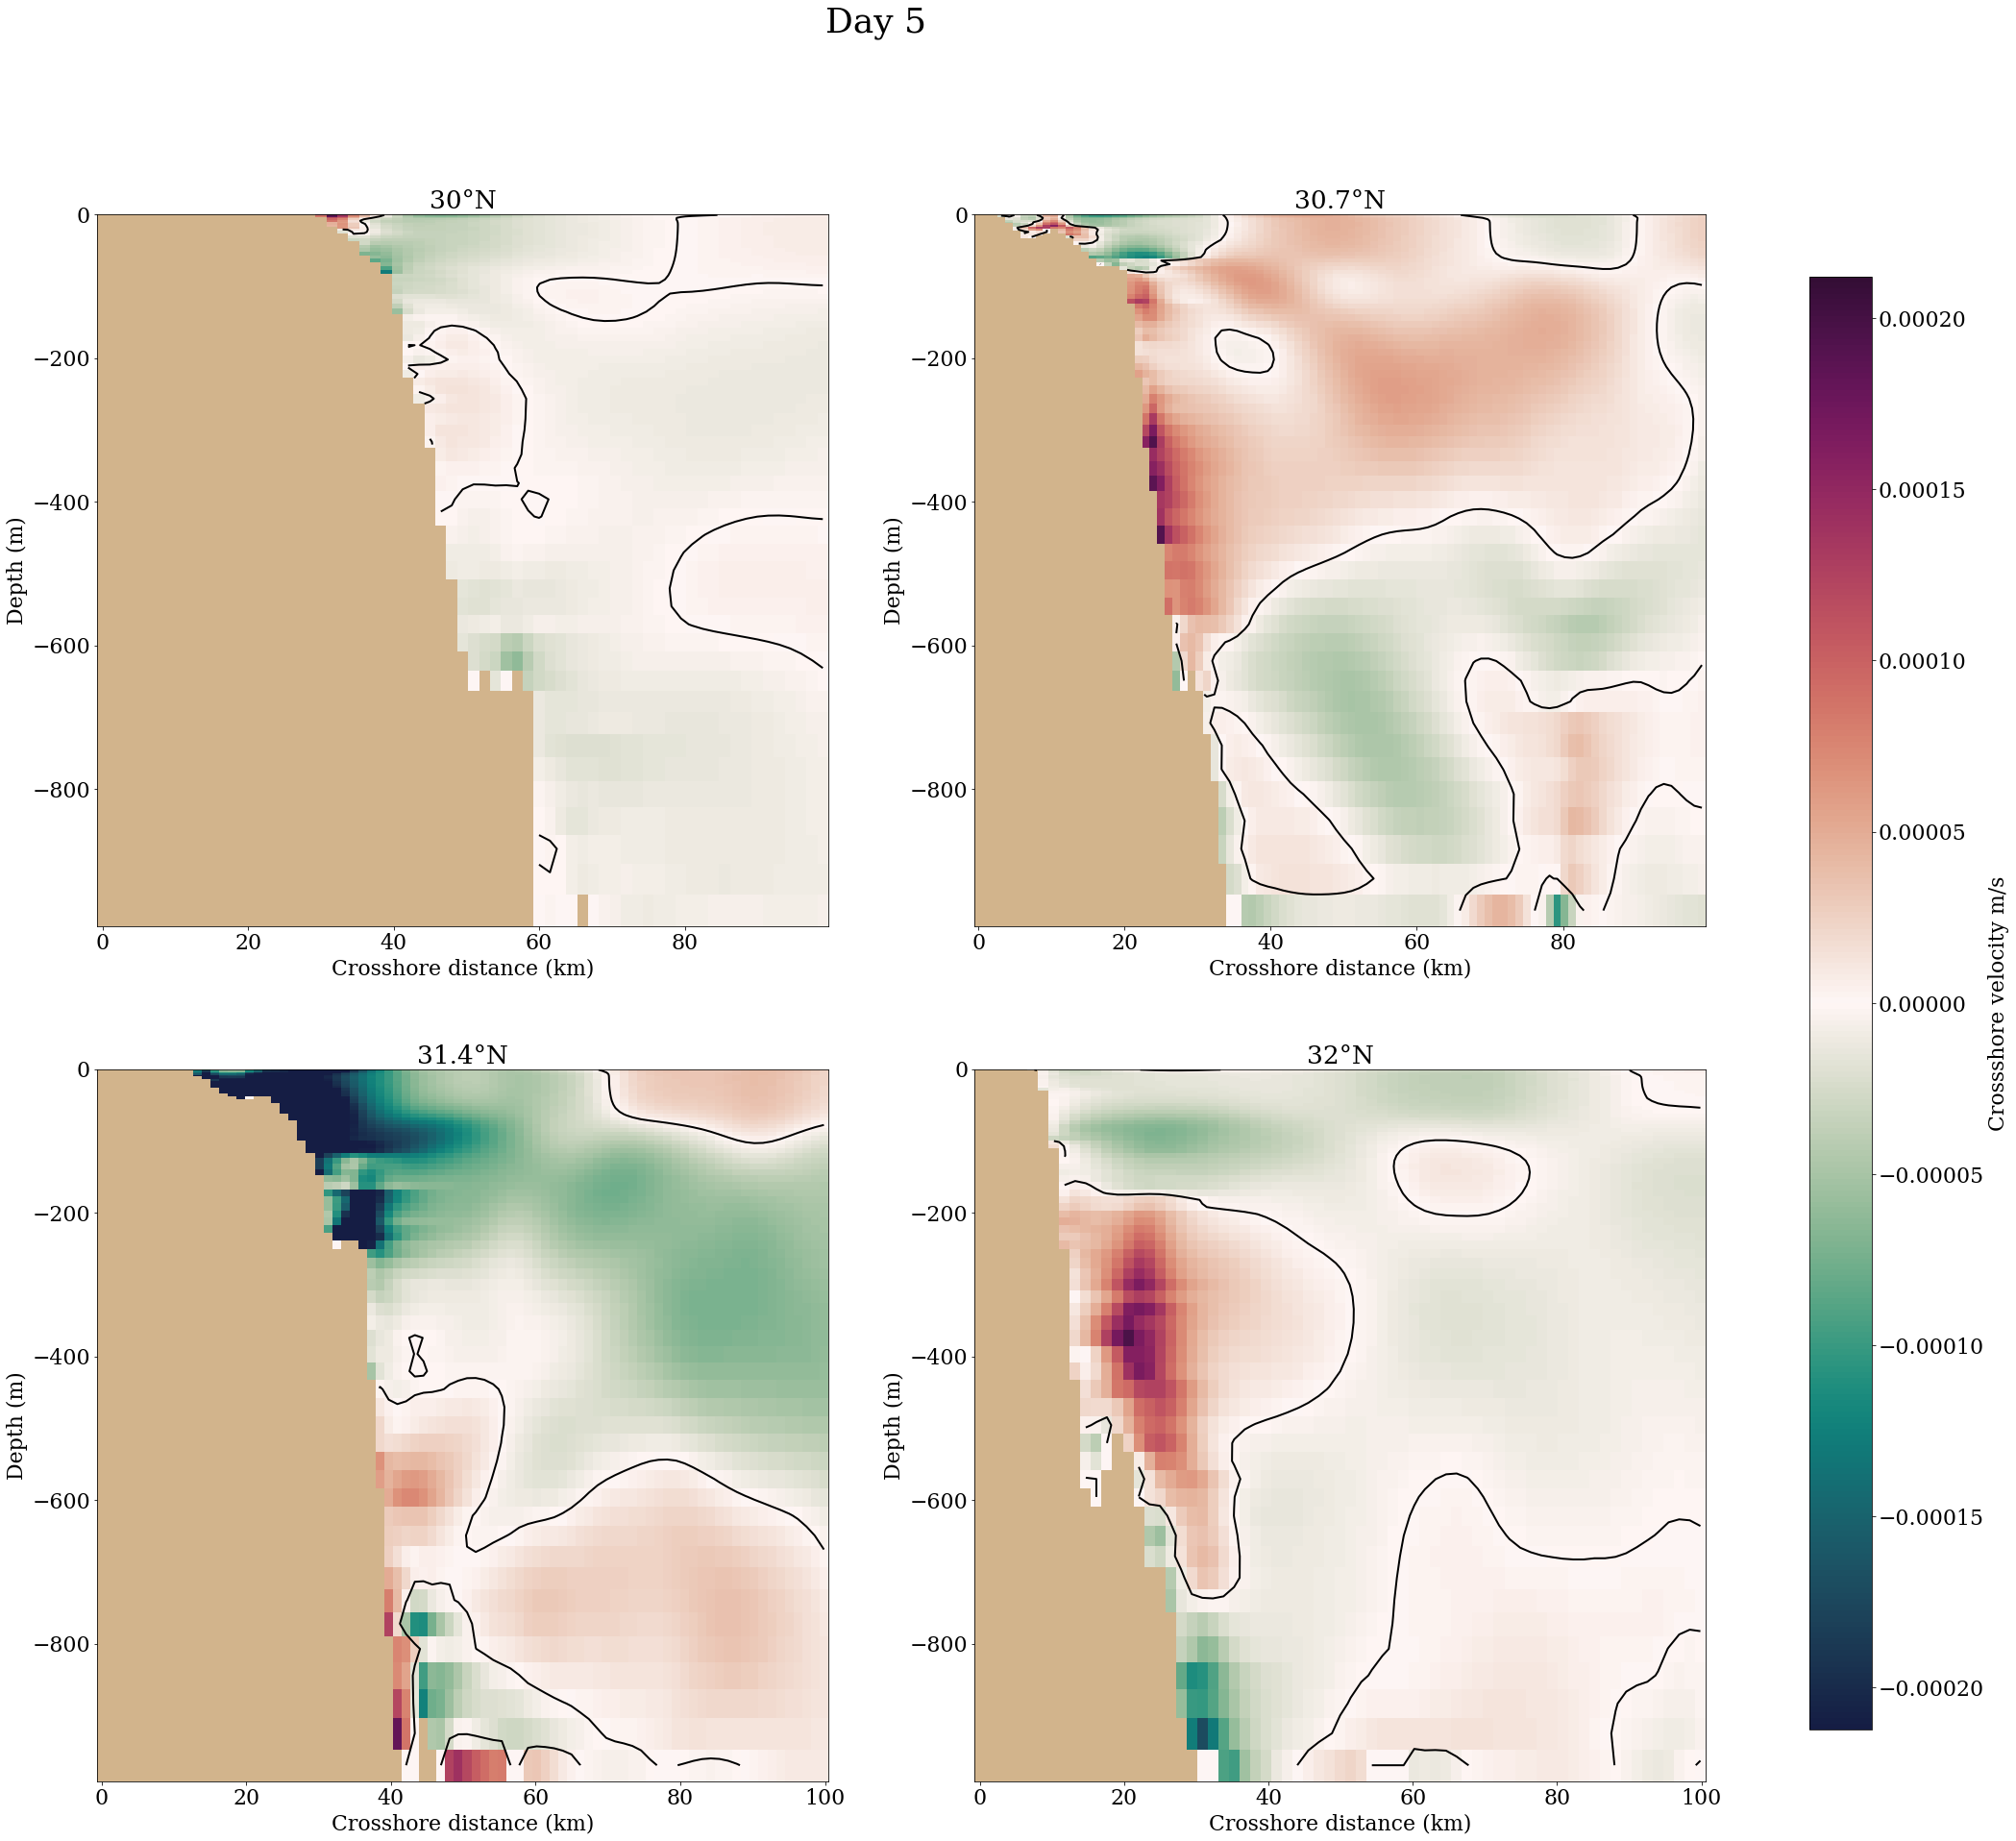

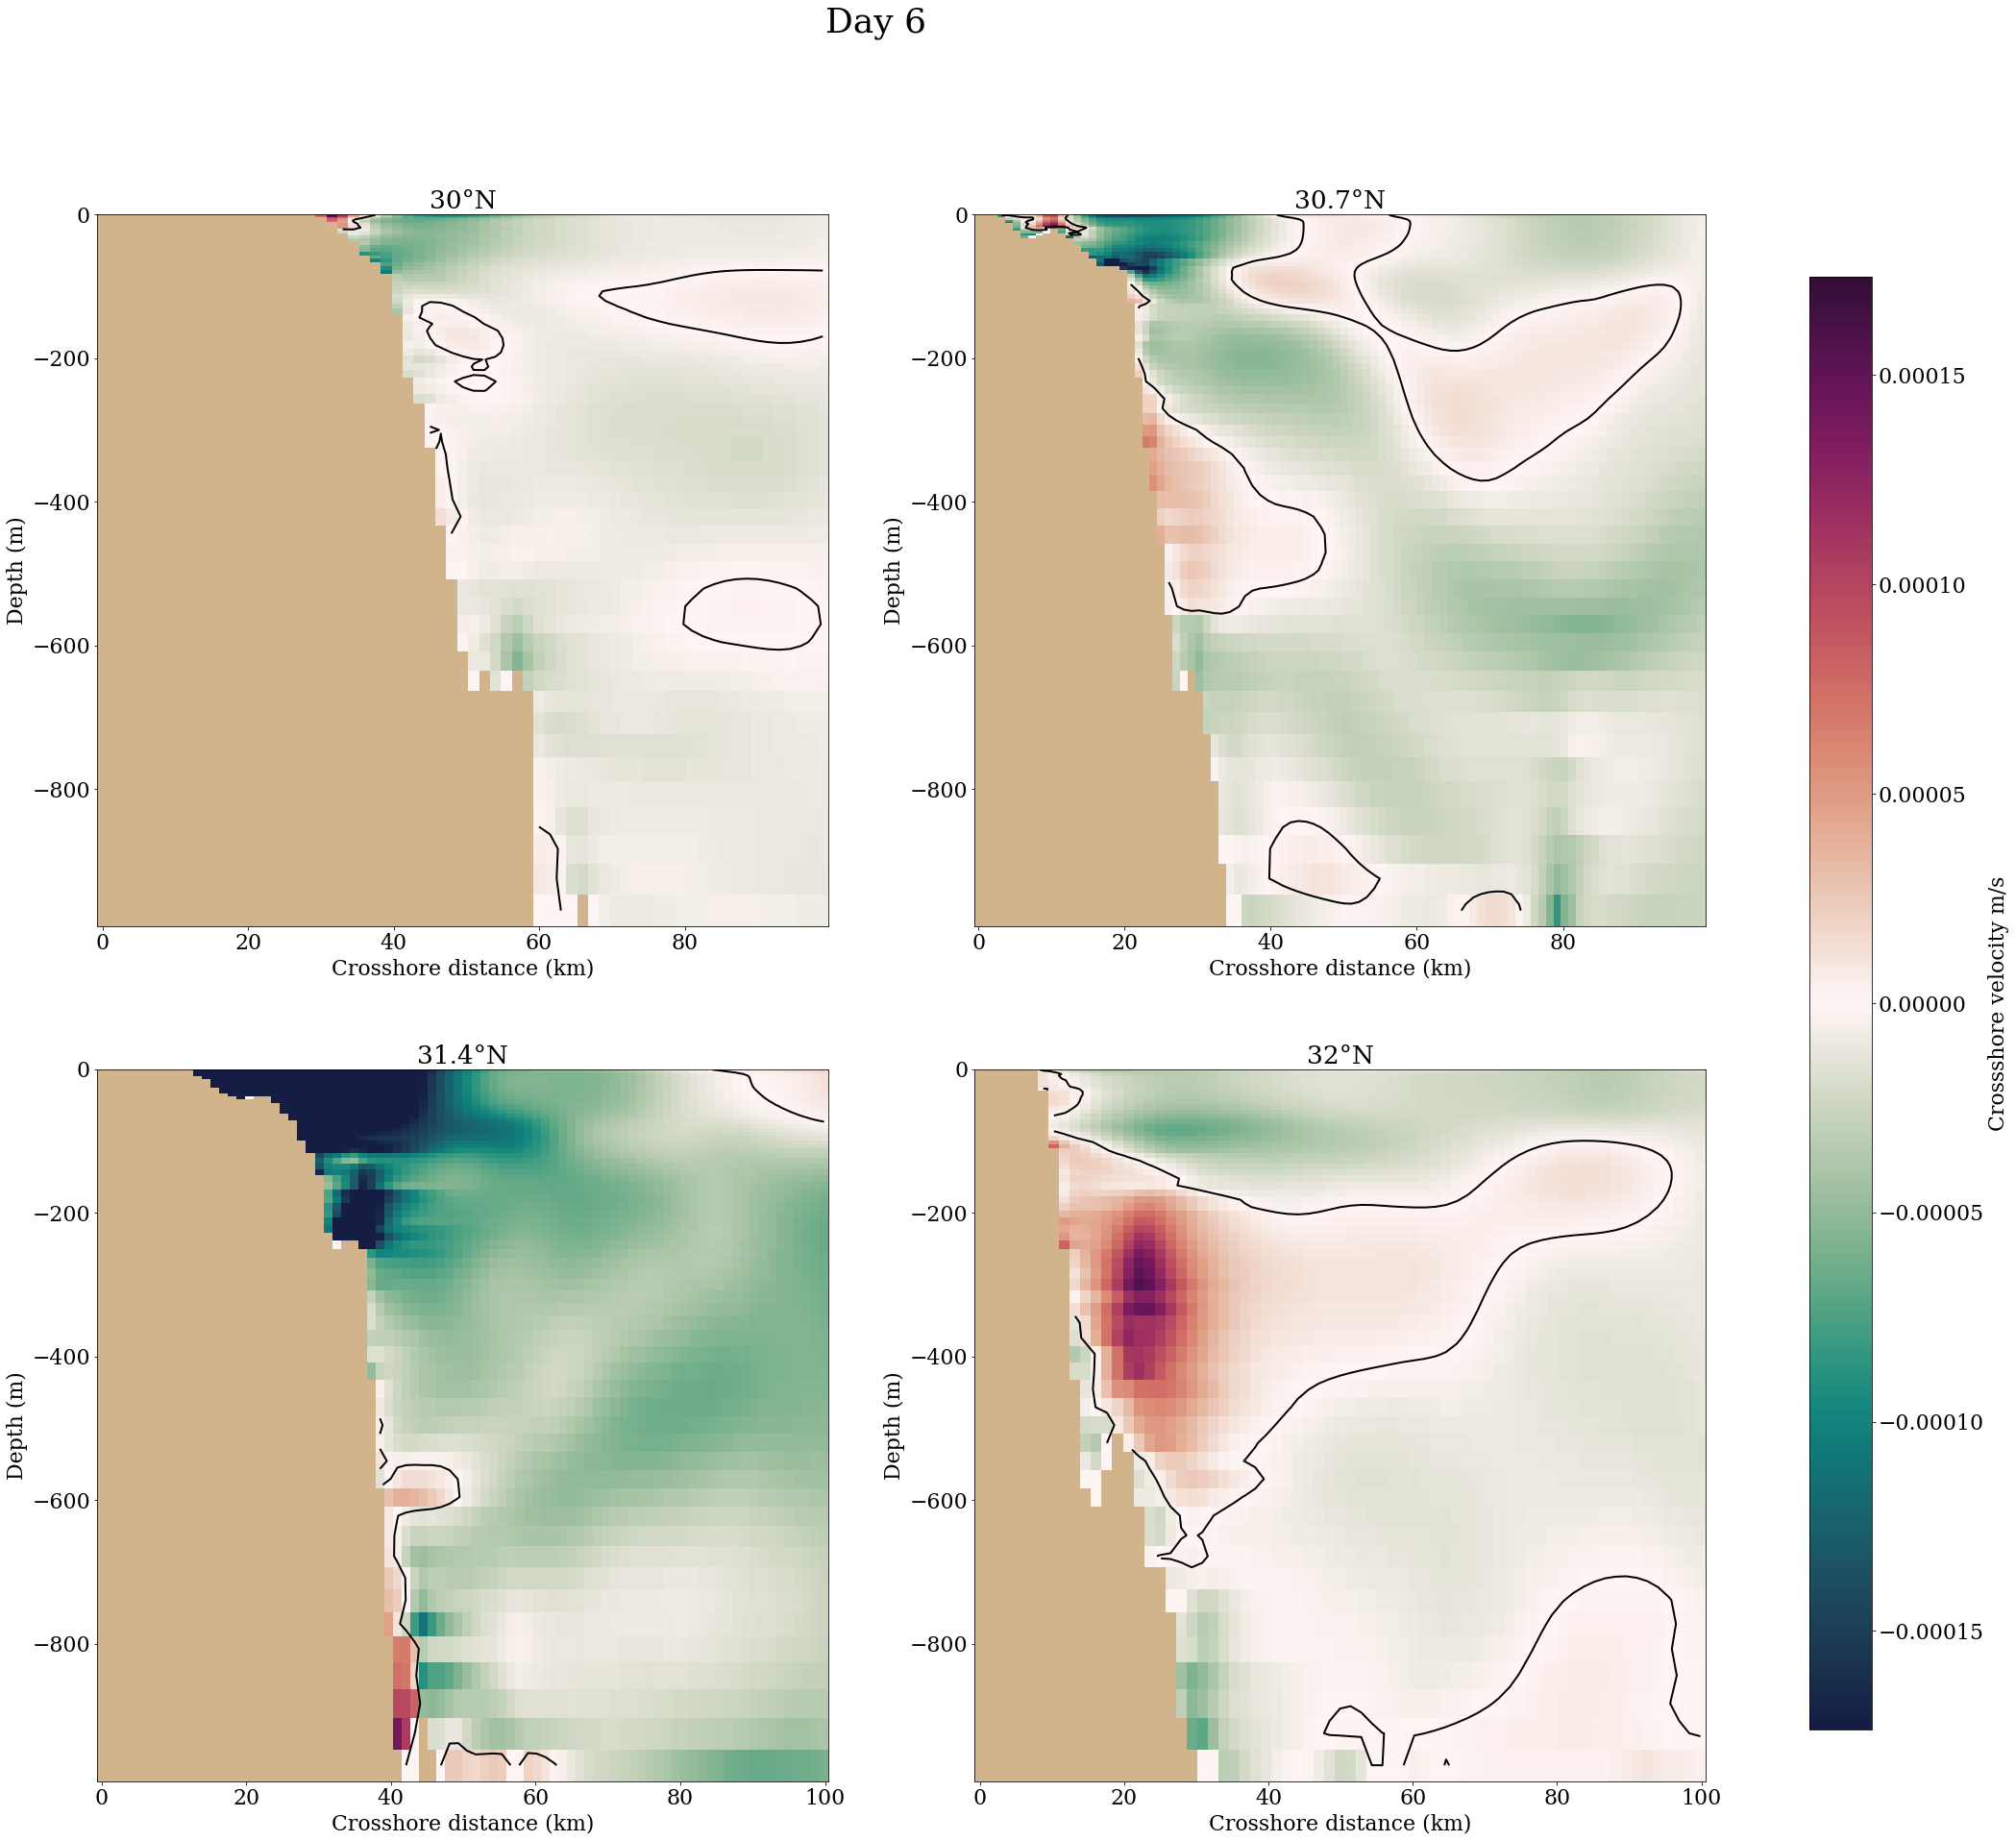

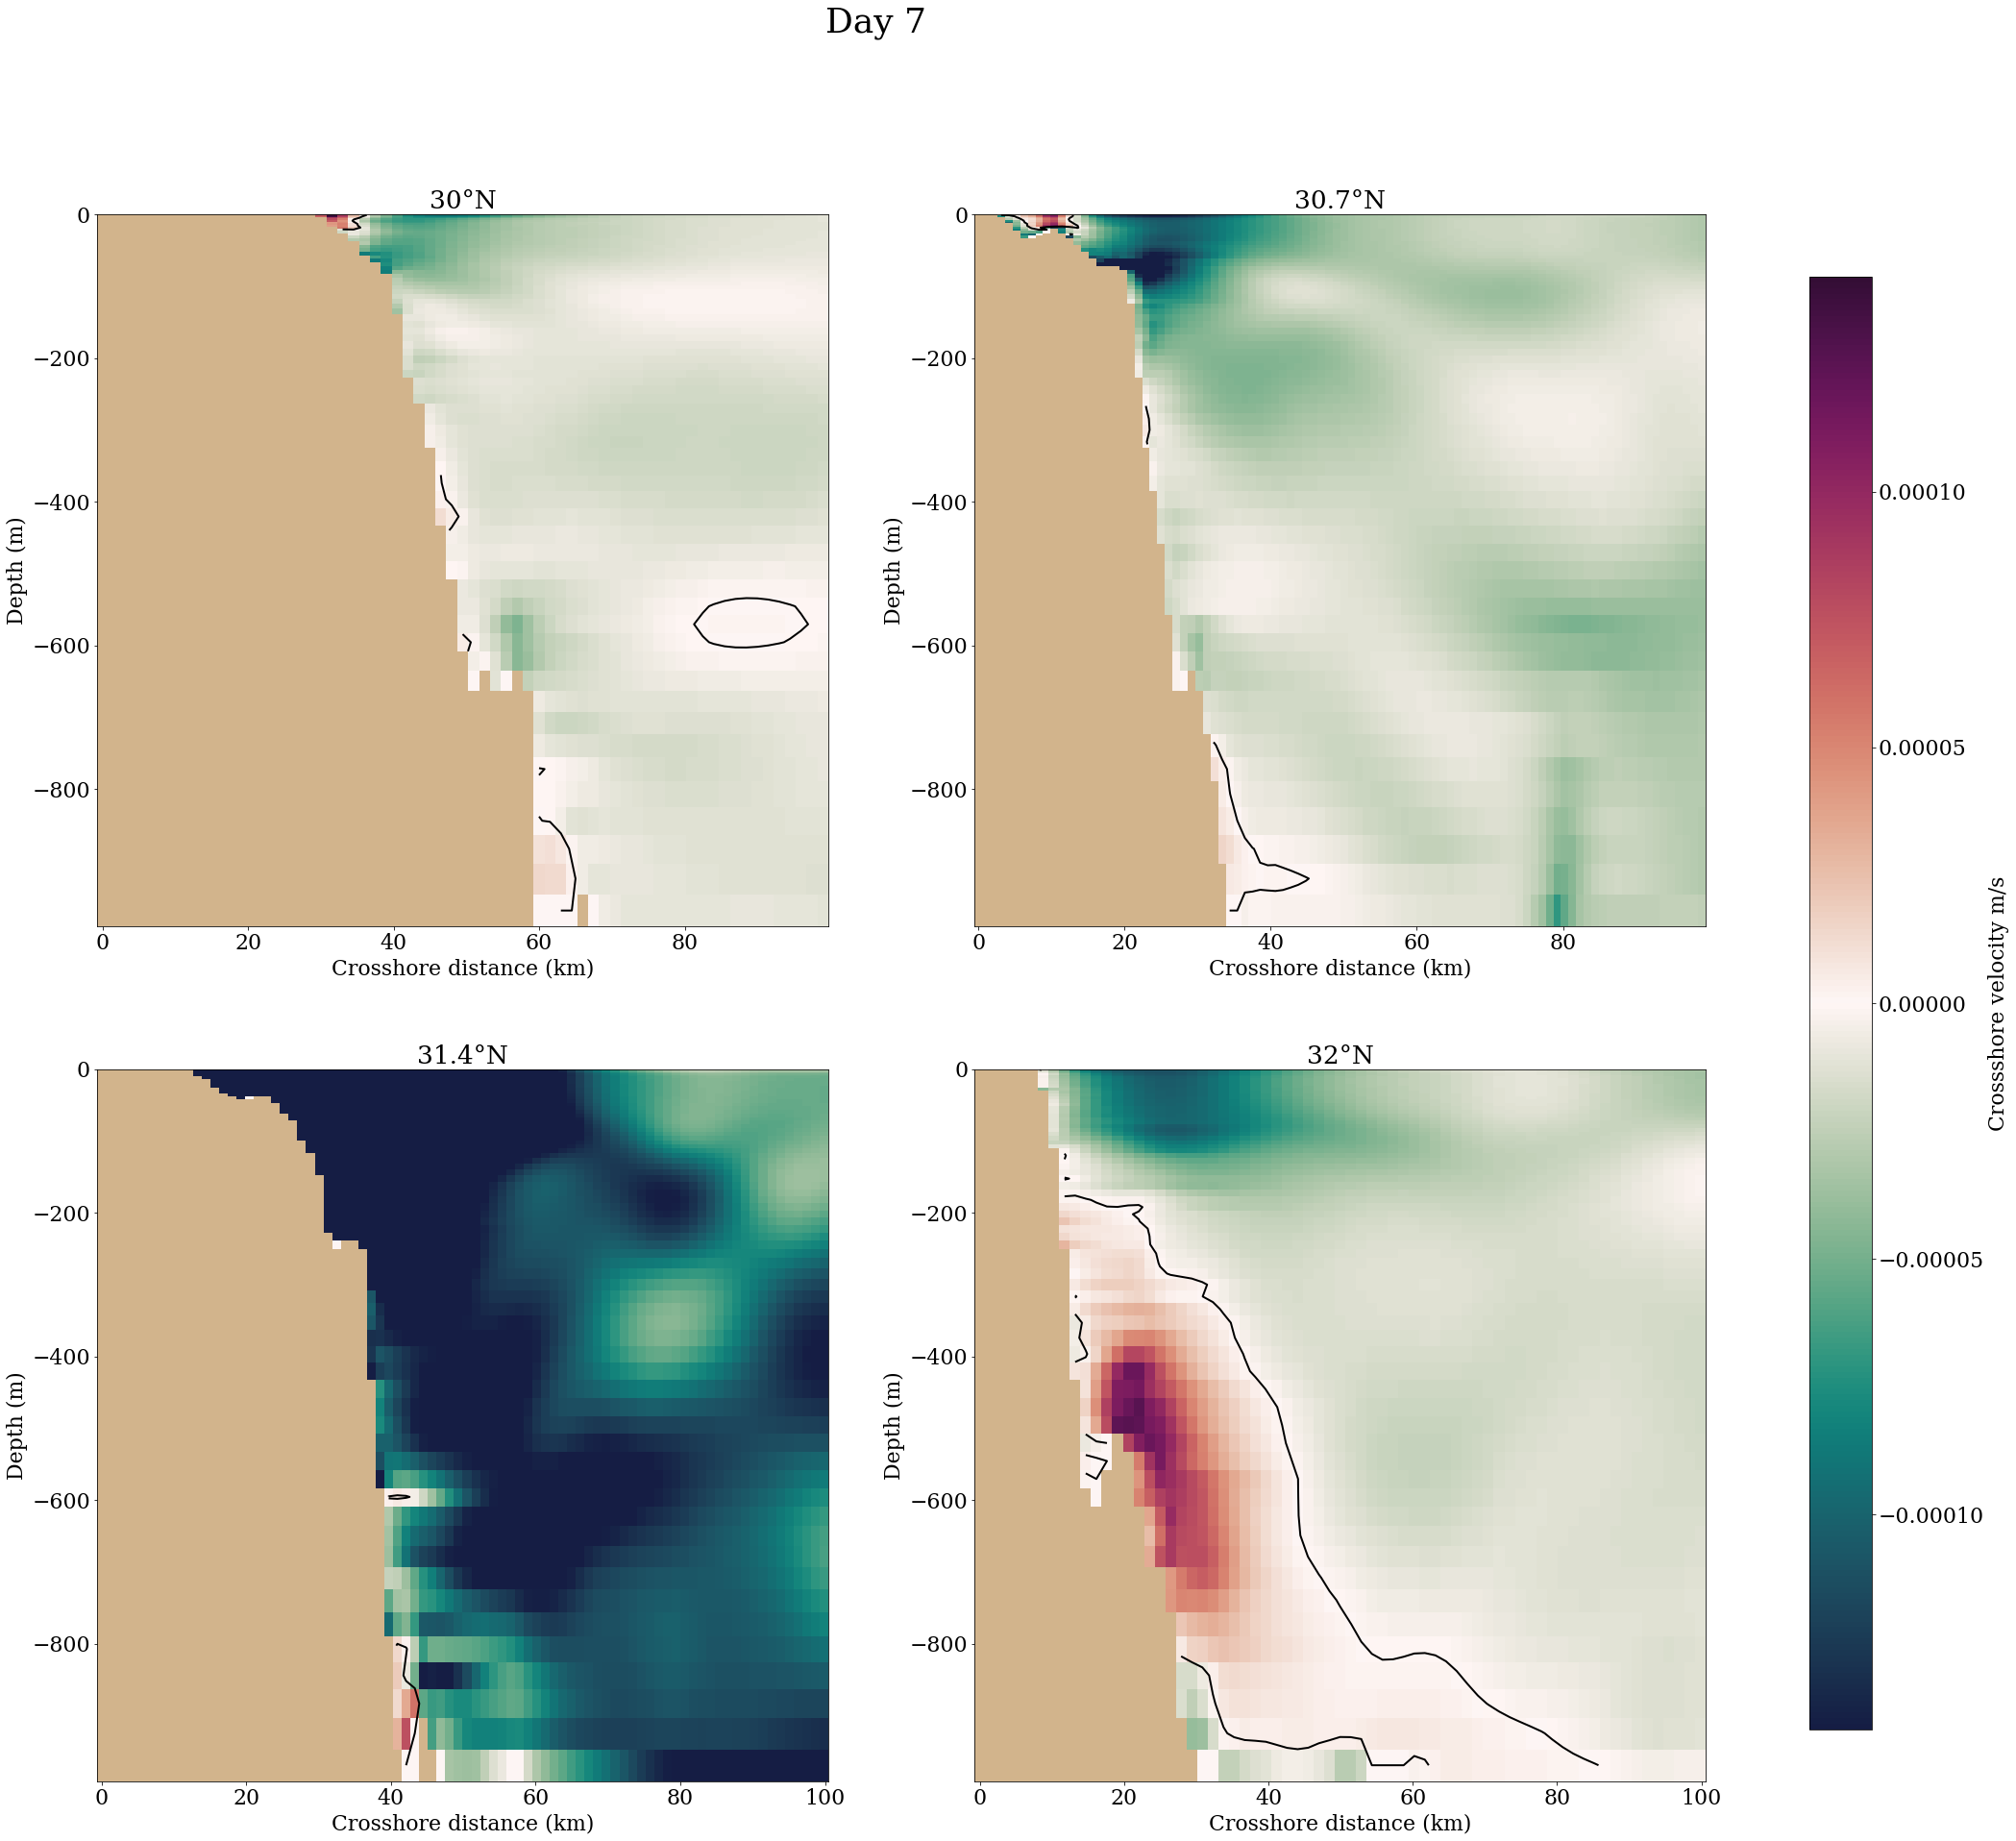

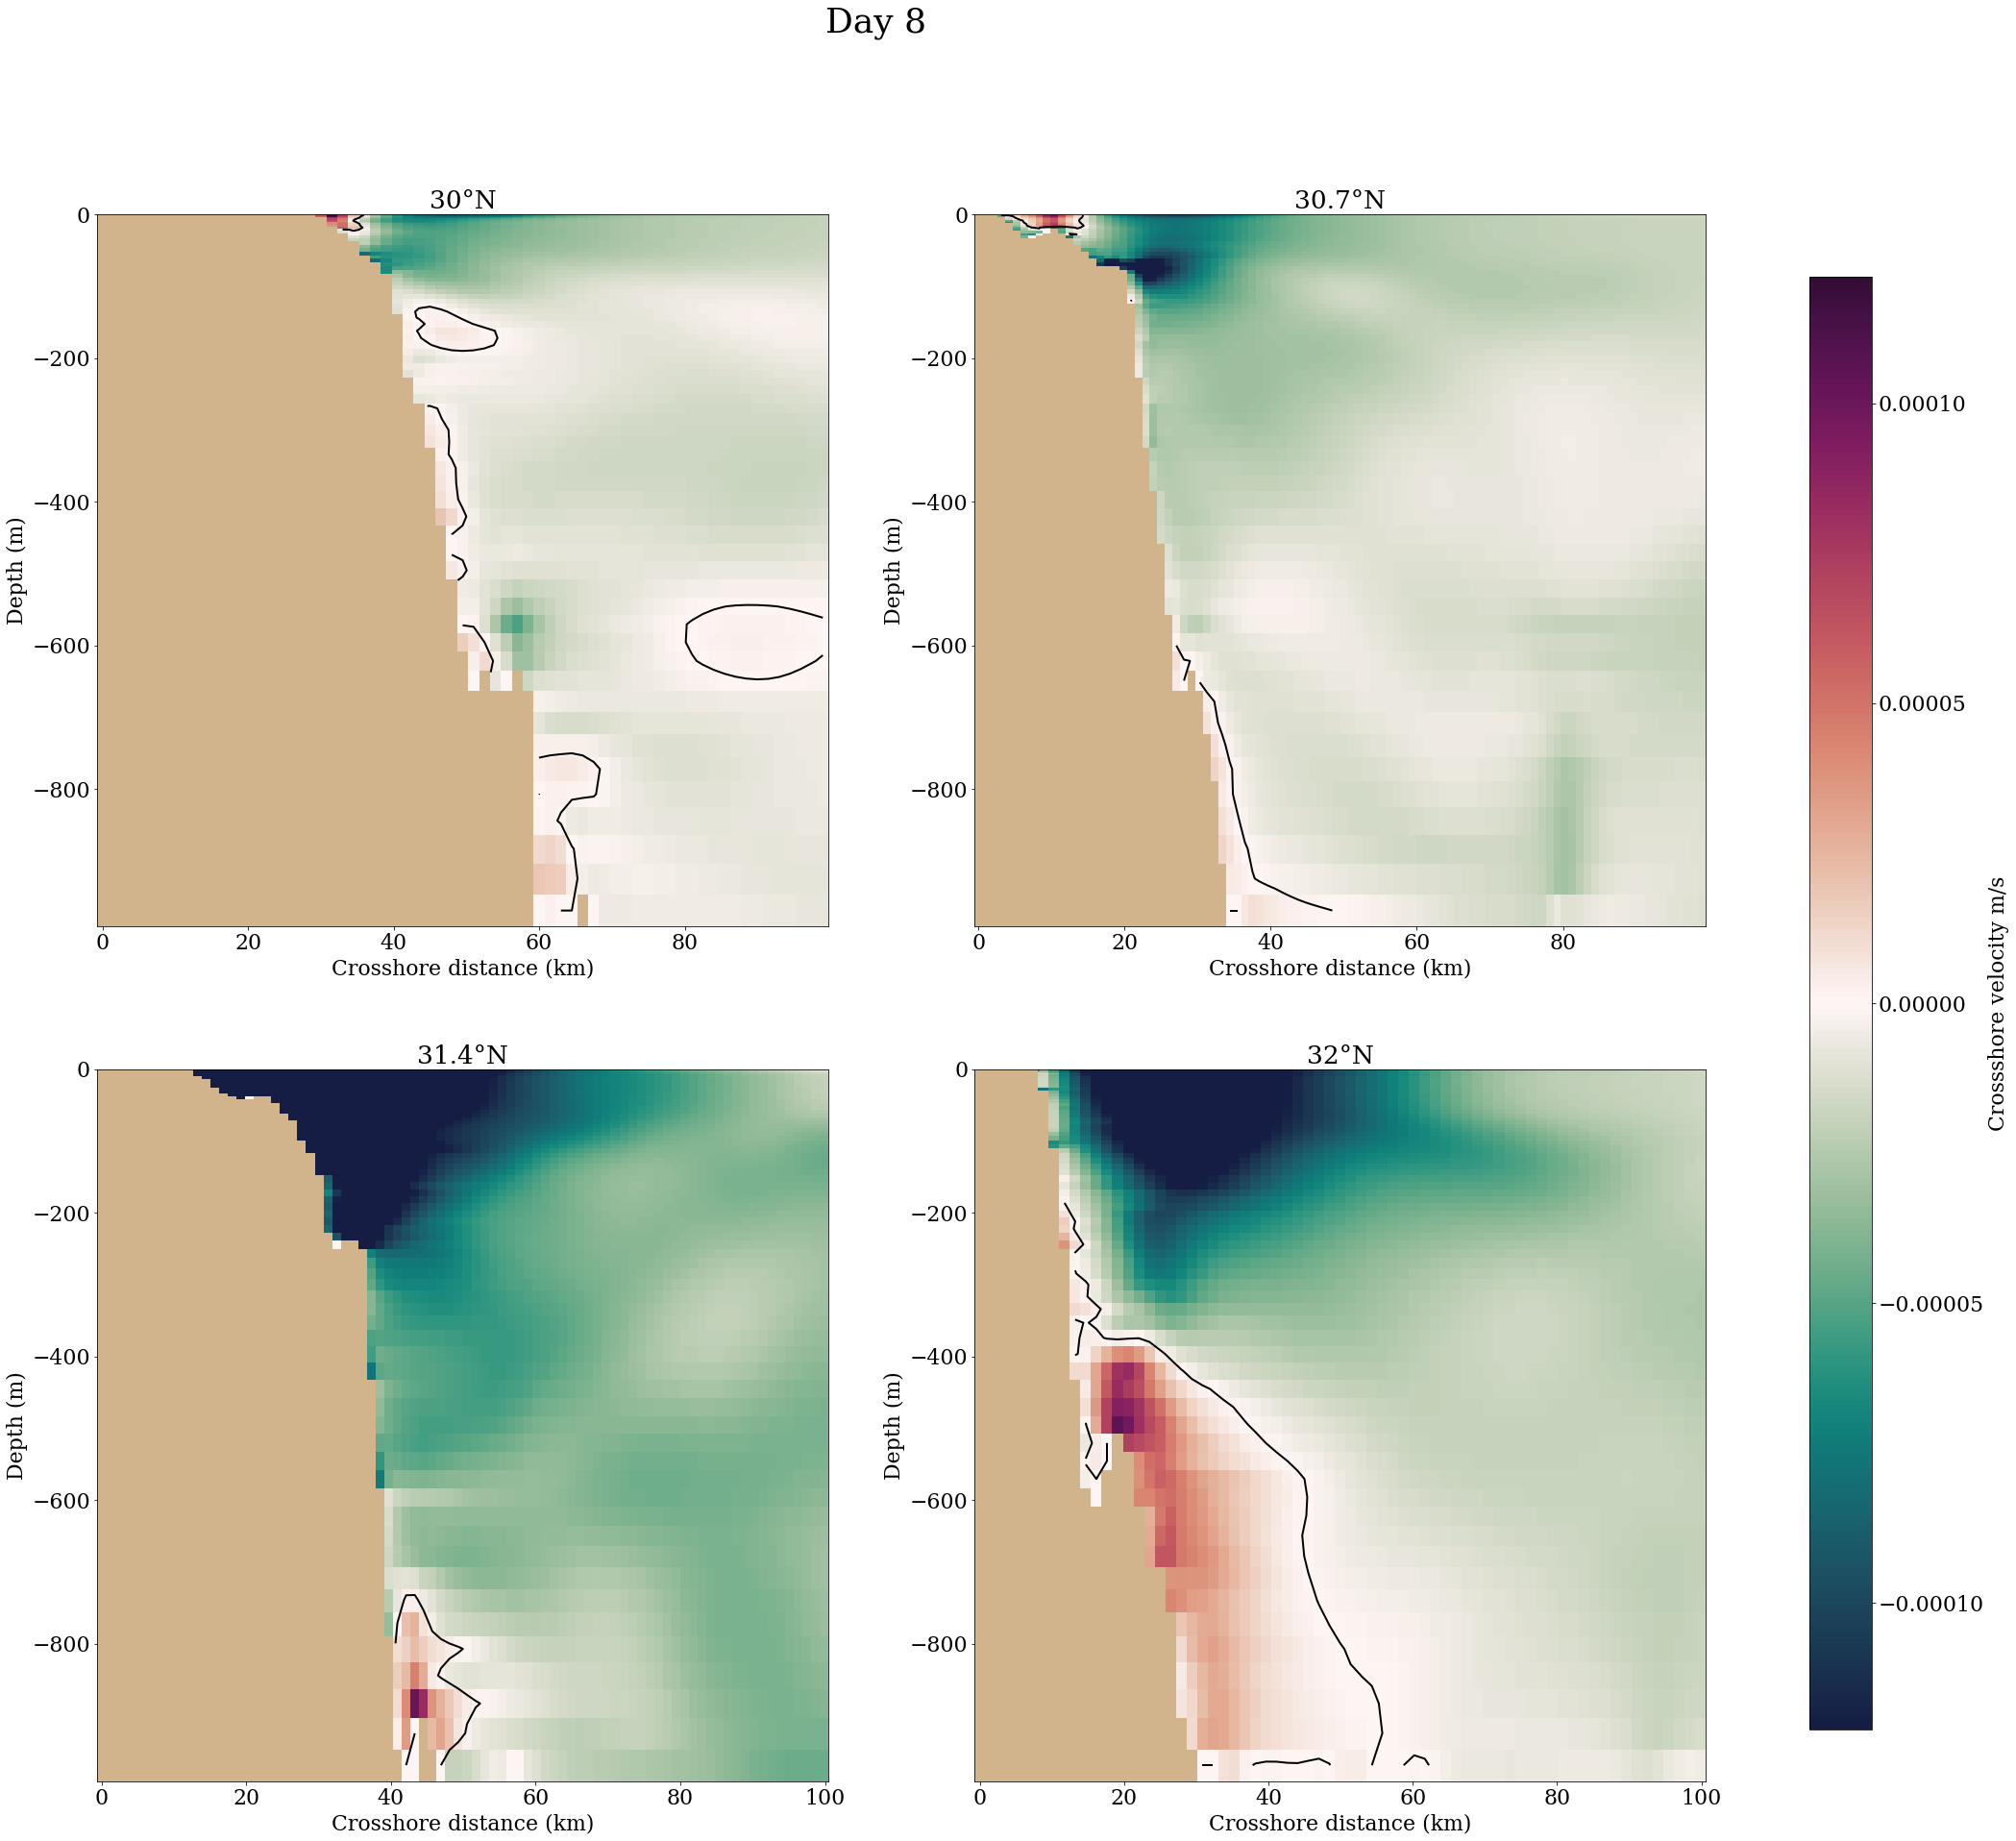

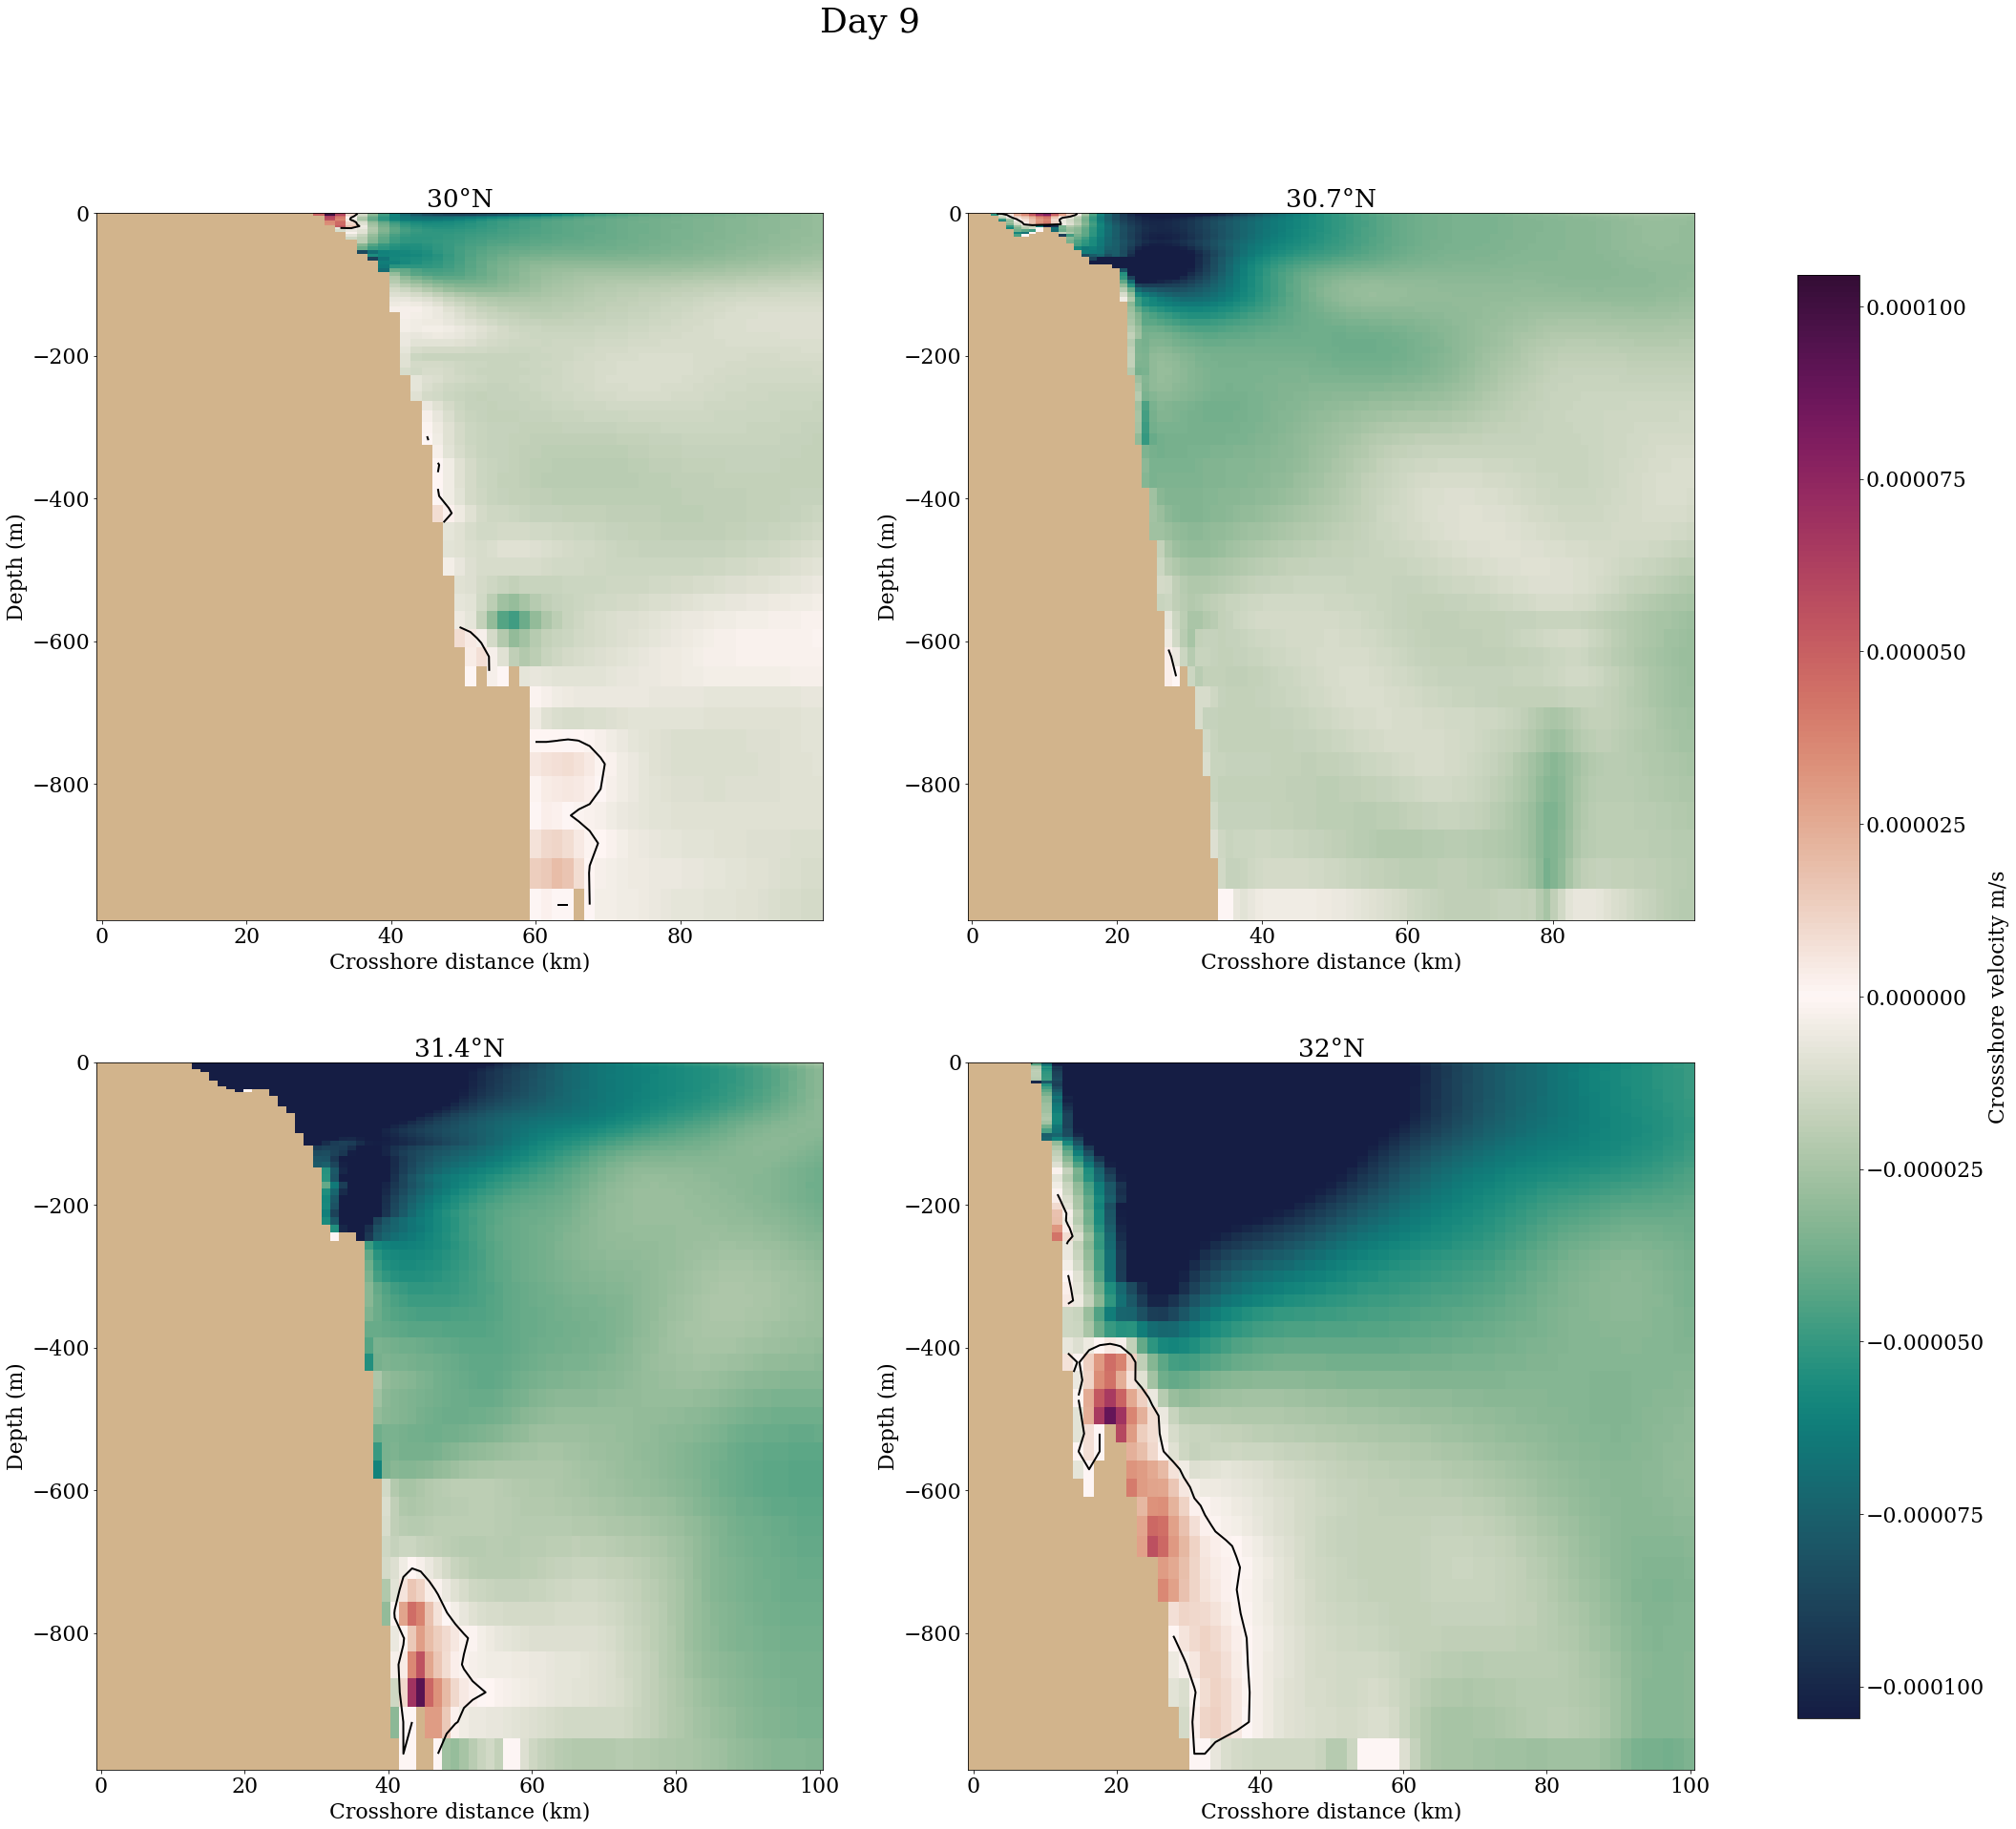

In [21]:
time0=0 #Day 2.5
time1=1 # Day 3.5
time2=2 # Day 5
time3=3 # Day 6
time4=4 #Day 7
time5=5 #Day 8
time6=6 #Day 9
Vel='Crossshore velocity m/s'

fig0, ax = plt.subplots(2,2)
fig0.suptitle('Day 2', fontsize=36)
VALbu=dsw[0].UVEL
VALnu=dsn[0].UVEL
plot_vel(time0,dist30,dist307,dist314,dist32,Z,VALbu,VALnu,Vel,fig0,ax)

fig1, ax = plt.subplots(2,2)
fig1.suptitle('Day 3', fontsize=36)
VALbu=dsw[1].UVEL
VALnu=dsn[1].UVEL
plot_vel(time0,dist30,dist307,dist314,dist32,Z,VALbu,VALnu,Vel,fig1,ax)

fig2, ax = plt.subplots(2,2)
fig2.suptitle('Day 4', fontsize=36)
VALbu=dsw[2].UVEL
VALnu=dsn[2].UVEL
plot_vel(time1,dist30,dist307,dist314,dist32,Z,VALbu,VALnu,Vel,fig2,ax)

fig3, ax = plt.subplots(2,2)
fig3.suptitle('Day 5', fontsize=36)
VALbu=dsw[3].UVEL
VALnu=dsn[3].UVEL
plot_vel(time2,dist30,dist307,dist314,dist32,Z,VALbu,VALnu,Vel,fig3,ax)

fig4, ax = plt.subplots(2,2)
fig4.suptitle('Day 6', fontsize=36)
VALbu=dsw[4].UVEL
VALnu=dsn[4].UVEL
plot_vel(time3,dist30,dist307,dist314,dist32,Z,VALbu,VALnu,Vel,fig4,ax)

fig5, ax = plt.subplots(2,2)
fig5.suptitle('Day 7', fontsize=36)
VALbu=dsw[5].UVEL
VALnu=dsn[5].UVEL
plot_vel(time4,dist30,dist307,dist314,dist32,Z,VALbu,VALnu,Vel,fig5,ax)

fig6, ax = plt.subplots(2,2)
fig6.suptitle('Day 8', fontsize=36)
VALbu=dsw[6].UVEL
VALnu=dsn[6].UVEL
plot_vel(time5,dist30,dist307,dist314,dist32,Z,VALbu,VALnu,Vel,fig6,ax)

fig7, ax = plt.subplots(2,2)
fig7.suptitle('Day 9', fontsize=36)
VALbu=dsw[7].UVEL
VALnu=dsn[7].UVEL
plot_vel(time6,dist30,dist307,dist314,dist32,Z,VALbu,VALnu,Vel,fig7,ax)

In [ ]:
def loadNetCDFACs(varname):
    dsw=[]
    dsn=[]
    i=0
    for i in np.arange(1,7,1):

        pathn='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL/01_noSVB_febTS/'+ str(varname)+'ACnoSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'
        pathw='/media/amelia/Trillian/SVB/exp06_512x612x100_ORL_SVB/01_SVB_febTS/'+ str(varname)+'ACwithSVB'+ str(2+i)+'_'+ str(3+i) +'.nc'

        dswin  = xr.open_dataset(pathw)
        dsnin = xr.open_dataset(pathn)

        dsw.append(dswin)
        dsn.append(dsnin)

    return dsw, dsn

def loadWVEL(dsw,dsn):
    var23=dsw[0].Ww.values
    var34=dsw[1].Ww.values
    var45=dsw[2].Ww.values
    var56=dsw[3].Ww.values
    var67=dsw[4].Ww.values
    var78=dsw[5].Ww.values
    var89=dsw[6].Ww.values
    #var910=dsw[7].Ww.values
    
    Ww=np.concatenate((var23, var34, var45, var56,var67,var78,var89), axis=0)# , ,var910), axis=0) 
    
    var23n=dsn[0].Wn.values
    var34n=dsn[1].Wn.values
    var45n=dsn[2].Wn.values
    var56n=dsn[3].Wn.values                 
    var67n=dsn[4].Wn.values
    var78n=dsn[5].Wn.values
    var89n=dsn[6].Wn.values
    #var910n=dsn[7].Wn.values
    
    Wn=np.concatenate((var23n, var34n, var45n, var56n,var67n,var78n,var89n), axis=0) #, var910n), axis=0) 
    
    time23=dsw[0].time.values.astype(int)
    time34=dsw[1].time.values.astype(int)
    time45=dsw[2].time.values.astype(int)
    time56=dsw[3].time.values.astype(int)
    time67=dsw[4].time.values.astype(int)
    time78=dsw[5].time.values.astype(int)
    time89=dsw[6].time.values.astype(int)
    #time910=dsw[7].time.values.astype(int)
    
    Time=np.concatenate((time23, time34, time45, time56,time67, time78,time89), axis=0)#, time910), axis=0)
    
    times=Time*1e-9
    
    return Ww,Wn,times

def loadVVEL(dsw,dsn):
    var23=dsw[0].Vw.values
    var34=dsw[1].Vw.values
    var45=dsw[2].Vw.values
    var56=dsw[3].Vw.values
    var67=dsw[4].Vw.values
    var78=dsw[5].Vw.values
    var89=dsw[6].Vw.values
    #var910=dsw[7].Vw.values
    
    Vw=np.concatenate((var23, var34, var45, var56,var67, var78,var89), axis=0)#, var910), axis=0) 
    
    var23n=dsn[0].Vn.values
    var34n=dsn[1].Vn.values
    var45n=dsn[2].Vn.values
    var56n=dsn[3].Vn.values               
    var67n=dsn[4].Vn.values
    var78n=dsn[5].Vn.values
    var89n=dsn[6].Vn.values
    #var910n=dsn[7].Vn.values
    
    Vn=np.concatenate((var23n, var34n, var45n, var56n,var67n, var78n,var89n), axis=0) #, var910n), axis=0) 
    
    return Vw,Vn
    
    
def loadUVEL(dsw,dsn):
    var23=dsw[0].Uw.values
    var34=dsw[1].Uw.values
    var45=dsw[2].Uw.values
    var56=dsw[3].Uw.values
    var67=dsw[4].Uw.values
    var78=dsw[5].Uw.values
    var89=dsw[6].Uw.values
    #var910=dsw[7].Uw.values
    
    Uw=np.concatenate((var23, var34, var45, var56,var67, var78,var89), axis=0)#, var910), axis=0) 
    
    var23n=dsn[0].Un.values
    var34n=dsn[1].Un.values
    var45n=dsn[2].Un.values
    var56n=dsn[3].Un.values               
    var67n=dsn[4].Un.values
    var78n=dsn[5].Un.values
    var89n=dsn[6].Un.values
    #var910n=dsn[7].Un.values
    
    Un=np.concatenate((var23n, var34n, var45n, var56n,var67n, var78n,var89n), axis=0) #, var910n), axis=0) 
    
    return Uw,Un        

In [ ]:
dww,dwn=loadNetCDFACs('WVEL')
dvw,dvn=loadNetCDFACs('VVEL')
#duw,dun=loadNetCDFACs('UVEL')

In [16]:
#Ww,Wn,time=loadWVEL(dww,dwn)
Vw,Vn=loadVVEL(dvw,dvn)
#Uw,Un=loadUVEL(duw,dun)

In [17]:
#W=Ww-Wn
V=Vw-Vn
#U=Uw-Un

In [12]:
Z=dww[0].z
X=dww[0].x
nt = np.size(time)

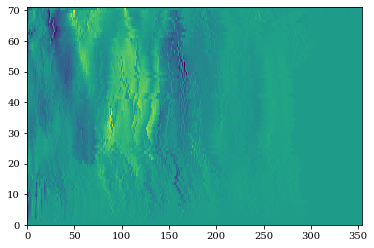

In [25]:
plt.pcolormesh(W[1,:,:])

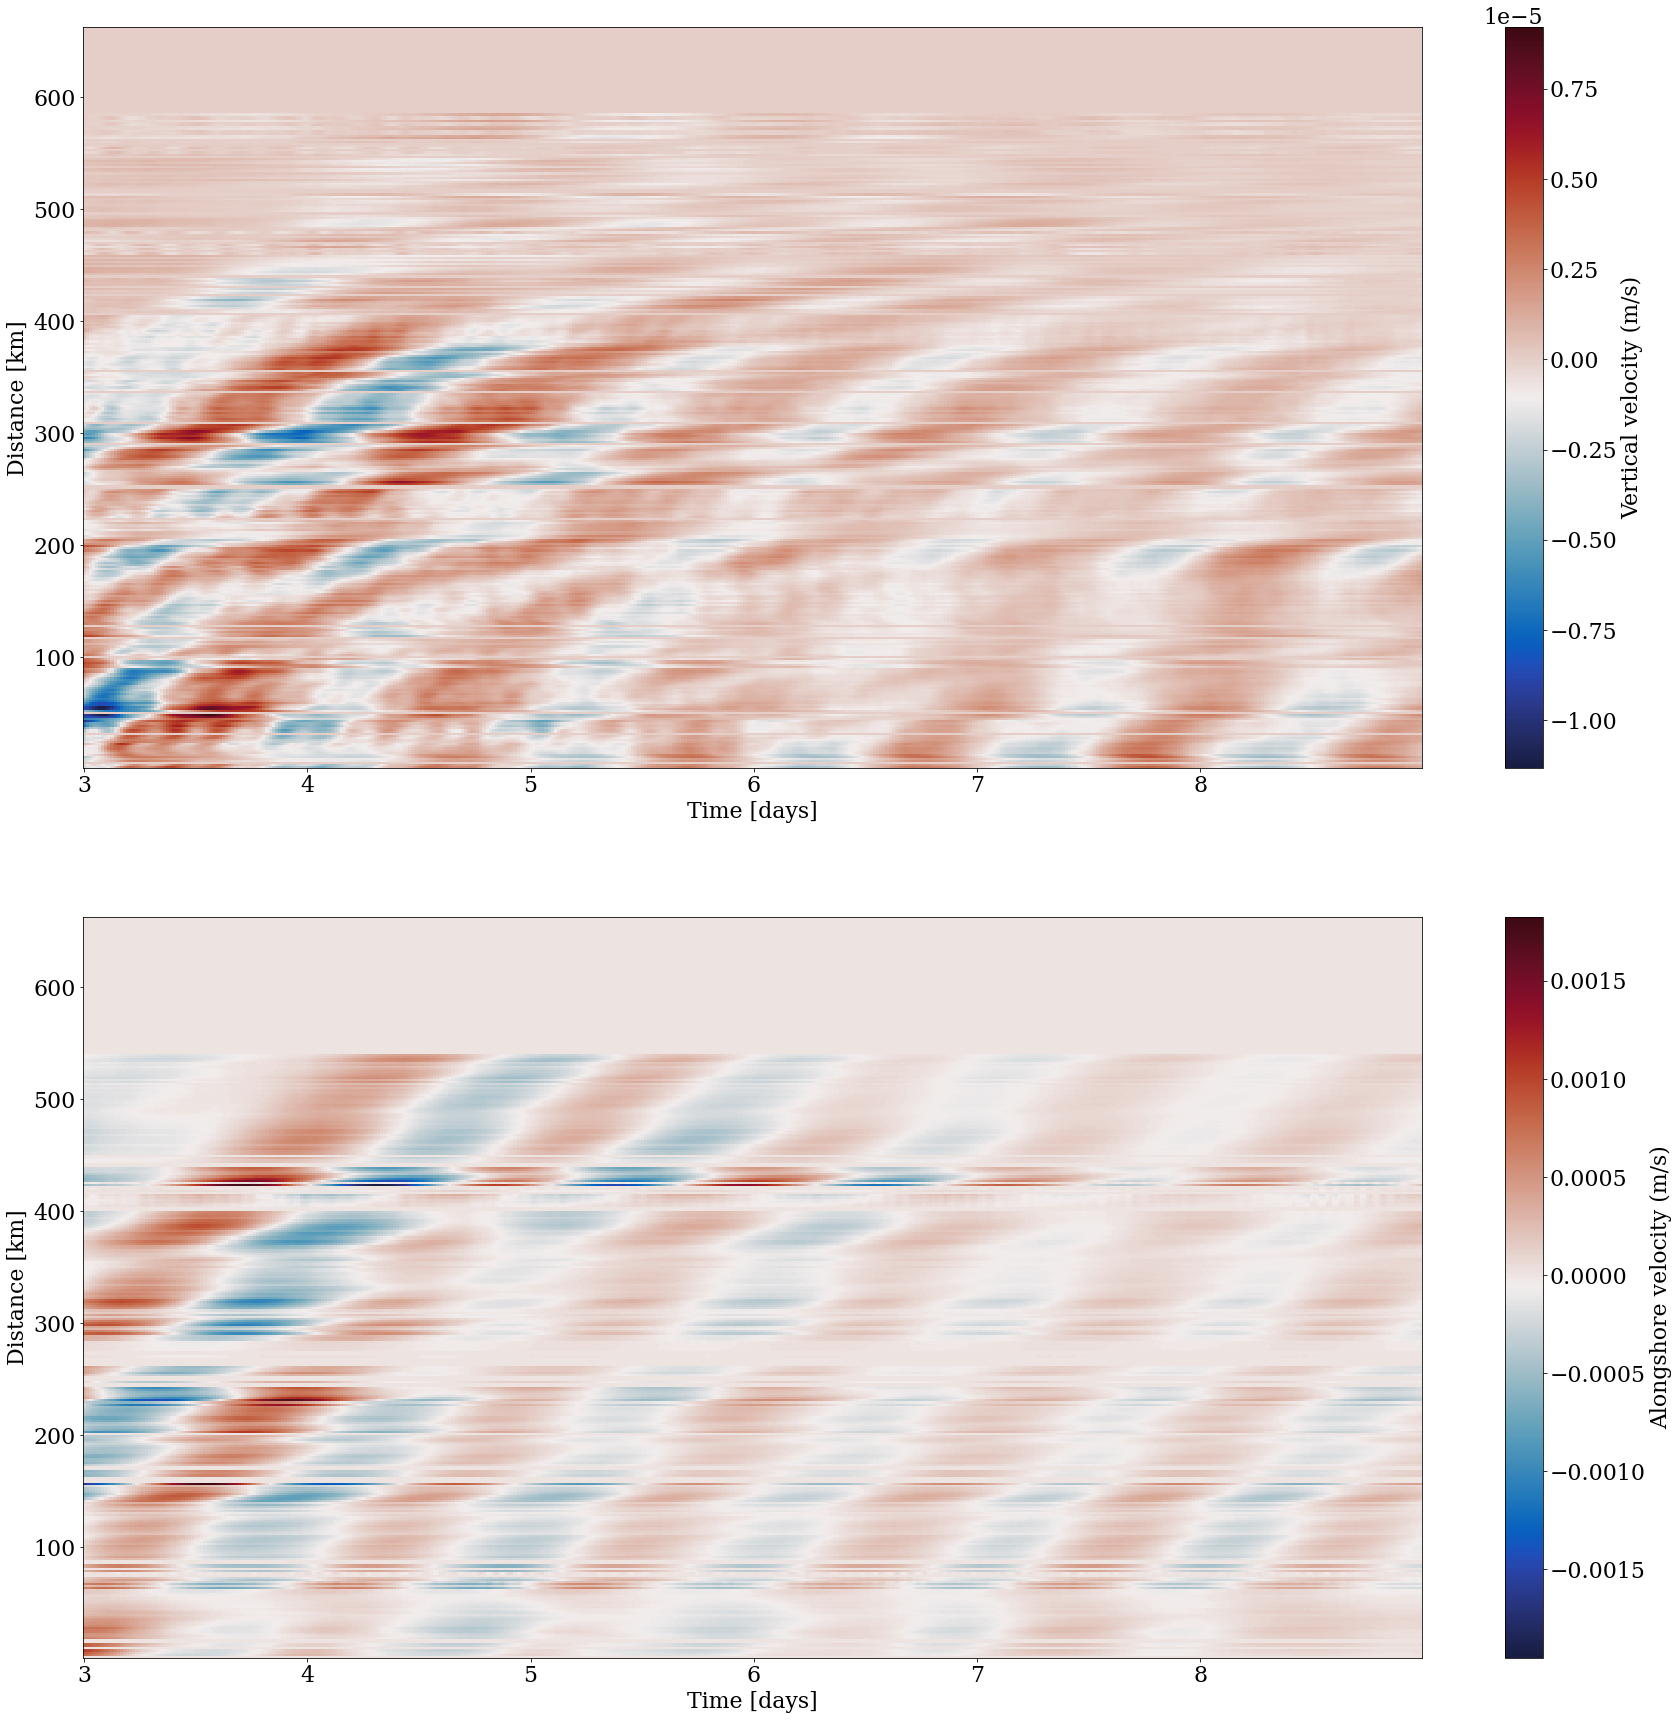

In [49]:
fig = plt.figure(figsize=(30, 30))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[1, 1])

vmax=34.5
vmin=33.3

ax0 = fig.add_subplot(gs[0, 0])
plot_HOVMÖLLER(ax0,X,time,sig.detrend(W[:,65,:],0),'Vertical velocity (m/s)',vmin,vmax,fig)
ax1 = fig.add_subplot(gs[1, 0])
plot_HOVMÖLLER(ax1,X,time,sig.detrend(V[:,0,:],0),'Alongshore velocity (m/s)',vmin,vmax,fig) 
#ax2 = fig.add_subplot(gs[2, 0])
#plot_HOVMÖLLER(ax2,X[:290],times,dens[:,37,:290],'Density (kg/m^3)',vmin,vmax,fig)

In [21]:
def plot_HOVMÖLLER(ax,LON,TIME,VAL,title,vmin,vmax,fig):
    #dep_masked = np.ma.masked_values(depth,0) 
    #mask_dep = np.ma.getmask(dep_masked)
    #ax.set_facecolor('wheat')
    xlab='Time [days]'
    ylab='Distance [km]'
    
    time= TIME/(24*60)
    #time=dat.date2num(TIME)
    
    ax.set(xlabel=xlab, ylabel=ylab)
    #ax.set_xticks([2880, 4320, 5760, 7200, 8640, 10080, 11520, 12960, 14400])
    #ax.set_xticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10])

    #val=VAL.values
    cax = ax.pcolormesh(time,LON,np.transpose(VAL),cmap=cmocean.cm.balance)#,vmin=vmin,vmax=vmax) 
    #ax.xaxis.set_major_locator(dat.MonthLocator())
    
    ##FOR THE SAME COLORBAR FOR ALL OF THE PLOTS
    #cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])
    #fig.colorbar(cax, cax=cbar_ax)
    #cbar_ax.set_ylabel(title)
    
    ##FOR A COLORBAR FOR EACH PLOT
    cbar = plt.colorbar(cax)
    cbar.set_label(title)
    

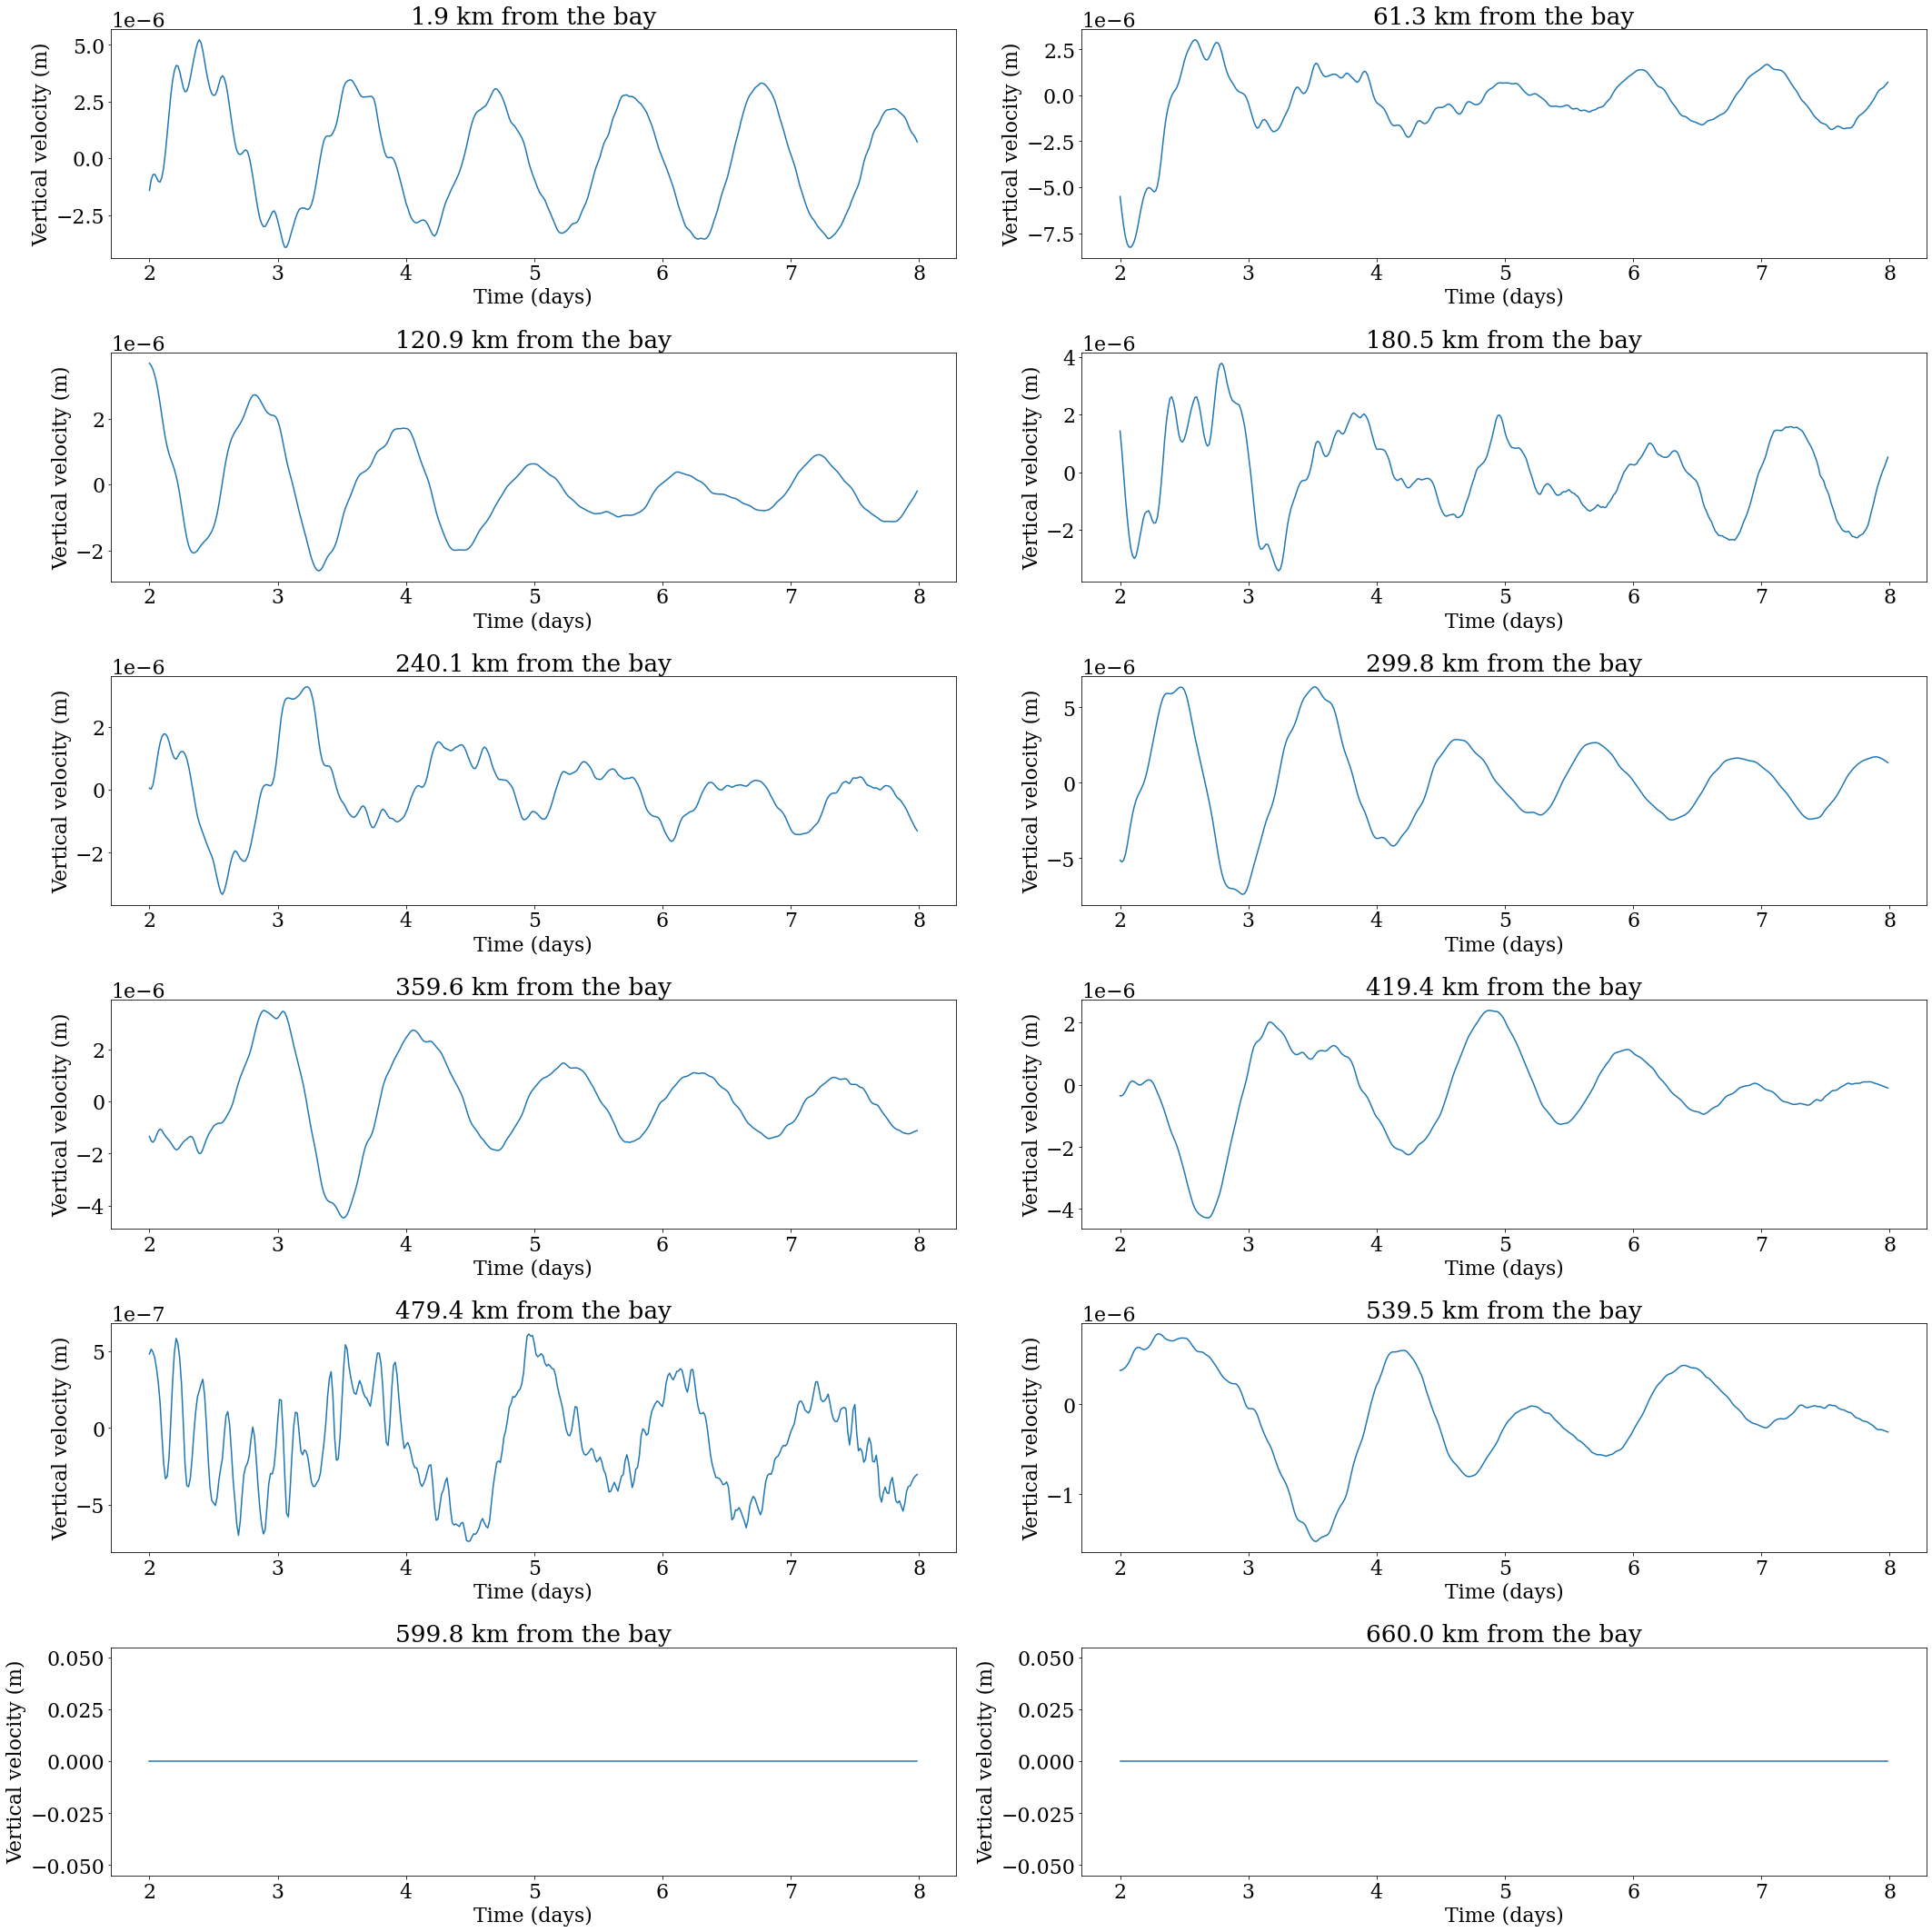

In [47]:
fig,ax=plt.subplots(6,2)

d=32
xlab='Time (days)'
ylab='Vertical velocity (m)'
distance=X.values
VAL=W[:,65,:]
ylimit=0
ylim= [-6*1e-6, 6e-6]
t=(np.arange(len(time))*20)+2880

plt.setp(ax, xticks=[2880, 4320, 5760, 7200, 8640, 10080, 11520, 12960, 14400,], xticklabels=[2, 3, 4, 5, 6, 7, 8, 9, 10])

ax[0,0].plot(t, VAL[:,0])
ax[0,0].set(xlabel=xlab, ylabel=ylab)
ax[0,0].set_title('%1.1f km from the bay' %distance[d*0])
if ylimit==1:
    ax[0,0].set_ylim(ylim)

ax[0,1].plot(t, VAL[:,d])
ax[0,1].set(xlabel=xlab, ylabel=ylab)
ax[0,1].set_title('%1.1f km from the bay' %distance[d*1])
if ylimit==1:
    ax[0,1].set_ylim(ylim)

ax[1,0].plot(t, VAL[:,d*2])
ax[1,0].set(xlabel=xlab, ylabel=ylab)
ax[1,0].set_title('%1.1f km from the bay' %distance[d*2])
if ylimit==1:
    ax[1,0].set_ylim(ylim)

ax[1,1].plot(t, VAL[:,d*3])
ax[1,1].set(xlabel=xlab, ylabel=ylab)
ax[1,1].set_title('%1.1f km from the bay' %distance[d*3])
if ylimit==1:
    ax[1,1].set_ylim(ylim)

ax[2,0].plot(t, VAL[:,d*4])
ax[2,0].set(xlabel=xlab, ylabel=ylab)
ax[2,0].set_title('%1.1f km from the bay' %distance[d*4])
if ylimit==1:
    ax[2,0].set_ylim(ylim)

ax[2,1].plot(t, VAL[:,d*5])
ax[2,1].set(xlabel=xlab, ylabel=ylab)
ax[2,1].set_title('%1.1f km from the bay' %distance[d*5])
if ylimit==1:
    ax[2,1].set_ylim(ylim)

ax[3,0].plot(t, VAL[:,d*6])
ax[3,0].set(xlabel=xlab, ylabel=ylab)
ax[3,0].set_title('%1.1f km from the bay' %distance[d*6])
if ylimit==1:
    ax[3,0].set_ylim(ylim)

ax[3,1].plot(t, VAL[:,d*7])
ax[3,1].set(xlabel=xlab, ylabel=ylab)
ax[3,1].set_title('%1.1f km from the bay' %distance[d*7])
if ylimit==1:    
    ax[3,1].set_ylim(ylim)

ax[4,0].plot(t, VAL[:,d*8])
ax[4,0].set(xlabel=xlab, ylabel=ylab)
ax[4,0].set_title('%1.1f km from the bay' %distance[d*8])
if ylimit==1:
    ax[4,0].set_ylim(ylim)

ax[4,1].plot(t, VAL[:,d*9])
ax[4,1].set(xlabel=xlab, ylabel=ylab)
ax[4,1].set_title('%1.1f km from the bay' %distance[d*9])
if ylimit==1:
    ax[4,1].set_ylim(ylim)

ax[5,0].plot(t, VAL[:,d*10])
ax[5,0].set(xlabel=xlab, ylabel=ylab)
ax[5,0].set_title('%1.1f km from the bay' %distance[d*10])
if ylimit==1:
    ax[5,0].set_ylim(ylim)

ax[5,1].plot(t, VAL[:,d*11])
ax[5,1].set(xlabel=xlab, ylabel=ylab)
ax[5,1].set_title('%1.1f km from the bay' %distance[d*11])
if ylimit==1:
    ax[5,1].set_ylim(ylim)

fig.tight_layout()